In [1]:
import pandas as pd
import re
import json
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import scipy.stats as stats
from sklearn import preprocessing  
import statistics

In [2]:
warnings.filterwarnings('ignore')

Загружаем предоставленные заказчиком данные в датафрейм и посмотрим информацию о датасете

In [3]:
dataset = pd.read_csv("final_task.csv")
dataset.head()

,product_id,title,price,sales,feedbacks,seller,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,Операционная система,Гарантийный срок,Страна производства,Габариты товара,Габариты товара (с упаковкой)
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10 805₽,Купили более 400 раз,7 отзывов,NaN,NaN,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,отсутствует,3года,Россия,"{'Ширина предмета': '28.5 см', 'Глубина предме...","{'Длина упаковки': '43.5 см', 'Ширина упаковки..."
1,17877962,Системный блок,32 900₽,NaN,0 отзывов,NaN,NaN,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,NaN,Китай,"{'Ширина предмета': None, 'Глубина предмета': ...","{'Длина упаковки': '43 см', 'Ширина упаковки':..."
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35 720₽,NaN,0 отзывов,NaN,NaN,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,NaN,NaN,"{'Ширина предмета': None, 'Глубина предмета': ...","{'Длина упаковки': None, 'Ширина упаковки': No..."
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39 237₽,Купили более 10 раз,1 отзыв,Robotcomp,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '28 см', 'Глубина предмета...","{'Длина упаковки': '60 см', 'Ширина упаковки':..."
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76 188₽,Купили более 200 раз,94 отзыва,Robotcomp,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '20 см', 'Глубина предмета...","{'Длина упаковки': '50 см', 'Ширина упаковки':..."


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     4500 non-null   int64  
 1   title                          4500 non-null   object 
 2   price                          4499 non-null   object 
 3   sales                          1164 non-null   object 
 4   feedbacks                      4500 non-null   object 
 5   seller                         4391 non-null   object 
 6   seller_rating                  4389 non-null   float64
 7   Процессор                      4500 non-null   object 
 8   Оперативная память             4500 non-null   object 
 9   Жесткий диск                   4500 non-null   object 
 10  Видеопроцессор                 4500 non-null   object 
 11  Операционная система           4500 non-null   object 
 12  Гарантийный срок               2648 non-null   o

In [5]:
dataset.duplicated().sum()

490

Датасет состоит из 15 признаков и 4500 тысяч наблюдений. Общее количество дубликатов составляет 490. 
Имеется большое количество пропусков по признакам sales(3336 пропусков), гарантийный срок(1852 пропуска) и страна производства (1889 пропусков). 
Присутствую наблюдения, у которых не заполнены данные по комплектующим ПК.
Формат данных object всех признаков кроме product_id(int64) и seller_rating(float64). 

# Очистка и обработка данных для анализа

В признаке title помимо компьютеров присутствую некоторые виды комплектующих для ПК, а также моноблоки и мини-ПК, сборки ПК с мониторами. Данные наблюдения для нас интереса не представляют и их можно удалить из датасета, так как заказчика интересуют только системные блоки. На данном этапе мы можем исключить только позиции, которые можно обнаружить визуально при проспотре датафрейма.

## 1.определим и удалим из датафрейма мини ПК и моноблоки

In [6]:
drop_1_index = dataset['title'].loc[dataset['title'].str.contains('Мини')].index

In [7]:
dataset = dataset.drop(index = drop_1_index)

In [8]:
dataset['title'] = dataset['title'].astype(str)

In [9]:
dataset['title'] = dataset['title'].str.lower()

In [10]:
drop_2_index = dataset['title'].loc[dataset['title'].str.contains(' мини')].index

In [11]:
dataset = dataset.drop(index = drop_2_index)

In [12]:
drop_3_index = dataset['title'].loc[dataset['title'].str.contains('моно')].index

In [13]:
dataset = dataset.drop(index = drop_3_index)

In [14]:
drop_4_index = dataset['title'].loc[dataset['title'].str.contains(' терминал')].index

In [15]:
dataset = dataset.drop(index = drop_4_index)

In [16]:
drop_5_index = dataset['title'].loc[dataset['title'].str.contains('монитор')].index

In [17]:
dataset = dataset.drop(index = drop_5_index)

In [18]:
drop_6_index = dataset['title'].loc[dataset['title'].str.contains('микро')].index

In [19]:
dataset = dataset.drop(index = drop_6_index)

In [20]:
drop_7_index = dataset['title'].loc[dataset['title'].str.contains('larkbox')].index

In [21]:
dataset = dataset.drop(index = drop_7_index)

In [22]:
drop_8_index = dataset['title'].loc[dataset['title'].str.contains('herobox')].index

In [23]:
dataset = dataset.drop(index = drop_8_index)

In [24]:
dataset.shape

(4087, 16)

## 2. Найдем и удалим из датафрейма комплектующие для ПК

У комплектующих для ПК можно выделить один общий показатель: наблюдения признаков Процессор, оперативная память, видеопроцессор и жесткий диск будут иметь значение "не заполнено"

### 2.1Выведем тип процессора и количество ядер процессора в отдельные признаки

In [25]:
def type_proc(text):
    type_proc = json.loads(text.replace("'", '"'))['Процессор_тип']
    if type_proc == 'не заполнено':
        return np.nan
    else:
        return type_proc

In [26]:
dataset['type_proc'] = dataset['Процессор'].apply(type_proc)

In [27]:
dataset['type_proc'].value_counts()

Intel Core i5                                1290
Intel Core i7                                 765
Intel Core i3                                 564
AMD Ryzen 5                                   555
AMD Athlon                                    134
Intel Xeon                                     83
AMD Ryzen 7                                    80
AMD Ryzen 3                                    59
AMD A6                                         52
Intel Pentium                                  44
Intel Core i9                                  15
Intel Celeron                                   9
Apple M1                                        7
AMD A12-9800E                                   6
AMD Ryzen 9                                     5
Intel                                           4
Intel Core 12400F                               4
AMD рязань 5 5600x                              2
AMD Ryzen 6                                     2
AMD Radeon RX 570                               2


На данном этапе можно исключить еще несколько наблюдений из датафрейма: процессоры AMD E1-6010 и Gemini устанавливаются только в мини-ПК, а процессоры Apple M1 в моноблоках

In [28]:
dataset = dataset[dataset['type_proc'] != 'AMD E1-6010']
dataset = dataset[dataset['type_proc'] != 'Gemini Lake Refresh J4125']
dataset = dataset[dataset['type_proc'] != 'Gemini Lake Refresh J4115']
dataset = dataset[dataset['type_proc'] != 'Apple M1']

In [29]:
dataset.shape

(4077, 17)

In [30]:
dataset.type_proc.isna().sum()

385

### 2.2 Выведем количество ядер процессора в отдельный признак

In [31]:
def core_count(text):
    core_count = json.loads(text.replace("'", '"'))['Количество ядер процессора']
    if core_count == 'не заполнено':
        return np.nan
    else:
        core_count = core_count.replace('ядра', '').replace('ядер', '').replace('Ядер 16 потоков', '').rstrip()
        return int(core_count)

In [32]:
dataset['core_count'] = dataset['Процессор'].apply(core_count)

In [33]:
dataset['core_count'].value_counts()

6.0     1641
4.0      813
8.0      465
12.0     297
2.0      289
10.0     148
24.0      69
16.0      44
14.0       7
Name: core_count, dtype: int64

In [34]:
dataset.core_count.isna().sum()

304

In [35]:
dataset.shape

(4077, 18)

### 2.3 Выведем тип оперативной памяти в отдельный признак

In [36]:
def type_ram(text):
    type_ram = text.split(',')[0].replace("{'Тип оперативной памяти': ", '').replace("'", '')
    if type_ram == 'не заполнено' or type_ram == '16' or type_ram == '4GB' or type_ram == 'RAM 16 ГБ':
        return np.nan
    else:
        return type_ram

In [37]:
dataset['type_ram'] = dataset['Оперативная память'].apply(type_ram)

In [38]:
dataset['type_ram'].value_counts()

DDR 4    3411
DDR 3     340
DDR 5      14
Name: type_ram, dtype: int64

In [39]:
dataset.shape

(4077, 19)

In [40]:
dataset.type_ram.isna().sum()

312

### 2.4 Выведем объем оперативной памяти в отдельный признак

In [41]:
def vol_ram(text):
    vol_ram = text.split(',')[1].split(':')[1].replace('}', '').replace("'", '').split(' ')[1].replace('ГБ', '')
    if vol_ram.isdigit():
        return int(vol_ram)
    else:
        return np.nan

In [42]:
dataset['vol_ram'] = dataset['Оперативная память'].apply(vol_ram)

In [43]:
dataset['vol_ram'].value_counts()

16.0      2259
32.0       767
8.0        572
4.0        108
64.0        73
240.0        1
2.0          1
1000.0       1
Name: vol_ram, dtype: int64

Удалим из датафрейма наблюдения с аномальными значениями 240 и 1000

In [44]:
dataset = dataset[dataset['vol_ram'] != 1000]
dataset = dataset[dataset['vol_ram'] != 240]

In [45]:
dataset['vol_ram'].value_counts()

16.0    2259
32.0     767
8.0      572
4.0      108
64.0      73
2.0        1
Name: vol_ram, dtype: int64

In [46]:
dataset.shape

(4075, 20)

In [47]:
dataset.vol_ram.isna().sum()

295

### 2.5 Выведем объем HDD в отдельный признак

In [48]:
def hdd_vol(text):
    hdd_vol = text.split(',')[0].split(':')[1].split(';')[0].lower().replace('gb', '').replace('гб', '').replace('тб', '').replace('tb', '').replace("'", '').replace(" ", '')
    #return hdd_vol
    if hdd_vol.isdigit():
        return int(hdd_vol)
    else:
        return np.nan

In [49]:
dataset['hdd_vol'] = dataset['Жесткий диск'].apply(hdd_vol)

In [50]:
dataset['hdd_vol'].value_counts()

1000.0    992
1.0       119
500.0      94
2000.0     24
512.0      10
2.0         7
1024.0      5
3000.0      1
4000.0      1
Name: hdd_vol, dtype: int64

In [51]:
dataset.hdd_vol.isna().sum()

2822

In [52]:
dataset.shape

(4075, 21)

В результате мы получили значения 1 и 2, которые ранее были указаны в терабайтах, переведем их в гигабайты. Также видно, что многие значения близки друг к другу: 500 и 512, 250 и 256, 1000 и 1024. Приведем их к одному виду.

In [53]:
dataset.loc[dataset['hdd_vol'] == 1, 'hdd_vol'] = 1000
dataset.loc[dataset['hdd_vol'] == 2, 'hdd_vol'] = 2000
dataset.loc[dataset['hdd_vol'] == 512, 'hdd_vol'] = 500
dataset.loc[dataset['hdd_vol'] == 1024, 'hdd_vol'] = 1000

In [54]:
dataset['hdd_vol'].value_counts()

1000.0    1116
500.0      104
2000.0      31
3000.0       1
4000.0       1
Name: hdd_vol, dtype: int64

In [55]:
dataset.hdd_vol.isna().sum()

2822

In [56]:
dataset.shape

(4075, 21)

### 2.6 Выведем объем SSD в отдельные признаки

In [57]:
def ssd_vol(text):
    ssd_vol = text.split(',')[1].split(':')[1].split()[0].lower().replace('gb', '').replace('гб', '').replace('}', '').replace("'", '').replace(";", '')
    if ssd_vol.isdigit():
        return int(ssd_vol)
    else:
        return np.nan

In [58]:
dataset['ssd_vol'] = dataset['Жесткий диск'].apply(ssd_vol)

In [59]:
dataset['ssd_vol'].value_counts()

480.0     1199
1000.0     736
240.0      412
512.0      406
256.0      302
960.0      230
120.0      154
500.0      107
128.0       55
2.0         31
1.0         24
250.0       21
2000.0      18
1024.0      11
1240.0       8
1480.0       6
1500.0       4
64.0         3
60.0         1
Name: ssd_vol, dtype: int64

В результате мы получили аномальные значения (для объема ssd), удалим их. Также видно, что многие значения близки друг к другу: 480 и 500 и 512, 250 и 256, 1000 и 1024. Приведем их к одному виду.

In [60]:
dataset.loc[dataset['ssd_vol'] == 480, 'ssd_vol'] = 500
dataset.loc[dataset['ssd_vol'] == 512, 'ssd_vol'] = 500
dataset.loc[dataset['ssd_vol'] == 240, 'ssd_vol'] = 250
dataset.loc[dataset['ssd_vol'] == 256, 'ssd_vol'] = 500
dataset.loc[dataset['ssd_vol'] == 64, 'ssd_vol'] = 60
dataset.loc[dataset['ssd_vol'] == 960, 'ssd_vol'] = 1000
dataset.loc[dataset['ssd_vol'] == 1024, 'ssd_vol'] = 1000
dataset.loc[dataset['ssd_vol'] == 128, 'ssd_vol'] = 120
dataset.loc[dataset['ssd_vol'] == 1480, 'ssd_vol'] = 1500

In [61]:
dataset = dataset[dataset['ssd_vol'] != 1]
dataset = dataset[dataset['ssd_vol'] != 2]

In [62]:
dataset['ssd_vol'].value_counts()

500.0     2014
1000.0     977
250.0      433
120.0      209
2000.0      18
1500.0      10
1240.0       8
60.0         4
Name: ssd_vol, dtype: int64

In [63]:
dataset.ssd_vol.isna().sum()

347

In [64]:
dataset.shape

(4020, 22)

In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 0 to 4499
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     4020 non-null   int64  
 1   title                          4020 non-null   object 
 2   price                          4019 non-null   object 
 3   sales                          968 non-null    object 
 4   feedbacks                      4020 non-null   object 
 5   seller                         3918 non-null   object 
 6   seller_rating                  3916 non-null   float64
 7   Процессор                      4020 non-null   object 
 8   Оперативная память             4020 non-null   object 
 9   Жесткий диск                   4020 non-null   object 
 10  Видеопроцессор                 4020 non-null   object 
 11  Операционная система           4020 non-null   object 
 12  Гарантийный срок               2407 non-null   o

### 2.7 В признаке Видеопроцессор заменим значение "не заполнено" на NaN

In [66]:
dataset['Видеопроцессор'].value_counts()

NVIDIA GeForce RTX 3060        661
NVIDIA GeForce RTX 3050        491
не заполнено                   375
NVIDIA GeForce GTX 1650        359
NVIDIA GeForce GTX 1660        295
                              ... 
RTX 1650 4GB                     1
Intel Core i3 10105F 3.7ГГц      1
Без видеокарты                   1
NVIDIA Quadro T400               1
NVIDIA GeForce GTX 970           1
Name: Видеопроцессор, Length: 62, dtype: int64

In [67]:
def videocard(text):
    if text == 'не заполнено':
        return np.nan
    else:
        return text

In [68]:
dataset['videocard'] = dataset['Видеопроцессор'].apply(videocard)

In [69]:
dataset['videocard'].value_counts()

NVIDIA GeForce RTX 3060        661
NVIDIA GeForce RTX 3050        491
NVIDIA GeForce GTX 1650        359
NVIDIA GeForce GTX 1660        295
Intel HD Graphics 2000         248
                              ... 
RTX 1650 4GB                     1
Intel Core i3 10105F 3.7ГГц      1
Без видеокарты                   1
NVIDIA Quadro T400               1
NVIDIA GeForce GTX 970           1
Name: videocard, Length: 61, dtype: int64

In [70]:
dataset.videocard.isna().sum()

375

Удалим ненужные столбцы из датафрейма

In [71]:
columns = ['Процессор', 'Оперативная память', 'Жесткий диск', 'Видеопроцессор']

In [72]:
dataset = dataset.drop(columns, axis = 1)

In [73]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 0 to 4499
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     4020 non-null   int64  
 1   title                          4020 non-null   object 
 2   price                          4019 non-null   object 
 3   sales                          968 non-null    object 
 4   feedbacks                      4020 non-null   object 
 5   seller                         3918 non-null   object 
 6   seller_rating                  3916 non-null   float64
 7   Операционная система           4020 non-null   object 
 8   Гарантийный срок               2407 non-null   object 
 9   Страна производства            2181 non-null   object 
 10  Габариты товара                4020 non-null   object 
 11  Габариты товара (с упаковкой)  4020 non-null   object 
 12  type_proc                      3635 non-null   o

Заменим значения NaN в признаках 'type_proc', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'videocard' на 0

In [74]:
dataset[['type_proc', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'videocard', 'type_ram']] = dataset[['type_proc', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'videocard', 'type_ram']].fillna(0)

In [75]:
dataset.shape

(4020, 19)

In [76]:
dataset['core_count'] = dataset['core_count'].astype("Int64")

In [77]:
dataset['vol_ram'] = dataset['vol_ram'].astype("Int64")

In [78]:
dataset['hdd_vol'] = dataset['hdd_vol'].astype("Int64")

In [79]:
dataset['ssd_vol'] = dataset['ssd_vol'].astype("Int64")

Отфильтруем значения по признакам 'core_count', 'vol_ram' и 'videocard' не равными 0

In [80]:
dataset = dataset[dataset['core_count'] != 0] 

In [81]:
dataset = dataset[dataset['vol_ram'] != 0] 

In [82]:
dataset = dataset[dataset['videocard'] != 0] 

In [83]:
dataset.shape

(3640, 19)

Теперь необходимо отфильтровать наблюдения у которых одновременно значения 'hdd_vol' и 'ssd_vol' равны 0

In [84]:
dataset = dataset[(dataset['hdd_vol'] != 0) |(dataset['ssd_vol'] != 0 )]

In [85]:
dataset = dataset[dataset['type_ram'] != 0] 

In [86]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3633 entries, 3 to 4499
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3633 non-null   int64  
 1   title                          3633 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          854 non-null    object 
 4   feedbacks                      3633 non-null   object 
 5   seller                         3556 non-null   object 
 6   seller_rating                  3554 non-null   float64
 7   Операционная система           3633 non-null   object 
 8   Гарантийный срок               2307 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3633 non-null   object 
 11  Габариты товара (с упаковкой)  3633 non-null   object 
 12  type_proc                      3633 non-null   o

Прекрассно!!! Теперь в нашем датафрейме есть ненулевые данные о запчастях ПК. В процессе очистки и преобразование категориальных признаков из датафрейма было удалено 867 наблюдений. Данные наблюдения не удовлетворяют условиям задачи заказчика, но, в их число также попали ПК, в названии которых присутствуют данные о процессоре, видеокарте и т.д. В дальнейшем, в случае нехватки данных для анализа, мы можем вернуться к этому шагу и обработать данные, попавшие в перечень удаленных.

Сбросим индексы, для удобства сохраним полученный датафрейм в формат csv

In [87]:
dataset.reset_index(drop= True , inplace= True )

In [88]:
dataset.to_csv('inter_res.csv', index = False)

## 3. Приведем количественные признаки к числовому формату

In [89]:
df_copy = pd.read_csv("inter_res.csv")

In [90]:
df_copy.head()

,product_id,title,price,sales,feedbacks,seller,seller_rating,Операционная система,Гарантийный срок,Страна производства,Габариты товара,Габариты товара (с упаковкой),type_proc,core_count,type_ram,vol_ram,hdd_vol,ssd_vol,videocard
0,19347937,офисный компьютер robotcomp казначей v1,39 237₽,Купили более 10 раз,1 отзыв,Robotcomp,4.7,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '28 см', 'Глубина предмета...","{'Длина упаковки': '60 см', 'Ширина упаковки':...",Intel Core i5,6,DDR 4,8,0,500,Intel UHD Graphics 630
1,19348951,игровой компьютер robotcomp м16 2.0 v1,76 188₽,Купили более 200 раз,94 отзыва,Robotcomp,4.7,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '20 см', 'Глубина предмета...","{'Длина упаковки': '50 см', 'Ширина упаковки':...",Intel Core i5,6,DDR 4,16,0,1000,NVIDIA GeForce GTX 1660
2,19355097,игровой компьютер robotcomp m-16 v1,55 625₽,Купили более 40 раз,12 отзывов,Robotcomp,4.7,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '20 см', 'Глубина предмета...","{'Длина упаковки': '50 см', 'Ширина упаковки':...",Intel Core i5,6,DDR 4,16,0,500,NVIDIA GeForce GTX 1650
3,19355097,игровой компьютер robotcomp m-16 v1,55 625₽,Купили более 40 раз,12 отзывов,Robotcomp,4.7,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '20 см', 'Глубина предмета...","{'Длина упаковки': '50 см', 'Ширина упаковки':...",Intel Core i5,6,DDR 4,16,0,500,NVIDIA GeForce GTX 1650
4,19358744,игровой компьютер robotcomp анаконда 2.0 v1,128 284₽,Купили более 5 раз,4 отзыва,Robotcomp,4.7,windows пробная,3 Года (36 месяцев),Россия,"{'Ширина предмета': '21 см', 'Глубина предмета...","{'Длина упаковки': '57 см', 'Ширина упаковки':...",Intel Core i5,10,DDR 4,16,0,1000,NVIDIA GeForce RTX 3070


### 3.1 Признак price

In [91]:
df_copy["price"] = df_copy["price"].astype(str)

In [92]:
def clear_price(text):
    price = text.replace('\xa0', '').replace('₽', '')
    if price == '':
        return np.nan
    else:
        return price

In [93]:
df_copy['clear_price'] = df_copy['price'].apply(clear_price)

In [94]:
df_copy['clear_price'] = df_copy["clear_price"].astype("float64")

In [95]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633 entries, 0 to 3632
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3633 non-null   int64  
 1   title                          3633 non-null   object 
 2   price                          3633 non-null   object 
 3   sales                          854 non-null    object 
 4   feedbacks                      3633 non-null   object 
 5   seller                         3556 non-null   object 
 6   seller_rating                  3554 non-null   float64
 7   Операционная система           3633 non-null   object 
 8   Гарантийный срок               2307 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3633 non-null   object 
 11  Габариты товара (с упаковкой)  3633 non-null   object 
 12  type_proc                      3633 non-null   o

В результате получили одно незаполненное значение, удалим его из датафрейма

In [96]:
df_copy[['clear_price']] = df_copy[['clear_price']].fillna(0)

In [97]:
df_copy = df_copy[df_copy['clear_price'] != 0] 

In [98]:
df_copy['clear_price'] = df_copy["clear_price"].astype("Int64")

In [99]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3632 non-null   int64  
 1   title                          3632 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          853 non-null    object 
 4   feedbacks                      3632 non-null   object 
 5   seller                         3555 non-null   object 
 6   seller_rating                  3553 non-null   float64
 7   Операционная система           3632 non-null   object 
 8   Гарантийный срок               2306 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3632 non-null   object 
 11  Габариты товара (с упаковкой)  3632 non-null   object 
 12  type_proc                      3632 non-null   o

### 3.2 Признак sales

In [100]:
df_copy.sales.unique()

array(['Купили более 10 раз', 'Купили более 200 раз',
       'Купили более 40 раз', 'Купили более 5 раз', 'Купили более 30 раз',
       'Купили более 20 раз', 'Купили более 50 раз', 'Купили менее 5 раз',
       'Купили более 400 раз', 'Купили более 500 раз',
       'Купили более 100 раз', 'Купили более 80 раз', nan,
       'Купили более 800 раз', 'Купили более 90 раз',
       'Купили более 300 раз', 'Купили более 70 раз',
       'Купили более 60 раз'], dtype=object)

In [101]:
def clear_sales(sales):
    if pd.isna(sales):
        return np.nan
    else:
        return re.sub('\D', '', sales)

In [102]:
df_copy['clear_sales'] = df_copy['sales'].apply(clear_sales)

In [103]:
df_copy['clear_sales'] = df_copy["clear_sales"].astype("Int64")

Признак clear_sales по условиям задания является целевым и в то же время имеет огромное количество пропущенных значений. Для дальнейшего анализа считаю что можно заполнить пропуски медианным значением.

In [104]:
df_copy['clear_sales'] = df_copy['clear_sales'].fillna(df_copy['clear_sales'].median())

In [105]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3632 non-null   int64  
 1   title                          3632 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          853 non-null    object 
 4   feedbacks                      3632 non-null   object 
 5   seller                         3555 non-null   object 
 6   seller_rating                  3553 non-null   float64
 7   Операционная система           3632 non-null   object 
 8   Гарантийный срок               2306 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3632 non-null   object 
 11  Габариты товара (с упаковкой)  3632 non-null   object 
 12  type_proc                      3632 non-null   o

### 3.3 Признак feedbacks

In [106]:
df_copy.feedbacks.unique()

array(['1 отзыв', '94 отзыва', '12 отзывов', '4 отзыва', '9 отзывов',
       '3 отзыва', '2 отзыва', '6 отзывов', '17 отзывов', '25 отзывов',
       '0 отзывов', '8 отзывов', '5 отзывов', '101 отзыв', '128 отзывов',
       '54 отзыва', '42 отзыва', '84 отзыва', '7 отзывов', '21 отзыв',
       '14 отзывов', '16 отзывов', '38 отзывов', '13 отзывов',
       '148 отзывов', '30 отзывов', '18 отзывов', '47 отзывов',
       '34 отзыва', '22 отзыва', '77 отзывов', '89 отзывов', '19 отзывов',
       '26 отзывов', '66 отзывов', '11 отзывов', '39 отзывов',
       '15 отзывов', '296 отзывов', '189 отзывов', '74 отзыва',
       '10 отзывов', '117 отзывов', '78 отзывов', '59 отзывов',
       '29 отзывов', '279 отзывов', '80 отзывов'], dtype=object)

In [107]:
def clear_feedbacks(feedbacks):
    if pd.isna(feedbacks):
        return np.nan
    else:
        return re.sub('\D', '', feedbacks)

In [108]:
df_copy['clear_feedbacks'] = df_copy['feedbacks'].apply(clear_feedbacks)

In [109]:
df_copy.clear_feedbacks.value_counts()

0      2961
1       235
2        81
3        54
4        52
5        24
8        20
7        17
6        16
19       12
25       11
11        9
30        9
13        8
14        8
16        6
80        6
12        6
148       5
47        5
21        5
279       5
78        5
10        5
15        4
34        4
84        4
18        4
17        4
9         4
189       3
22        3
54        3
128       3
117       3
89        3
101       3
94        3
42        3
296       2
74        2
38        2
66        2
26        2
59        2
29        2
39        1
77        1
Name: clear_feedbacks, dtype: int64

In [110]:
df_copy['clear_feedbacks'] = df_copy["clear_feedbacks"].astype("Int64")

In [111]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3632 non-null   int64  
 1   title                          3632 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          853 non-null    object 
 4   feedbacks                      3632 non-null   object 
 5   seller                         3555 non-null   object 
 6   seller_rating                  3553 non-null   float64
 7   Операционная система           3632 non-null   object 
 8   Гарантийный срок               2306 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3632 non-null   object 
 11  Габариты товара (с упаковкой)  3632 non-null   object 
 12  type_proc                      3632 non-null   o

### 3.4 Признак Гарантийный срок

In [112]:
df_copy.rename(columns = {'Гарантийный срок':'garanty'}, inplace = True )

In [113]:
df_copy['garanty'].value_counts()

3 Года (36 месяцев)        809
1 год                      674
3 года                     511
12 месяцев                 141
36 месяцев                  52
12 месяцев от KING KOMP     30
24 месяца                   23
2 года                      19
1 год; 12 мес               14
1 год; 12 месяцев            8
1 год (12 месяцев)           6
12 месяцев от King Komp      4
36 мес.                      3
24 мес                       3
3 месяца                     2
14 дней                      2
36 мес                       2
1                            1
12 мес.                      1
6 месяцев                    1
Name: garanty, dtype: int64

In [114]:
def clear_garanty(garanty):
    if pd.isna(garanty):
        return np.nan
    else:
        return re.sub('\D', ',', garanty)[0:3]

In [115]:
df_copy['clear_garanty'] = df_copy['garanty'].apply(clear_garanty)

In [116]:
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace(',', '')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('12', '1')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('365', '1')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('24', '2')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('36', '3')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('6', '0.5')
df_copy['clear_garanty'] = df_copy['clear_garanty'].str.replace('14', '0')

In [117]:
df_copy['clear_garanty'] = df_copy["clear_garanty"].astype("float64")

In [118]:
df_copy['clear_garanty'].value_counts()

3.0    1379
1.0     879
2.0      45
0.0       2
0.5       1
Name: clear_garanty, dtype: int64

In [119]:
def clear_garanty_fix(clear_garanty):
    if pd.isna(clear_garanty) or clear_garanty == 0:
        return np.nan
    else:
        return clear_garanty

In [120]:
df_copy['clear_garanty'] = df_copy['clear_garanty'].apply(clear_garanty_fix)

In [121]:
df_copy['clear_garanty'].value_counts()

3.0    1379
1.0     879
2.0      45
0.5       1
Name: clear_garanty, dtype: int64

Заполним пропуски медианным значением

In [122]:
df_copy['clear_garanty'] = df_copy['clear_garanty'].fillna(df_copy['clear_garanty'].median())

In [123]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3632 non-null   int64  
 1   title                          3632 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          853 non-null    object 
 4   feedbacks                      3632 non-null   object 
 5   seller                         3555 non-null   object 
 6   seller_rating                  3553 non-null   float64
 7   Операционная система           3632 non-null   object 
 8   garanty                        2306 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3632 non-null   object 
 11  Габариты товара (с упаковкой)  3632 non-null   object 
 12  type_proc                      3632 non-null   o

### 3.5 Признак Габариты товара

In [124]:
df_copy['Габариты товара'].value_counts()

{'Ширина предмета': None, 'Глубина предмета': None, 'Высота предмета': None, 'Вес без упаковки (кг)': '10 кг'}              635
{'Ширина предмета': None, 'Глубина предмета': None, 'Высота предмета': None, 'Вес без упаковки (кг)': None}                 414
{'Ширина предмета': None, 'Глубина предмета': None, 'Высота предмета': None, 'Вес без упаковки (кг)': '8 кг'}               365
{'Ширина предмета': None, 'Глубина предмета': None, 'Высота предмета': None, 'Вес без упаковки (кг)': '9 кг'}               316
{'Ширина предмета': '20 см', 'Глубина предмета': '40 см', 'Высота предмета': '45 см', 'Вес без упаковки (кг)': '7 кг'}      158
                                                                                                                           ... 
{'Ширина предмета': '40 см', 'Глубина предмета': '7 см', 'Высота предмета': '37 см', 'Вес без упаковки (кг)': '5 кг'}         1
{'Ширина предмета': '45 см', 'Глубина предмета': '26 см', 'Высота предмета': '48 см', 'Вес без упаковки 

In [125]:
def product_dimension(text):
    width = text.split(',')[0].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    depth = text.split(',')[1].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    hight = text.split(',')[2].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    wight = text.split(',')[3].split(':')[1].replace('кг', '').rstrip().rstrip().replace('}', '')
    return width + ' ' + depth + ' ' + hight + ' ' + wight

In [126]:
df_copy['product_dimension'] = df_copy['Габариты товара'].apply(product_dimension)

In [127]:
df_copy['product_dimension'].value_counts()

 None  None  None  '10 '        635
 None  None  None  None         414
 None  None  None  '8 '         365
 None  None  None  '9 '         316
 '20 '  '40 '  '45 '  '7 '      158
                               ... 
 '40 '  '7 '  '37 '  '5 '         1
 '45 '  '26 '  '48 '  '9 '        1
 '18 '  None  '32 '  '4 '         1
 '37 '  '19 '  '39 '  '5.5 '      1
 None  None  None  '7.4 '         1
Name: product_dimension, Length: 171, dtype: int64

### 3.6 Признак Габариты товара (с упаковкой)

In [128]:
df_copy['Габариты товара (с упаковкой)'].value_counts()

{'Длина упаковки': '60 см', 'Ширина упаковки': '30 см', 'Высота упаковки': '60 см', 'Вес с упаковкой (кг)': '12 кг'}       613
{'Длина упаковки': '60 см', 'Ширина упаковки': '25 см', 'Высота упаковки': '60 см', 'Вес с упаковкой (кг)': '12 кг'}       252
{'Длина упаковки': '50 см', 'Ширина упаковки': '25 см', 'Высота упаковки': '44 см', 'Вес с упаковкой (кг)': '8 кг'}        158
{'Длина упаковки': '60 см', 'Ширина упаковки': '25 см', 'Высота упаковки': '60 см', 'Вес с упаковкой (кг)': '11 кг'}       154
{'Длина упаковки': '39 см', 'Ширина упаковки': '19.6 см', 'Высота упаковки': '33.6 см', 'Вес с упаковкой (кг)': '4 кг'}    117
                                                                                                                          ... 
{'Длина упаковки': '42 см', 'Ширина упаковки': '21 см', 'Высота упаковки': '46 см', 'Вес с упаковкой (кг)': '8 кг'}          1
{'Длина упаковки': '7 см', 'Ширина упаковки': '19 см', 'Высота упаковки': '19 см', 'Вес с упаковкой (кг)': '3.8

In [129]:
def product_packaged(text):
    width = text.split(',')[1].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    depth = text.split(',')[0].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    hight = text.split(',')[2].split(':')[1].replace('см', '').rstrip().rstrip().replace('}', '')
    wight = text.split(',')[3].split(':')[1].replace('кг', '').rstrip().rstrip().replace('}', '')
    return width + ' ' + depth + ' ' + hight + ' ' + wight

In [130]:
df_copy['product_packaged'] = df_copy['Габариты товара (с упаковкой)'].apply(product_packaged)

In [131]:
df_copy['product_packaged'].value_counts()

 '30 '  '60 '  '60 '  '12 '       613
 '25 '  '60 '  '60 '  '12 '       252
 '25 '  '50 '  '44 '  '8 '        158
 '25 '  '60 '  '60 '  '11 '       154
 '19.6 '  '39 '  '33.6 '  '4 '    117
                                 ... 
 '21 '  '42 '  '46 '  '8 '          1
 '19 '  '7 '  '19 '  '3.8 '         1
 '30 '  '60 '  '60 '  '9 '          1
 None  '40 '  None  None            1
 '15 '  '45 '  '33 '  '9 '          1
Name: product_packaged, Length: 257, dtype: int64

In [132]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     3632 non-null   int64  
 1   title                          3632 non-null   object 
 2   price                          3632 non-null   object 
 3   sales                          853 non-null    object 
 4   feedbacks                      3632 non-null   object 
 5   seller                         3555 non-null   object 
 6   seller_rating                  3553 non-null   float64
 7   Операционная система           3632 non-null   object 
 8   garanty                        2306 non-null   object 
 9   Страна производства            1897 non-null   object 
 10  Габариты товара                3632 non-null   object 
 11  Габариты товара (с упаковкой)  3632 non-null   object 
 12  type_proc                      3632 non-null   o

Удалим лишние признаки

In [133]:
columns_2 = ['garanty', 'feedbacks',  'sales', 'price', 'Габариты товара', 'Габариты товара (с упаковкой)']

In [134]:
df_copy = df_copy.drop(columns_2, axis = 1)

In [135]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            3632 non-null   int64  
 1   title                 3632 non-null   object 
 2   seller                3555 non-null   object 
 3   seller_rating         3553 non-null   float64
 4   Операционная система  3632 non-null   object 
 5   Страна производства   1897 non-null   object 
 6   type_proc             3632 non-null   object 
 7   core_count            3632 non-null   int64  
 8   type_ram              3632 non-null   object 
 9   vol_ram               3632 non-null   int64  
 10  hdd_vol               3632 non-null   int64  
 11  ssd_vol               3632 non-null   int64  
 12  videocard             3632 non-null   object 
 13  clear_price           3632 non-null   Int64  
 14  clear_sales           3632 non-null   Int64  
 15  clear_feedbacks      

На этом основная работа по очистке данных завершена. Теперь можно привести максимально к одному виду процессоры и видеокарты, так как данные по одним и тем же наблюдениям в этих признаках записаны по разному.

### 4.1 Признак type_proc  

In [136]:
df_copy["type_proc"] = df_copy["type_proc"].astype(str)

In [137]:
df_copy["type_proc"] = df_copy["type_proc"].str.lower()

In [138]:
df_copy['type_proc'].value_counts()

intel core i5                           1201
intel core i7                            758
amd ryzen 5                              548
intel core i3                            543
amd athlon                               133
0                                         84
intel xeon                                82
amd ryzen 7                               80
amd ryzen 3                               59
amd a6                                    51
intel pentium                             42
intel core i9                             14
amd a12-9800e                              6
intel core 12400f                          5
intel celeron                              5
amd ryzen 9                                4
amd ryzen 6                                2
amd fx-6100                                2
amd radeon rx 570                          2
intel core i 5 10400f                      2
amd рязань 5 5600x                         2
12400f                                     1
amd ryzen 

In [139]:
df_copy['type_proc'] = df_copy['type_proc'].str.replace('Intel Core 12400F', 'intel core i5').replace('intel core i 5 10400f', 'intel core i5')

In [140]:
df_copy['type_proc'] = df_copy['type_proc'].str.replace('amd a12-9800e', 'amd a12').replace('a10-5800kram', 'amd a10')

In [141]:
df_copy['type_proc'] = df_copy['type_proc'].str.replace('amd ryzen 4600g vega7 арт. 100343717', 'amd ryzen 4600g vega').replace('amd ryzen 4600g vega7 арт. 143553804', 'amd ryzen 4600g vega')

In [142]:
df_copy['type_proc'] = df_copy['type_proc'].str.replace('12400f', 'intel core i5').replace('intel core 12400f', 'intel core i5').replace('intel core i 3 10100f', 'intel core i3')

In [143]:
df_copy['type_proc'] = df_copy['type_proc'].str.replace('intel core intel core i5', 'intel core i5').replace('amd рязань 5 5600x', 'amd ryzen 5').replace('amd рязань 5 4650', 'amd ryzen 5')

По данному признаку в результате у нас осталось 84 не заполненных наблюдения, и 2 ошибочно заполненных(amd radeon rx 570 это видеокарта), удалим ошибочные наблюдения из датафрейма.

In [144]:
df_copy = df_copy[df_copy['type_proc'] != 'amd radeon rx 570'] 

Посмотрим названия ПК у которых значение type_proc = 0, возможно оттуда можно извлечь название процессора. 

In [145]:
df_copy['title'].loc[df_copy['type_proc'] == '0'].unique()

array(['бесшумный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 8 gb, 480 gb',
       'бесшумный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 16 gb, 480 gb',
       'бесшумный компьютер. windows 10 home, i3-6100t 2 core (3.2 ghz), 8 gb, 480 gb',
       'бесшумный компьютер. windows 10 home, i3-6100t 2 core (3.2 ghz), 16 gb, 480 gb',
       'бесшумный компьютер. windows 10 home, i3-6100t 2 core (3.2 ghz), 16 gb, 240 gb',
       'бесшумный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 8 gb, 240 gb',
       'бесшумный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 16 gb, 240 gb',
       'безвентиляторный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 16 gb, 480 gb, wi-fi',
       'тихий компьютер. windows 10 home, i3-6100t 2 core (3.2 ghz), 16 gb, 240 gb, dvd, wi-fi',
       'тихий компьютер. no windows, i3-6100t 2 core (3.2 ghz), 8 gb, 240 gb, dvd, wi-fi',
       'безвентиляторный компьютер. no windows, i3-6100t 2 core (3.2 ghz), 16 gb, 240 gb, wi-fi',
       'тихий ко

В результате можно сделать следующие выводы:
1. Все наблюдения кроме игровой компьютер  intel xeon e5 2689 16 gb rx 460 4gb имеют тип процессора intel core i3, что существенно облегчает задачу
2. только 2 наблюдения не содержат в названии тип процессора: игровой компьютер bk 9947 и компьютер офисный /процессор 10 ядер 20 потоков/память 16gb'. Удалим их из датафрейма

In [146]:
df_copy = df_copy[df_copy['title'] != 'игровой компьютер bk 9947'] 
df_copy = df_copy[df_copy['title'] != 'компьютер офисный /процессор 10 ядер 20 потоков/память 16gb'] 

выведем индексы ПК

In [147]:
df_copy['title'].loc[df_copy['type_proc'] == '0'].index

Int64Index([ 240,  241,  242,  243,  244,  245,  246,  247,  253,  254,  255,
             256,  257,  258,  259,  260,  261,  262,  263,  264,  265,  266,
             267,  268,  269,  270,  271,  272,  273,  274,  275,  276,  277,
             278,  279,  280,  281,  282,  283,  284,  285,  286,  287,  288,
             289,  290,  291,  292,  293,  294,  295,  296,  297,  298,  299,
             300,  301,  302,  303,  304,  305,  306,  307,  308,  309,  310,
             311,  312,  313,  314,  315,  316,  317,  318,  319,  320,  321,
             322,  323,  324, 2686],
           dtype='int64')

Заменим значение по индексам и выведем результат

In [148]:
df_copy.loc[2686, ['type_proc']] = 'intel xeon'

In [149]:
df_copy.loc[[240, 241, 242, 243, 244, 245, 246, 247, 253, 254, 255, 256, 257,
            259, 260, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272,
            274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
            287, 288, 289, 290, 291, 292, 293, 295, 296, 297, 298, 299, 300,
            301, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
            315, 317, 318, 319, 321, 322, 323], ['type_proc']] = 'intel core i3'

In [150]:
df_copy['type_proc'].value_counts()

intel core i5           1209
intel core i7            758
intel core i3            616
amd ryzen 5              551
amd athlon               133
intel xeon                83
amd ryzen 7               80
amd ryzen 3               59
amd a6                    51
intel pentium             42
intel core i9             14
0                          8
amd a12                    6
intel celeron              5
amd ryzen 9                4
amd ryzen 4600g vega       2
amd ryzen 6                2
amd fx-6100                2
amd a10                    1
amd fx-4300                1
Name: type_proc, dtype: int64

В результате мы получили несколько наблюдений с процессорами, которые встречаются в датасете "крайне редко". В данном случае считаю необходимым удалить их из датафрейма, так как они не представляют интереса для статистики.

In [151]:
type_proc_list = df_copy['type_proc'].value_counts()[:11].index
type_proc_list
df_copy = df_copy[df_copy['type_proc'].isin(type_proc_list)]
df_copy.shape

(3596, 19)

In [152]:
df_copy['type_proc'].value_counts()

intel core i5    1209
intel core i7     758
intel core i3     616
amd ryzen 5       551
amd athlon        133
intel xeon         83
amd ryzen 7        80
amd ryzen 3        59
amd a6             51
intel pentium      42
intel core i9      14
Name: type_proc, dtype: int64

### 4.2 Признак videocard 

In [153]:
df_copy["videocard"] = df_copy["videocard"].astype(str)

In [154]:
df_copy["videocard"] = df_copy["videocard"].str.lower()

In [155]:
df_copy['videocard'].value_counts()

nvidia geforce rtx 3060        660
nvidia geforce rtx 3050        490
nvidia geforce gtx 1650        358
nvidia geforce gtx 1660        289
intel hd graphics 2000         248
amd radeon vega 7              237
nvidia geforce rtx 3070        220
nvidia geforce gt 1030         212
nvidia geforce rtx 2060        127
amd radeon vega 3               74
intel hd graphics 530           72
nvidia geforce gtx 1050         65
nvidia                          60
amd radeon r5                   57
amd radeon rx 580               56
nvidia geforce rtx 3080         50
intel uhd graphics 630          34
amd radeon rx 550               30
nvidia geforce gtx 1060         28
intel uhd graphics 730          24
nvidia geforce rtx 4070         17
nvidia geforce rtx 1660         16
intel uhd graphics 610          15
amd radeon rx 6600              14
amd radeon vega 8               14
nvidia geforce gtx 1630         13
amd radeon rx 570               13
amd radeon rx 6500              12
intel hd graphics 25

По данному признаку у нас 2 ошибочно заполненных наблюдения(intel core i5 11400f 2.6ггц и intel core i3 10105f 3.7ггц это процессоры), удалим ошибочные наблюдения из датафрейма.

In [156]:
df_copy = df_copy[df_copy['videocard'] != 'intel core i5 11400f 2.6ггц'] 
df_copy = df_copy[df_copy['videocard'] != 'intel core i3 10105f 3.7ггц'] 

Посмотрим на названия ПК, у которых данные по видеокартам указаны неполностью(invidia, nvidia, vega, rx 460)

In [157]:
df_copy['title'].loc[df_copy['videocard'] == 'nvidia'].value_counts()

игровой компьютер                           12
игровой пк                                  11
игровой компьютер системный блок  ares x     7
игровой компьютер системный блок             7
компьютер / системный блок                   6
игровой компьютер (системный блок)           2
игровой компьютер,системный блок             2
m119                                         2
игровой пк /системный блок                   2
игровой системный блок                       2
игровой компьютер / системный блок           1
f92                                          1
компьютер для игр                            1
perseida                                     1
ares                                         1
f87 игровой компьютер (системный блок )      1
f86 игровой компьютер системный блок         1
Name: title, dtype: int64

In [158]:
df_copy['title'].loc[df_copy['videocard'] == 'rtx'].value_counts()

системный блок ryzen 5 3600 компьютер игровой    6
Name: title, dtype: int64

In [159]:
df_copy['title'].loc[df_copy['videocard'] == 'invidia'].value_counts()

titan                1
игровой компьютер    1
Name: title, dtype: int64

In [160]:
df_copy['title'].loc[df_copy['videocard'] == 'vega'].value_counts()

игровой компьютер    1
Name: title, dtype: int64

In [161]:
df_copy['title'].loc[df_copy['videocard'] == 'rx 460'].value_counts()

компьютер    1
Name: title, dtype: int64

Полученные таким образом данные малоинформативны, и данные наблюдения стоит удалить. На сегодняшний день ассортимент видеокарт довольно огромен, и такое количество разных видов видеокарт в нашем датафрейме вполне оправдано. Но каждая модель видеокарты имеет свою цену, и следственно оказывает влияние на итоговую стоимость ПК.

In [162]:
df_copy = df_copy[df_copy['videocard'] != 'rtx'] 
df_copy = df_copy[df_copy['videocard'] != 'invidia'] 
df_copy = df_copy[df_copy['videocard'] != 'nvidia'] 
df_copy = df_copy[df_copy['videocard'] != 'vega'] 
df_copy = df_copy[df_copy['videocard'] != 'rx 460'] 

In [163]:
df_copy['videocard'].value_counts()

nvidia geforce rtx 3060    660
nvidia geforce rtx 3050    490
nvidia geforce gtx 1650    358
nvidia geforce gtx 1660    289
intel hd graphics 2000     248
amd radeon vega 7          237
nvidia geforce rtx 3070    220
nvidia geforce gt 1030     212
nvidia geforce rtx 2060    127
amd radeon vega 3           74
intel hd graphics 530       72
nvidia geforce gtx 1050     65
amd radeon r5               57
amd radeon rx 580           56
nvidia geforce rtx 3080     50
intel uhd graphics 630      34
amd radeon rx 550           30
nvidia geforce gtx 1060     28
intel uhd graphics 730      24
nvidia geforce rtx 4070     17
nvidia geforce rtx 1660     16
intel uhd graphics 610      15
amd radeon vega 8           14
amd radeon rx 6600          14
nvidia geforce gtx 1630     13
amd radeon rx 570           13
amd radeon rx 6500          12
intel hd graphics 2500      11
intel hd graphics            9
intel hd graphics 630        8
intel hd graphics 4000       7
uhd-графика intel 630        7
nvidia g

В результате мы получили несколько наблюдений с видеокартами, которые встречаются в датасете "крайне редко". В данном случае считаю необходимым удалить их из датафрейма, так как они не представляют интереса для статистики.

In [164]:
videocard_list = df_copy['videocard'].value_counts()[:28].index
videocard_list
df_copy = df_copy[df_copy['videocard'].isin(videocard_list)]
df_copy.shape

(3456, 19)

In [165]:
df_copy['videocard'].value_counts()

nvidia geforce rtx 3060    660
nvidia geforce rtx 3050    490
nvidia geforce gtx 1650    358
nvidia geforce gtx 1660    289
intel hd graphics 2000     248
amd radeon vega 7          237
nvidia geforce rtx 3070    220
nvidia geforce gt 1030     212
nvidia geforce rtx 2060    127
amd radeon vega 3           74
intel hd graphics 530       72
nvidia geforce gtx 1050     65
amd radeon r5               57
amd radeon rx 580           56
nvidia geforce rtx 3080     50
intel uhd graphics 630      34
amd radeon rx 550           30
nvidia geforce gtx 1060     28
intel uhd graphics 730      24
nvidia geforce rtx 4070     17
nvidia geforce rtx 1660     16
intel uhd graphics 610      15
amd radeon vega 8           14
amd radeon rx 6600          14
nvidia geforce gtx 1630     13
amd radeon rx 570           13
amd radeon rx 6500          12
intel hd graphics 2500      11
Name: videocard, dtype: int64

На основании наших данных мы можем определить основное назначение ПК: игровой или офисный. Основным и чаще всего решающим отличием данных типов ПК как раз является видеокарта. В нашем случае все видеокарты можно разделить на встроенные(intel hd и radeon vega), которые характерны для офисных и учебных ПК, и дискретные(все остальные).

In [166]:
df_copy['title'].loc[df_copy['videocard'].str.contains('hd')].count()

404

In [167]:
df_copy['title'].loc[df_copy['videocard'].str.contains('vega')].count()

325

В итоге 729 позиций в нашем датафрейме можно отнести к офисным ПК

In [168]:
def type_PC(text):
    if 'hd' in text or 'vega' in text:
        return 'office_PC'
    else:
        return 'game_PC'    

In [169]:
df_copy['type_PC'] = df_copy['videocard'].apply(type_PC)

In [170]:
df_copy['type_PC'].value_counts()

game_PC      2727
office_PC     729
Name: type_PC, dtype: int64

### 4.3 Признак Операционная система 

In [171]:
df_copy["Операционная система"] = df_copy["Операционная система"].astype(str)

In [172]:
df_copy["Операционная система"] = df_copy["Операционная система"].str.lower()

In [173]:
df_copy['Операционная система'].value_counts()

windows 10 pro             1872
windows 11 pro              683
windows 10                  396
windows пробная             230
отсутствует                 111
windows 10 pro trial         70
windows 10 home              37
windows 10 пробная           20
windows 10 trial             13
windows                      10
windows 11                    5
windows 11 home               2
windows пробная версия        2
windows 11 pro (trial)        2
free dos                      1
без oc                        1
windows 10 home пробная       1
Name: Операционная система, dtype: int64

Приведем данные к одному виду. Также считаю важным учесть следующий момент: в датасете есть ОС с пометками "пробная" и "trial". Данные приписки говорят о том, что покупатель после приобретения ПК будут вынужден отдельно приобретать ОС, поэтому можно приравнять данные ОС к наблюдениям "без ОС".

In [174]:
df_copy['Операционная система'] = df_copy['Операционная система'].str.replace('отсутствует', 'без oc').replace('windows 7/8/10, linux', 'windows 10')

In [175]:
df_copy['Операционная система'] = df_copy['Операционная система'].str.replace('windows 10 pro trial', 'без oc').replace('dos', 'без oc').replace('free dos', 'без oc')

In [176]:
df_copy['Операционная система'] = df_copy['Операционная система'].str.replace('windows 10 пробная', 'без oc').replace('windows пробная версия', 'без oc')

In [177]:
df_copy['Операционная система'] = df_copy['Операционная система'].str.replace('windows 10 home пробная', 'без oc').replace('windows 11 pro (trial)', 'без oc')

In [178]:
df_copy['Операционная система'] = df_copy['Операционная система'].str.replace('windows пробная', 'без oc').replace('windows 10 trial', 'без oc').replace('windows 11 home', 'windows 11').replace('windows 10 home', 'windows 10')

В результате мы получили 10 наблюдений со значением "windows", посмотрим есть ли в названии этих ПК больше информации

In [179]:
df_copy['title'].loc[df_copy['Операционная система'] == 'windows'].value_counts()

системный блок intel i5 1140f компьютер игровой                3
игровой компьютер i7-2600 16gb ssd 512gb gt 1030 2gb           2
игровой компьютер i7-2600 16gb ssd 512gb gtx 1660 super 6gb    1
игровой компьютер зеон тор                                     1
игровой компьютер i7-2600 16gb ssd 512gb rtx 2060 super 8gb    1
компьютер зеон локи                                            1
компьютер зеон один k729w                                      1
Name: title, dtype: int64

Подробной информации в названии нет, удалим данные наблюдения и переименуем признак

In [180]:
df_copy = df_copy[df_copy['Операционная система'] != 'windows'] 

In [181]:
df_copy = df_copy.rename(columns={"Операционная система": "OS"})

In [182]:
df_copy['OS'].value_counts()

windows 10 pro    1872
windows 11 pro     683
без oc             451
windows 10         433
windows 11           7
Name: OS, dtype: int64

### 4.4 Признак title

Признак title в датафрейме является малоинформативным и не удобно читаемым, так как данные включают в себя названия с разных торговых площадок. Можно удалить данный признак, но с учетом ранее обработанных данных мы можем создать новый признак title_clear, который будет носить более информативный характер и включать в себя основные характеристики ПК.

In [183]:
df_copy['clear_title'] = df_copy['type_PC'].astype(str) + '/' + df_copy['OS'].astype(str) + '/' + df_copy['type_proc'].astype(str) + '/' + 'ядер ' + df_copy['core_count'].astype(str) + '/' + df_copy['vol_ram'].astype(str) + ' Гб RAM' + '/' + ' ' + df_copy['hdd_vol'].astype(str) + ' Гб hdd'+ '/' + df_copy['ssd_vol'].astype(str) + ' Гб ssd'+ '/' + df_copy['videocard'].astype(str)

In [184]:
df_copy['clear_title'].value_counts()

game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060      82
office_PC/windows 10 pro/amd ryzen 5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7             67
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050    60
game_PC/windows 11 pro/intel core i7/ядер 8/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060      51
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060    50
                                                                                                         ..
game_PC/windows 10 pro/intel core i7/ядер 12/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060      1
game_PC/windows 11/intel core i7/ядер 12/32 Гб RAM/ 1000 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060       1
game_PC/windows 11/intel core i7/ядер 12/32 Гб RAM/ 1000 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3070       1
game_PC/windows 11/intel cor

In [185]:
columns_3 = ['title']

In [186]:
df_copy = df_copy.drop(columns_3, axis = 1)

### 4.5 Признак seller

In [187]:
df_copy['seller'].value_counts()

Robotcomp                         749
Buchok                            695
M-Bit                             619
D-Tora                            300
COMPDAY.RU                        263
Roo24.ru                          235
ЖЕЛЕЗНЫЙ ДВОРИК                   103
I-GAMEZ КОМПЬЮТЕРЫ                 93
Бесшумный Компьютер                72
KING KOMP                          72
Континент                          47
4T-Computer Store                  28
ABS-TECHNO.RU                      20
ЗЕОН                               18
System Point                       14
KSKSHOP                            14
Control PC                         10
MERKA                               5
megamarket                          5
Personal PC                         5
BeastPC                             3
Москомпьютер                        3
TERABYTE                            3
СервисКомп+                         3
XEON STORE                          2
Кастом ПК                           2
ПК Каморка  

В результате мы получили несколько наблюдений с продавцами, которые встречаются в датасете "крайне редко". В данном случае считаю необходимым удалить их из датафрейма, так как они не представляют интереса для статистики.

In [188]:
seller_list = df_copy['seller'].value_counts()[:17].index
seller_list
df_copy = df_copy[df_copy['seller'].isin(seller_list)]
df_copy.shape

(3352, 20)

In [189]:
df_copy['seller'].value_counts()

Robotcomp              749
Buchok                 695
M-Bit                  619
D-Tora                 300
COMPDAY.RU             263
Roo24.ru               235
ЖЕЛЕЗНЫЙ ДВОРИК        103
I-GAMEZ КОМПЬЮТЕРЫ      93
Бесшумный Компьютер     72
KING KOMP               72
Континент               47
4T-Computer Store       28
ABS-TECHNO.RU           20
ЗЕОН                    18
KSKSHOP                 14
System Point            14
Control PC              10
Name: seller, dtype: int64

На данном этапе можно вернуться к признаку рейтинг продавца и заполнить пропущенные значения

In [190]:
df_copy[df_copy['seller_rating'].isnull()]

,product_id,seller,seller_rating,OS,Страна производства,type_proc,core_count,type_ram,vol_ram,hdd_vol,ssd_vol,videocard,clear_price,clear_sales,clear_feedbacks,clear_garanty,product_dimension,product_packaged,type_PC,clear_title
2495,145990774,ЖЕЛЕЗНЫЙ ДВОРИК,NaN,windows 10 pro,Россия,intel core i5,6,DDR 4,16,0,1000,nvidia geforce gtx 1660,62414,5,8,1.0,'20 ' '33 ' '40 ' '8 ','25 ' '60 ' '55 ' '9 ',game_PC,game_PC/windows 10 pro/intel core i5/ядер 6/16...
2496,145990774,ЖЕЛЕЗНЫЙ ДВОРИК,NaN,windows 10 pro,Россия,intel core i5,6,DDR 4,16,0,1000,nvidia geforce gtx 1660,62414,5,8,1.0,'20 ' '33 ' '40 ' '8 ','25 ' '60 ' '55 ' '9 ',game_PC,game_PC/windows 10 pro/intel core i5/ядер 6/16...


In [191]:
df_copy['seller_rating'].loc[df_copy['seller'] == 'ЖЕЛЕЗНЫЙ ДВОРИК'].value_counts()

4.8    101
Name: seller_rating, dtype: int64

In [192]:
df_copy['seller_rating'] = df_copy['seller_rating'].fillna(4.8)

In [193]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3352 entries, 0 to 3617
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           3352 non-null   int64  
 1   seller               3352 non-null   object 
 2   seller_rating        3352 non-null   float64
 3   OS                   3352 non-null   object 
 4   Страна производства  1737 non-null   object 
 5   type_proc            3352 non-null   object 
 6   core_count           3352 non-null   int64  
 7   type_ram             3352 non-null   object 
 8   vol_ram              3352 non-null   int64  
 9   hdd_vol              3352 non-null   int64  
 10  ssd_vol              3352 non-null   int64  
 11  videocard            3352 non-null   object 
 12  clear_price          3352 non-null   Int64  
 13  clear_sales          3352 non-null   Int64  
 14  clear_feedbacks      3352 non-null   Int64  
 15  clear_garanty        3352 non-null   f

### 4.6 Признак Страна производства

In [194]:
df_copy['Страна производства'].value_counts()

Россия    1645
Китай       92
Name: Страна производства, dtype: int64

Переименуем столбец, чтобы весь датафрейм был в одном стиле

In [195]:
df_copy.rename(columns = {'Страна производства':'land'}, inplace = True )

Поменяем порядок столбцов

In [196]:
df_copy.columns.values.tolist ()

['product_id',
 'seller',
 'seller_rating',
 'OS',
 'land',
 'type_proc',
 'core_count',
 'type_ram',
 'vol_ram',
 'hdd_vol',
 'ssd_vol',
 'videocard',
 'clear_price',
 'clear_sales',
 'clear_feedbacks',
 'clear_garanty',
 'product_dimension',
 'product_packaged',
 'type_PC',
 'clear_title']

In [197]:
df_copy = df_copy[['product_id', 'clear_title', 'clear_price', 'type_PC','OS', 'type_proc', 'core_count', 'type_ram', 'vol_ram', 'hdd_vol', 'ssd_vol', 'videocard','seller', 'seller_rating',  'clear_sales', 'clear_feedbacks', 'clear_garanty','land', 'product_dimension', 'product_packaged']]

Проверим наличие дубликатов в датафрейме, и удалим если они есть

In [198]:
df_copy.duplicated().sum()

357

In [199]:
df_copy = df_copy.drop_duplicates()

In [200]:
df_copy.reset_index(drop= True , inplace= True )

Посмотрим на итоговый датафрейм

In [201]:
df_copy.head()

,product_id,clear_title,clear_price,type_PC,OS,type_proc,core_count,type_ram,vol_ram,hdd_vol,ssd_vol,videocard,seller,seller_rating,clear_sales,clear_feedbacks,clear_garanty,land,product_dimension,product_packaged
0,19347937,office_PC/без oc/intel core i5/ядер 6/8 Гб RAM...,39237,office_PC,без oc,intel core i5,6,DDR 4,8,0,500,intel uhd graphics 630,Robotcomp,4.7,10,1,3.0,Россия,'28 ' '58 ' '58 ' '7 ','30 ' '60 ' '60 ' '8 '
1,19348951,game_PC/без oc/intel core i5/ядер 6/16 Гб RAM/...,76188,game_PC,без oc,intel core i5,6,DDR 4,16,0,1000,nvidia geforce gtx 1660,Robotcomp,4.7,200,94,3.0,Россия,'20 ' '44 ' '45 ' '7 ','24 ' '50 ' '50 ' '8 '
2,19355097,game_PC/без oc/intel core i5/ядер 6/16 Гб RAM/...,55625,game_PC,без oc,intel core i5,6,DDR 4,16,0,500,nvidia geforce gtx 1650,Robotcomp,4.7,40,12,3.0,Россия,'20 ' '44 ' '45 ' '7 ','24 ' '50 ' '50 ' '8 '
3,19358744,game_PC/без oc/intel core i5/ядер 10/16 Гб RAM...,128284,game_PC,без oc,intel core i5,10,DDR 4,16,0,1000,nvidia geforce rtx 3070,Robotcomp,4.7,5,4,3.0,Россия,'21 ' '45 ' '46 ' '7 ','30 ' '57 ' '53 ' '8 '
4,19364495,game_PC/без oc/intel core i3/ядер 4/16 Гб RAM/...,48386,game_PC,без oc,intel core i3,4,DDR 4,16,0,500,nvidia geforce gtx 1650,Robotcomp,4.7,30,9,3.0,Россия,'20 ' '39 ' '45 ' '7 ','26 ' '46 ' '50 ' '8 '


In [202]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         2995 non-null   int64  
 1   clear_title        2995 non-null   object 
 2   clear_price        2995 non-null   Int64  
 3   type_PC            2995 non-null   object 
 4   OS                 2995 non-null   object 
 5   type_proc          2995 non-null   object 
 6   core_count         2995 non-null   int64  
 7   type_ram           2995 non-null   object 
 8   vol_ram            2995 non-null   int64  
 9   hdd_vol            2995 non-null   int64  
 10  ssd_vol            2995 non-null   int64  
 11  videocard          2995 non-null   object 
 12  seller             2995 non-null   object 
 13  seller_rating      2995 non-null   float64
 14  clear_sales        2995 non-null   Int64  
 15  clear_feedbacks    2995 non-null   Int64  
 16  clear_garanty      2995 

На этом процесс очистки и подготовки данных к анализу завершен. В датафрейме осталось 2995 наблюдений и 20 признаков. Есть пропущенные значения по признаку land. Важность и влияние данного признака мы попробуем оценить в процессе разведочного анализа.
Сохраним датафрейм в csv и перейдем к разведочному анализу

In [203]:
df_copy.to_csv('clear_data.csv', index = False)

In [204]:
df_copy.to_excel('clear_data.xlsx', index = False)

# Разведочный анализ

Проведем графический и неграфический анализ каждого признака в отдельности, а также рассмотрим и оценим взаимосвязь целевого признака clear_price с другими признаками

## 2.1 Признак clear_price

In [493]:
dataset = pd.read_csv("clear_data.csv")

Выведем основные показатели признака

In [494]:
clear_price = dataset['clear_price']

In [495]:
max_price = clear_price.max()
min_price = clear_price.min()
mean_price = round(clear_price.mean(), 2)
median_price = clear_price.median()
print('Наибольшая цена: ', max_price, 'Наименьшая цена: ', min_price)
print('Средняя цена: ', mean_price, 'Медиана: ', median_price)

Наибольшая цена:  235900 Наименьшая цена:  15594
Средняя цена:  68063.62 Медиана:  67672.0


In [496]:
percentile_5_value = clear_price.quantile(0.05)
percentile_10_value = clear_price.quantile(0.1)
percentile_25_value = clear_price.quantile(0.25)
percentile_50_value = clear_price.quantile(0.5)
percentile_75_value = clear_price.quantile(0.75)
percentile_90_value = clear_price.quantile(0.9)
percentile_95_value = clear_price.quantile(0.95)
print('5-й процентиль цены: ', percentile_5_value)
print('10-й процентиль цены: ', percentile_10_value)
print('25-й процентиль цены: ', percentile_25_value)
print('50-й процентиль цены: ', percentile_50_value)
print('75-й процентиль цены: ', percentile_75_value)
print('90-й процентиль цены: ', percentile_90_value)
print('95-й процентиль цены: ', percentile_95_value)

5-й процентиль цены:  24630.2
10-й процентиль цены:  30444.4
25-й процентиль цены:  41736.5
50-й процентиль цены:  67672.0
75-й процентиль цены:  84384.0
90-й процентиль цены:  107506.0
95-й процентиль цены:  127356.79999999993


In [497]:
clear_price.describe()

count      2995.000000
mean      68063.619699
std       31088.151803
min       15594.000000
25%       41736.500000
50%       67672.000000
75%       84384.000000
max      235900.000000
Name: clear_price, dtype: float64

В результате мы видим большой размах между максимальной и минимальной ценой ПК. В то же время мы видим не большую разницу между средним значением цены и медианой.
Отобразим графически.

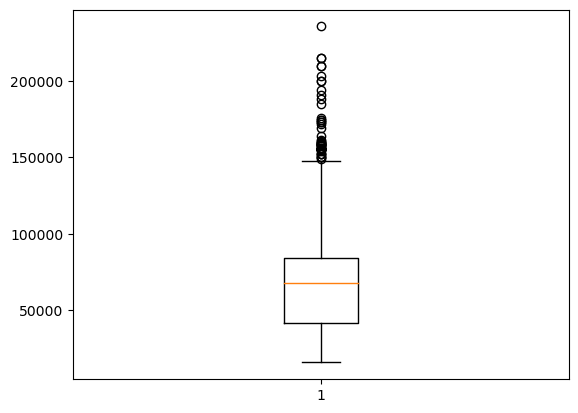

In [498]:
plt.boxplot(clear_price)
plt.show()

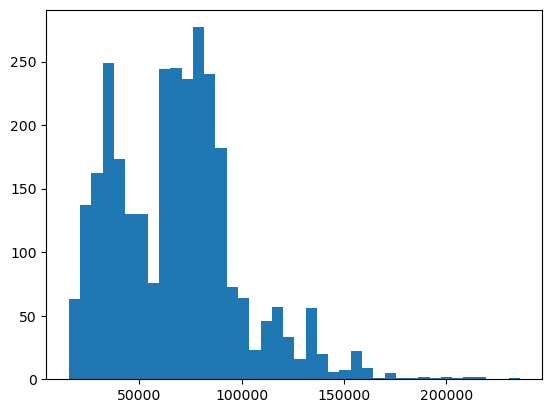

In [499]:
plt.hist(clear_price, bins = 40)
plt.show()

Гистограмма и боксплот показывают, на достаточно большой размах в данных, что подтверждается показателями описательной статистики (min и max). Ограничим графический анализ 5 процентилем снизу и 95 процентилем сверху, тем самым обработаем часть выбросов, и заново построим ящик с усами и гистограмму

In [500]:
clear_price_2 = dataset[
    (dataset['clear_price']>=percentile_5_value)&
    (dataset['clear_price']<=percentile_95_value)]['clear_price']

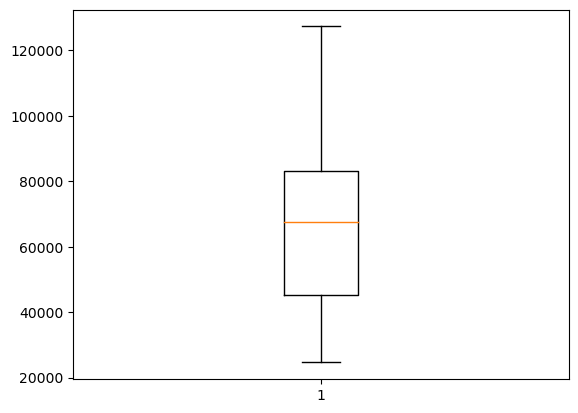

In [501]:
plt.boxplot(clear_price_2)
plt.show()

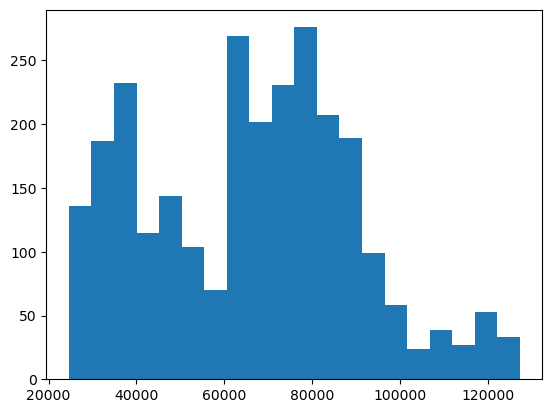

In [502]:
plt.hist(clear_price_2, bins = 20)
plt.show()

Ограничив целевой признак clear_price 5 процентилем снизу и 95 процентилем сверху мы избавились от большого числа выбросов, дальнейший анализ считаю необходимо проводить именно с данными ограничениями по цене

In [503]:
dataset = dataset[dataset['clear_price'] > 24630] 
dataset = dataset[dataset['clear_price'] < 127500] 

In [504]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2695 entries, 0 to 2989
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         2695 non-null   int64  
 1   clear_title        2695 non-null   object 
 2   clear_price        2695 non-null   int64  
 3   type_PC            2695 non-null   object 
 4   OS                 2695 non-null   object 
 5   type_proc          2695 non-null   object 
 6   core_count         2695 non-null   int64  
 7   type_ram           2695 non-null   object 
 8   vol_ram            2695 non-null   int64  
 9   hdd_vol            2695 non-null   int64  
 10  ssd_vol            2695 non-null   int64  
 11  videocard          2695 non-null   object 
 12  seller             2695 non-null   object 
 13  seller_rating      2695 non-null   float64
 14  clear_sales        2695 non-null   int64  
 15  clear_feedbacks    2695 non-null   int64  
 16  clear_garanty      2695 

Графический анализ показывает, что условно все ПК можно разделить на 3 основные ценовые категории:

    1. ПК стоимостью до 60 тыс.руб.
    2. ПК стоимостью от 60 до 90 тыс.руб.
    3. ПК стоимостью свыше 90 тыс.руб.
При этом наиболее распространенными являются ПК 2 ценовой категории

## 2.2 Признак type_PC

In [505]:
dataset['type_PC'].describe()

count        2695
unique          2
top       game_PC
freq         2186
Name: type_PC, dtype: object

In [506]:
type_PC_counts = dataset['type_PC'].value_counts()

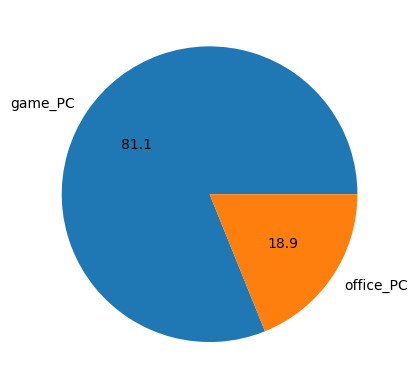

In [507]:
plt.pie(type_PC_counts, labels = type_PC_counts.index, autopct='%.1f')
plt.show()

In [508]:
dataset.groupby('type_PC')['clear_price'].median()

type_PC
game_PC      73224.0
office_PC    35052.0
Name: clear_price, dtype: float64

In [509]:
dataset.groupby('type_PC')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
type_PC,,,,,,,,
game_PC,2186.0,72403.210887,21322.071200,24710.0,60681.0,73224.0,85482.0,127274.0
office_PC,509.0,39671.180747,14189.085392,24635.0,29866.0,35052.0,43469.0,82130.0


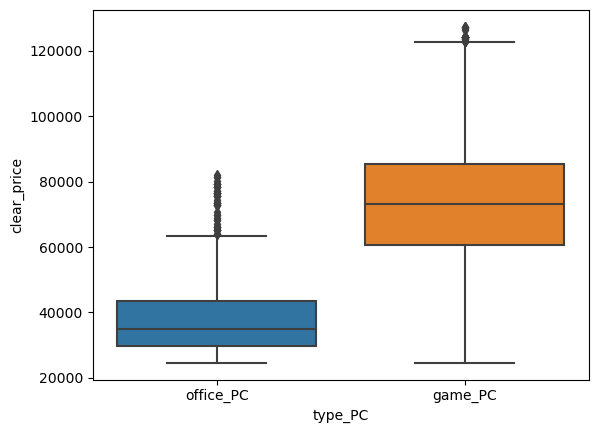

In [510]:
sns.boxplot(x = 'type_PC', y = 'clear_price', data = dataset)
plt.show()

### Выводы:
1. Игровые ПК наиболее распространенный тип, 81,1%
2. Наблюдаятся ярковыраженная связь между ценой и типом ПК, игровые ПК гораздо дороже
3. Основной ценовой диапазон игровых ПК 60 000 - 90 000 руб, офисных 25 000 - 45 000 руб.
4. В категории офисных ПК наблюдаются выбросы(цена более 60 000)

## 2.3 Признак OS

In [511]:
dataset['OS'].describe()

count               2695
unique                 5
top       windows 10 pro
freq                1511
Name: OS, dtype: object

In [512]:
dataset['OS'].value_counts()

windows 10 pro    1511
windows 11 pro     567
без oc             348
windows 10         268
windows 11           1
Name: OS, dtype: int64

In [513]:
dataset = dataset[dataset['OS'] != 'windows 11']

In [514]:
OS_counts = dataset['OS'].value_counts()

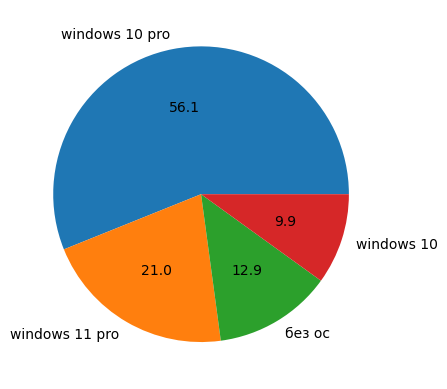

In [515]:
plt.pie(OS_counts, labels = OS_counts.index, autopct='%.1f')
plt.show()

In [516]:
dataset.groupby('OS')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
OS,,,,,,,,
windows 10,268.0,50375.492537,23090.050293,24635.0,29210.5,43840.0,67942.0,111880.0
windows 10 pro,1511.0,68069.077432,23994.253705,24710.0,47997.5,68804.0,85482.0,127274.0
windows 11 pro,567.0,75033.414462,19289.020163,31000.0,64071.0,77167.0,84392.0,124065.0
без oc,348.0,55883.821839,21403.955250,24998.0,35569.0,55625.0,72050.0,117923.0


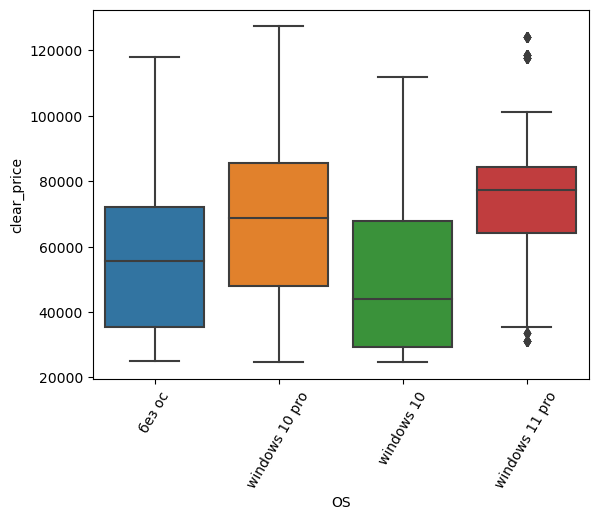

In [517]:
sns.boxplot(x = 'OS', y = 'clear_price', data = dataset)
plt.xticks(rotation=60)
plt.show()

Добавим в словарь наименование ОС и количество ПК для итоговой таблицы

In [518]:
OS_list = dataset['OS'].value_counts().index
OS_list

Index(['windows 10 pro', 'windows 11 pro', 'без oc', 'windows 10'], dtype='object')

In [519]:
OS_dict = []
for OS in OS_list:
    dt = dataset[dataset['OS']==OS]
    count_PC = dt['OS'].count()
    OS_dict.append({
        'Операционная система' : OS,
        'Количество ПК' : count_PC
        })
OS_top = pd.DataFrame.from_dict(OS_dict, orient='columns')
OS_top = OS_top.rename(index = lambda x: x + 1)

### Выводы:
1. Наиболее распространенные операционные системы Windows 10 pro и windows 11 pro, при этом у этих систем наблюдается не большая разница между средним и медианным значениями цены
2. Медиана показывает что Windows 10 pro и windows 11 pro характерны для более дорогих ПК, чем ПК с Windows 10 или без ОС
3. Зависимость цены от операционной системы есть, но она слабая, что вероятнее всего объясняется огромным количеством вариантов сборки ПК и установленной операционной системой

## 2.4 Признаки core_count и vol_ram

In [520]:
dataset['core_count'].value_counts()

6     1266
4      535
8      345
12     202
2      184
10      87
24      60
16      14
14       1
Name: core_count, dtype: int64

In [521]:
dataset = dataset[dataset['core_count'] != 14]

In [522]:
core_count_counts = dataset['core_count'].value_counts().sort_values(ascending=True)

In [523]:
core_count_top_5 = dataset['core_count'].value_counts()[:5]

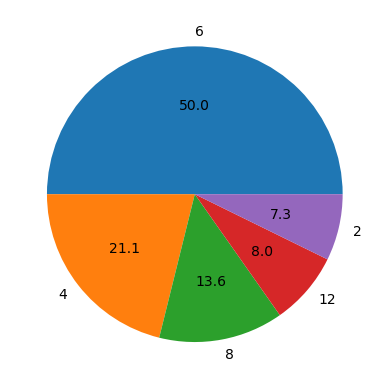

In [524]:
plt.pie(core_count_top_5, labels = core_count_top_5.index, autopct='%.1f')
plt.show()

In [525]:
dataset['vol_ram'].value_counts()

16    1756
32     525
8      365
4       29
64      18
Name: vol_ram, dtype: int64

In [526]:
vol_ram_counts = dataset['vol_ram'].value_counts().sort_values(ascending=True)

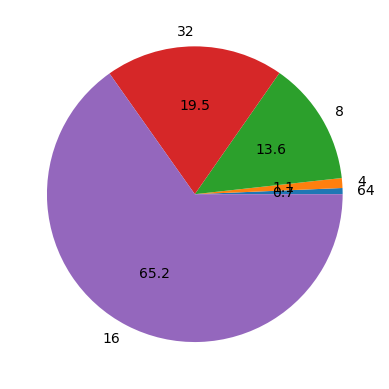

In [527]:
plt.pie(vol_ram_counts, labels = vol_ram_counts.index, autopct='%.1f')
plt.show()

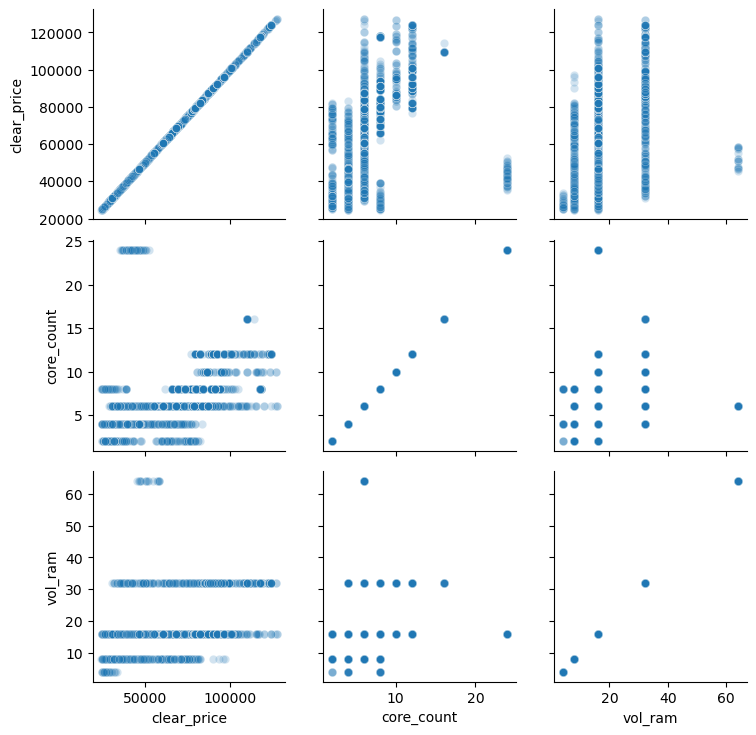

In [528]:
columns = ['clear_price', 'core_count', 'vol_ram']
g = sns.PairGrid(dataset[columns])
g.map(sns.scatterplot, alpha=0.2)

Добавим в словарь количество ядер и объем оперативной памяти для итоговой таблицы

In [529]:
core_count_list = dataset['core_count'].value_counts()[:5].index
core_count_list

Int64Index([6, 4, 8, 12, 2], dtype='int64')

In [530]:
core_count_dict = []
for core_count in core_count_list:
    dt = dataset[dataset['core_count']==core_count]
    count_PC = dt.core_count.count()
    core_count_dict.append({
        'Количество ядер' : core_count,
        'Количество ПК' : count_PC
        })
core_count_top = pd.DataFrame.from_dict(core_count_dict, orient='columns')
core_count_top = core_count_top.rename(index = lambda x: x + 1)

In [531]:
vol_ram_list = dataset['vol_ram'].value_counts()[:5].index
vol_ram_list

Int64Index([16, 32, 8, 4, 64], dtype='int64')

In [532]:
vol_ram_dict = []
for vol_ram in vol_ram_list:
    dt = dataset[dataset['vol_ram']==vol_ram]
    count_PC = dt.vol_ram.count()
    vol_ram_dict.append({
        'Объем оперативной памяти' : vol_ram,
        'Количество ПК' : count_PC
        })
vol_ram_top = pd.DataFrame.from_dict(vol_ram_dict, orient='columns')
vol_ram_top = vol_ram_top.rename(index = lambda x: x + 1)

### Выводы:
1. Наиболее распространенные ПК с объемом оперативной памяти 16, 32 и 8Гб и количеством ядер процессора 6, 4 и 8
2. Присутствует связь между признаками core_count, vol_ram и clear_price
3. Есть ограниченные закономерности между этими признаками:

    3.1 ПК с количеством ядер 4 и менее находятся в ценовом диапазоне до 80 т.р.
    
    3.2 ПК с объемом оперативной памяти менее 10 ГБ находятся в ценовом диапазоне до 80 т.р.

## 2.5 Признак type_ram

In [533]:
dataset['type_ram'].describe()

count      2693
unique        3
top       DDR 4
freq       2549
Name: type_ram, dtype: object

In [534]:
dataset['type_ram'].value_counts()

DDR 4    2549
DDR 3     142
DDR 5       2
Name: type_ram, dtype: int64

In [535]:
dataset = dataset[dataset['type_ram'] != 'DDR 5']

In [536]:
type_ram_counts = dataset['type_ram'].value_counts()

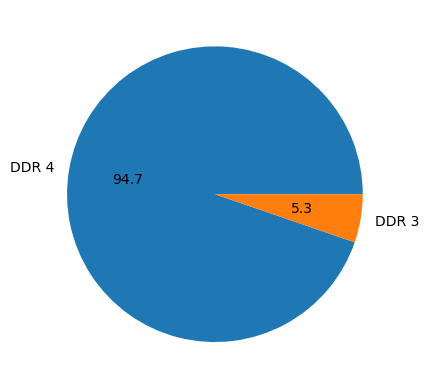

In [537]:
plt.pie(type_ram_counts, labels = type_ram_counts.index, autopct='%.1f')
plt.show()

In [538]:
dataset.groupby('type_ram')['clear_price'].median()

type_ram
DDR 3    28863.0
DDR 4    69520.0
Name: clear_price, dtype: float64

In [539]:
dataset.groupby('type_ram')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
type_ram,,,,,,,,
DDR 3,142.0,34399.063380,13173.754013,24635.0,26509.5,28863.0,33416.5,77600.0
DDR 4,2549.0,67908.927815,23024.120634,24998.0,48276.0,69520.0,83404.0,127274.0


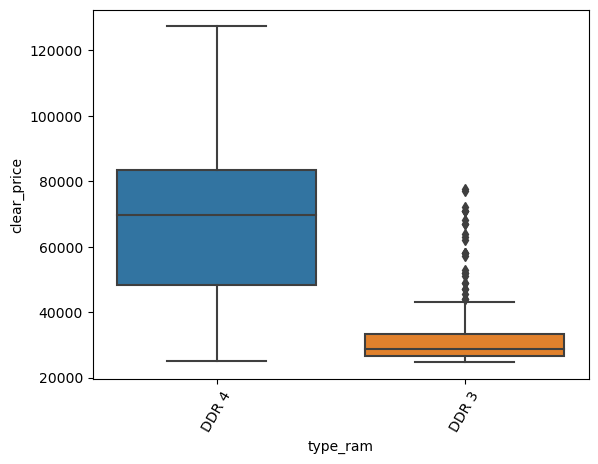

In [540]:
sns.boxplot(x = 'type_ram', y = 'clear_price', data = dataset)
plt.xticks(rotation=60)
plt.show()

### Выводы:

1. Наиболее распространенное поколение оперативной памяти DDR4 
2. Наблюдается ярко выраженная зависимость между признаками
3. Характерно следующее:

    3.1 Поколение DDR3 соответствует наиболее дешевым ПК с ценой до 45 000 (поколение DDR3 на сегодняшний день является морально устаревшим)


## 2.6 Признак type_proc

In [541]:
dataset['type_proc'].value_counts()

intel core i5    920
intel core i7    526
intel core i3    468
amd ryzen 5      457
amd athlon       115
amd ryzen 7       62
intel xeon        60
amd ryzen 3       45
intel pentium     26
amd a6            10
intel core i9      2
Name: type_proc, dtype: int64

In [542]:
dataset = dataset[dataset['type_proc'] != 'intel core i9']

In [543]:
type_proc_counts = dataset['type_proc'].value_counts().sort_values(ascending=True)

In [544]:
type_proc_counts_top_10 = dataset['type_proc'].value_counts()[:10]
type_proc_counts_top_5 = dataset['type_proc'].value_counts()[:5]

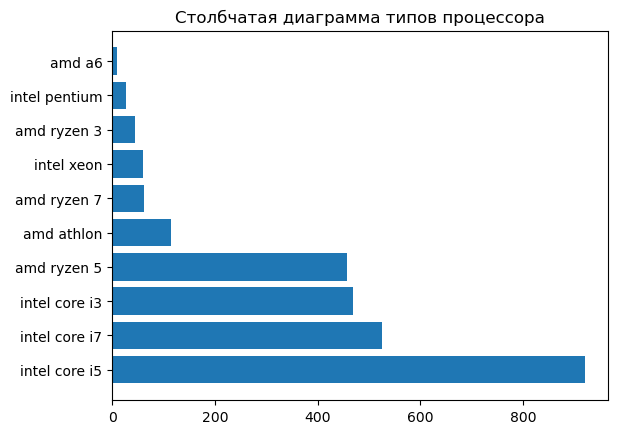

In [545]:
plt.barh(type_proc_counts_top_10.index, type_proc_counts_top_10.values)
plt.title('Столбчатая диаграмма типов процессора')
plt.show()

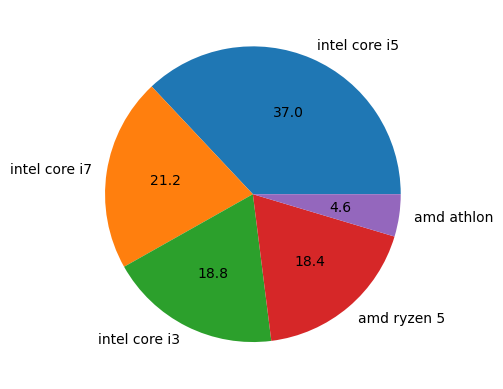

In [546]:
plt.pie(type_proc_counts_top_5, labels = type_proc_counts_top_5.index, autopct='%.1f')
plt.show()

In [547]:
type_proc_list = dataset['type_proc'].value_counts()[:10].index
type_proc_list

Index(['intel core i5', 'intel core i7', 'intel core i3', 'amd ryzen 5',
       'amd athlon', 'amd ryzen 7', 'intel xeon', 'amd ryzen 3',
       'intel pentium', 'amd a6'],
      dtype='object')

In [548]:
type_proc_counts_top_10 = dataset[dataset['type_proc'].isin(type_proc_list)]
type_proc_counts_top_10.shape

(2689, 20)

In [549]:
type_proc_counts_top_10.groupby('type_proc')['clear_price'].median()

type_proc
amd a6           26316.5
amd athlon       33364.0
amd ryzen 3      49750.0
amd ryzen 5      62625.0
amd ryzen 7      90580.0
intel core i3    49220.0
intel core i5    72806.0
intel core i7    88880.0
intel pentium    37042.5
intel xeon       43093.5
Name: clear_price, dtype: float64

In [550]:
type_proc_counts_top_10.groupby('type_proc')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
type_proc,,,,,,,,
amd a6,10.0,27091.300000,2035.016683,25153.0,25733.0,26316.5,28600.00,30243.0
amd athlon,115.0,35980.226087,7206.255482,24998.0,29789.0,33364.0,40040.00,48000.0
amd ryzen 3,45.0,50040.977778,10619.625193,28053.0,44379.0,49750.0,55270.00,69703.0
amd ryzen 5,457.0,59467.851204,20076.056360,29354.0,37979.0,62625.0,74872.00,115000.0
amd ryzen 7,62.0,95696.903226,13313.565891,69544.0,84232.0,90580.0,99330.00,118243.0
intel core i3,468.0,50507.482906,15657.893924,24786.0,35807.5,49220.0,64000.00,83424.0
intel core i5,920.0,71235.001087,17472.729759,24710.0,62656.0,72806.0,82385.00,126925.0
intel core i7,526.0,86113.114068,24255.749872,24635.0,77264.0,88880.0,101160.00,127274.0
intel pentium,26.0,34961.230769,4826.857357,25775.0,32544.0,37042.5,38508.75,41585.0


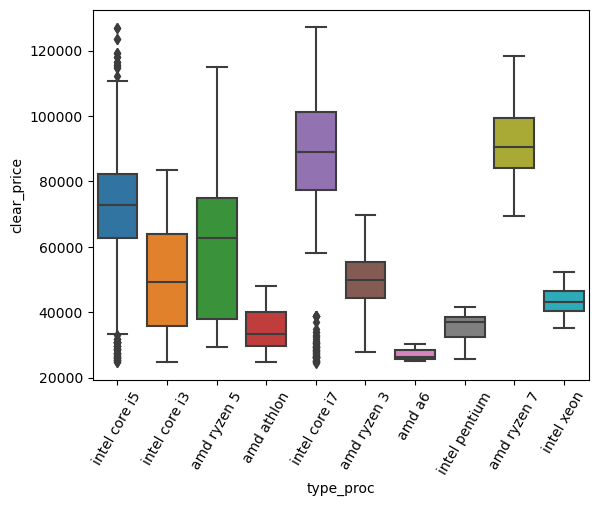

In [551]:
sns.boxplot(x = 'type_proc', y = 'clear_price', data = type_proc_counts_top_10)
plt.xticks(rotation=60)
plt.show()

Выведем боксплот для самых распространенный процессоров

In [552]:
type_proc_list_2 = dataset['type_proc'].value_counts()[:5].index
type_proc_list_2

Index(['intel core i5', 'intel core i7', 'intel core i3', 'amd ryzen 5',
       'amd athlon'],
      dtype='object')

In [553]:
type_proc_counts_top_5 = dataset[dataset['type_proc'].isin(type_proc_list_2)]
type_proc_counts_top_5.shape

(2486, 20)

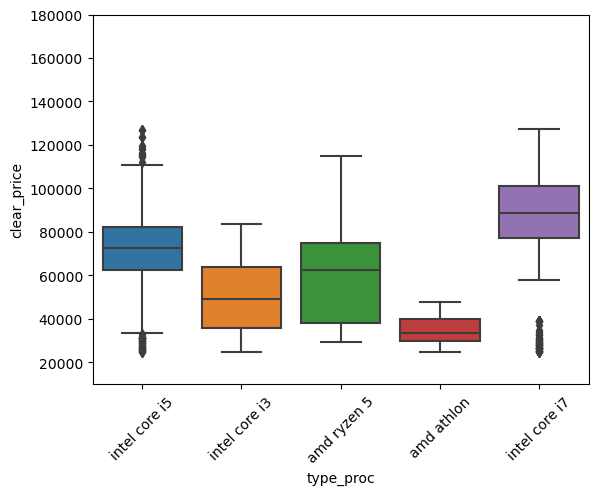

In [554]:
sns.boxplot(x = 'type_proc', y = 'clear_price', data = type_proc_counts_top_5)
plt.axis(ymin = 10000, ymax = 180000)
plt.xticks(rotation=45)
plt.show()

Добавим топ 5 процессоров в словарь для итоговой таблицы

In [555]:
type_proc_dict = []
for type_proc in type_proc_list_2:
    dt = dataset[dataset['type_proc']==type_proc]
    count_PC = dt.type_proc.count()
    type_proc_dict.append({
        'Процессор' : type_proc,
        'Количество ПК' : count_PC
        })
type_proc_top = pd.DataFrame.from_dict(type_proc_dict, orient='columns')
type_proc_top = type_proc_top.rename(index = lambda x: x + 1)

### Выводы:
1. Наиболее распространенными процессорами являются: intel core i5, intel core i7, intel core i3, amd ryzen 5 и amd athlon
2. Процессоры линейки intel core i7 и amd ryzen 7 характерны для более дорогих ПК, с ценой более 80 000 руб.
3. Процессоры линейки amd ryzen 3 и intel core i3 характерны для ценовой категории до 60 000 руб
4. Процессоры линейки intel core i5 характерны для ценовой категории от 60 000 до 80 000 руб
5. Все это говорит нам о том, что присутствует зависимость цены ПК от установленного процессора
6. У рассмотренных процессоров заметна небольшая разница между средним значением цены и медианой

## 2.7 Признак videocard

In [556]:
dataset['videocard'].describe()

count                        2689
unique                         26
top       nvidia geforce rtx 3060
freq                          569
Name: videocard, dtype: object

In [557]:
videocard_top_10 = dataset['videocard'].value_counts()[:10]
videocard_top_5 = dataset['videocard'].value_counts()[:5]

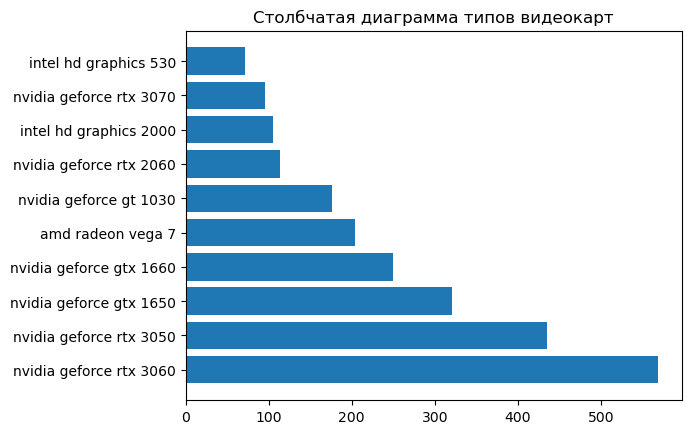

In [558]:
plt.barh(videocard_top_10.index, videocard_top_10.values)
plt.title('Столбчатая диаграмма типов видеокарт')
plt.show()

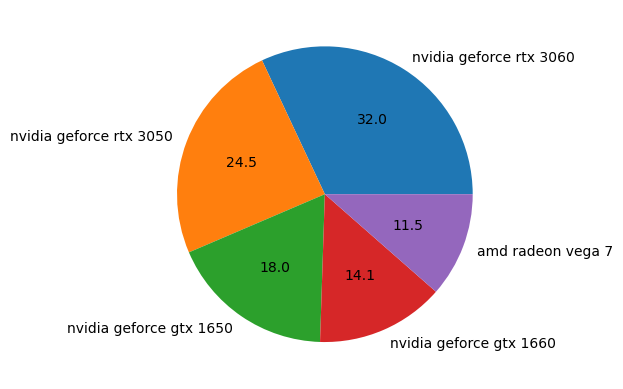

In [559]:
plt.pie(videocard_top_5, labels = videocard_top_5.index, autopct='%.1f')
plt.show()

In [560]:
videocard_list = dataset['videocard'].value_counts()[:10].index
videocard_list

Index(['nvidia geforce rtx 3060', 'nvidia geforce rtx 3050',
       'nvidia geforce gtx 1650', 'nvidia geforce gtx 1660',
       'amd radeon vega 7', 'nvidia geforce gt 1030',
       'nvidia geforce rtx 2060', 'intel hd graphics 2000',
       'nvidia geforce rtx 3070', 'intel hd graphics 530'],
      dtype='object')

In [561]:
videocard_counts_top_10 = dataset[dataset['videocard'].isin(videocard_list)]
videocard_counts_top_10.shape

(2340, 20)

In [562]:
videocard_counts_top_10.groupby('videocard')['clear_price'].median()

videocard
amd radeon vega 7           37100.0
intel hd graphics 2000      27551.0
intel hd graphics 530       69360.0
nvidia geforce gt 1030      36525.0
nvidia geforce gtx 1650     60748.0
nvidia geforce gtx 1660     66825.0
nvidia geforce rtx 2060     74626.0
nvidia geforce rtx 3050     75040.0
nvidia geforce rtx 3060     87880.0
nvidia geforce rtx 3070    118243.0
Name: clear_price, dtype: float64

In [563]:
videocard_counts_top_10.groupby('videocard')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
videocard,,,,,,,,
amd radeon vega 7,204.0,39686.926471,6913.412631,29354.0,35052.0,37100.0,43147.25,61079.0
intel hd graphics 2000,105.0,28283.695238,2677.492107,24635.0,26292.0,27551.0,29712.00,37121.0
intel hd graphics 530,72.0,69518.333333,7359.832553,56590.0,63177.5,69360.0,76352.50,82130.0
nvidia geforce gt 1030,176.0,37855.744318,7684.707632,25500.0,33943.0,36525.0,39469.00,87566.0
nvidia geforce gtx 1650,321.0,59253.732087,10067.793438,34900.0,51110.0,60748.0,65630.00,87112.0
nvidia geforce gtx 1660,250.0,66453.752000,9386.830128,41222.0,62625.0,66825.0,70400.00,88144.0
nvidia geforce rtx 2060,113.0,75069.672566,7064.055102,59674.0,71007.0,74626.0,77571.00,90153.0
nvidia geforce rtx 3050,435.0,77382.703448,9175.670736,58000.0,72616.5,75040.0,83141.50,110184.0
nvidia geforce rtx 3060,569.0,89846.209139,10701.951496,59900.0,83120.0,87880.0,94920.00,122490.0


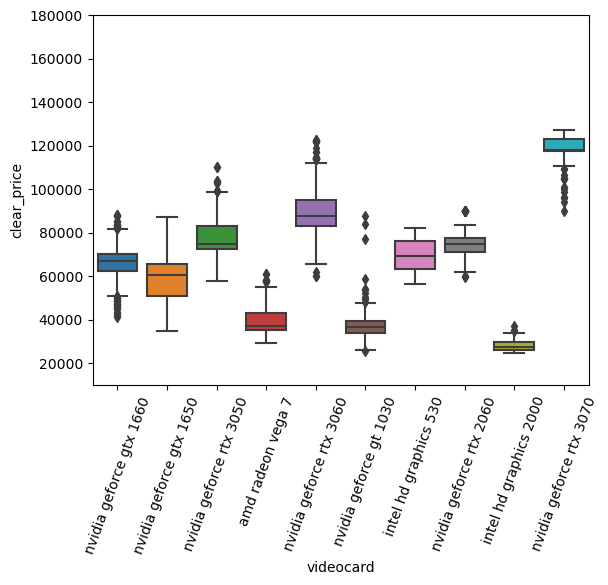

In [564]:
sns.boxplot(x = 'videocard', y = 'clear_price', data = videocard_counts_top_10)
plt.axis(ymin = 10000, ymax = 180000)
plt.xticks(rotation=70)
plt.show()

Добавим топ 5 видеокарт в словарь для итоговой таблицы

In [565]:
videocard_list = dataset['videocard'].value_counts()[:5].index
videocard_list

Index(['nvidia geforce rtx 3060', 'nvidia geforce rtx 3050',
       'nvidia geforce gtx 1650', 'nvidia geforce gtx 1660',
       'amd radeon vega 7'],
      dtype='object')

In [566]:
videocard_dict = []
for videocard in videocard_list:
    dt = dataset[dataset['videocard']==videocard]
    count_PC = dt.videocard.count()
    videocard_dict.append({
        'Видеокарта' : videocard,
        'Количество ПК' : count_PC
        })
videocard_top = pd.DataFrame.from_dict(videocard_dict, orient='columns')
videocard_top = videocard_top.rename(index = lambda x: x + 1)

### Выводы:
1. Наиболее распространенными видеокартами являются: nvidia geforce rtx 3060, nvidia geforce rtx 3050, nvidia geforce gtx 1650,   nvidia geforce gtx 1660, intel hd graphics 2000
2. Видеокарта nvidia geforce rtx 3070 характерна для более дорогих ПК, с ценой более 120 000 руб.
3. Видеокарта intel hd graphics 2000(встроенная) характерна для самых дешевый ПК с ценой до 30 000 руб
4. Все это говорит нам о том, что присутствует зависимость цены ПК от установленной видеокарты
5. У рассмотренных видеокарт заметна небольшая разница между средним значением цены и медианой

## 2.8 Признаки  hdd_vol и ssd_vol

In [567]:
dataset['hdd_vol'].value_counts()

0       1814
1000     820
500       44
2000       9
3000       1
4000       1
Name: hdd_vol, dtype: int64

In [568]:
dataset = dataset[dataset['hdd_vol'] < 2100]

In [569]:
hdd_vol_counts = dataset['hdd_vol'].value_counts().sort_values(ascending=True)

In [570]:
hdd_vol_top_4 = dataset['hdd_vol'].value_counts()[:4]

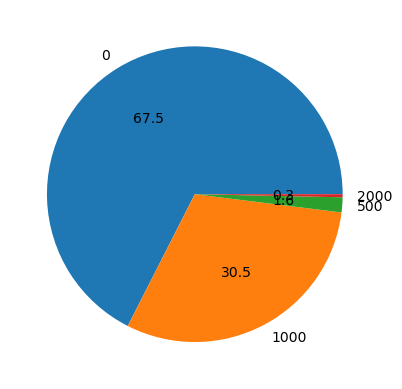

In [571]:
plt.pie(hdd_vol_top_4, labels = hdd_vol_top_4.index, autopct='%.1f')
plt.show()

In [572]:
hdd_vol_list = dataset['hdd_vol'].value_counts().index
hdd_vol_list

Int64Index([0, 1000, 500, 2000], dtype='int64')

In [573]:
hdd_vol_counts = dataset[dataset['hdd_vol'].isin(hdd_vol_list)]
hdd_vol_counts.shape

(2687, 20)

In [574]:
hdd_vol_counts.groupby('hdd_vol')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
hdd_vol,,,,,,,,
0,1814.0,62598.239802,23104.721833,24635.0,39662.0,64368.0,78741.0,127274.0
500,44.0,38946.272727,17133.139557,24786.0,26471.0,29403.5,54000.0,79539.0
1000,820.0,74787.286585,22158.531605,24936.0,61264.0,76090.5,88628.0,126306.0
2000,9.0,106784.888889,22380.589131,49900.0,104840.0,114180.0,118990.0,122457.0


In [575]:
dataset['ssd_vol'].value_counts()

500     1522
1000     756
250      270
120       99
2000      16
0         10
1500       8
1240       6
Name: ssd_vol, dtype: int64

In [576]:
ssd_vol_counts = dataset['ssd_vol'].value_counts().sort_values(ascending=True)

In [577]:
ssd_vol_top_5 = dataset['ssd_vol'].value_counts()[:4]

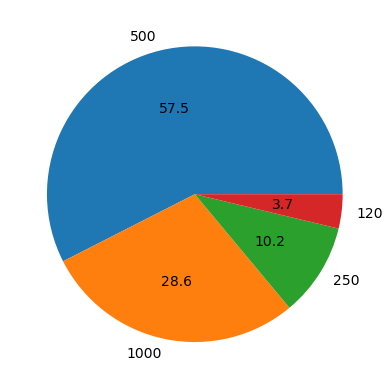

In [578]:
plt.pie(ssd_vol_top_5, labels = ssd_vol_top_5.index, autopct='%.1f')
plt.show()

In [579]:
ssd_vol_list = dataset['ssd_vol'].value_counts().index
ssd_vol_list

Int64Index([500, 1000, 250, 120, 2000, 0, 1500, 1240], dtype='int64')

In [580]:
ssd_vol_counts = dataset[dataset['ssd_vol'].isin(ssd_vol_list)]
ssd_vol_counts.shape

(2687, 20)

In [581]:
ssd_vol_counts.groupby('ssd_vol')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
ssd_vol,,,,,,,,
0,10.0,27455.800000,1713.175272,25236.0,26488.50,27088.0,28516.00,30947.0
120,99.0,42582.686869,12209.956290,24927.0,30870.00,44217.0,49882.50,65103.0
250,270.0,49535.496296,17345.819286,24710.0,32189.00,48400.0,63531.25,103671.0
500,1522.0,63960.651117,24192.671413,24635.0,40040.00,64881.0,82987.00,127274.0
1000,756.0,78641.974868,17418.749920,34104.0,69079.00,77571.0,88110.00,126925.0
1240,6.0,74532.166667,9468.415462,65512.0,66746.25,71980.5,82956.00,86104.0
1500,8.0,99838.750000,7961.019223,89900.0,92656.00,98663.0,108136.00,109900.0
2000,16.0,102581.687500,10995.818240,85096.0,99156.00,99156.0,111285.25,118990.0


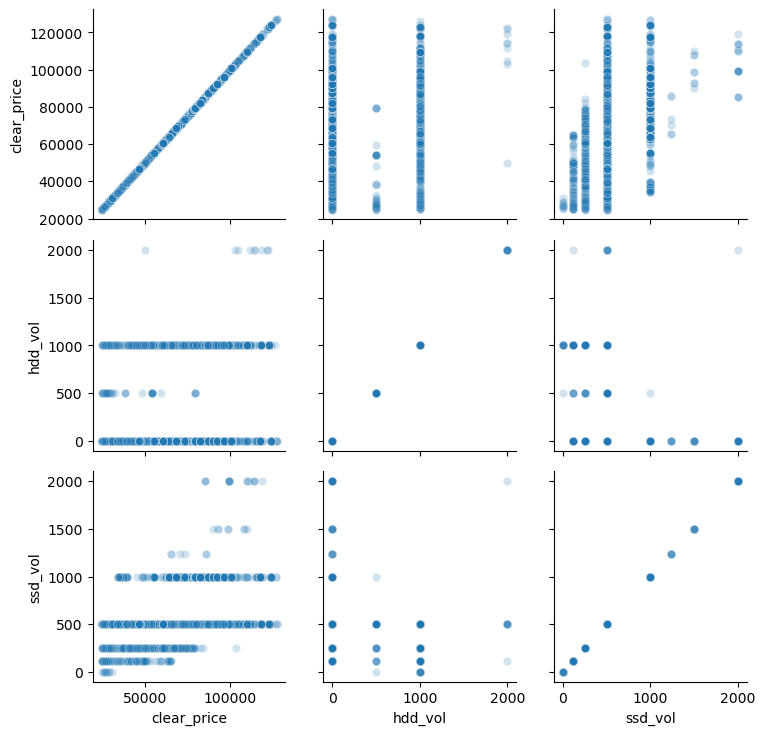

In [582]:
columns = ['clear_price', 'hdd_vol', 'ssd_vol']
f = sns.PairGrid(dataset[columns])
f.map(sns.scatterplot, alpha=0.2)

Добавим объем hdd и ssd в словарь для итоговой таблица

In [583]:
hdd_list = dataset['hdd_vol'].value_counts()[:5].index
hdd_vol_list

Int64Index([0, 1000, 500, 2000], dtype='int64')

In [584]:
hdd_vol_dict = []
for hdd_vol in hdd_vol_list:
    dt = dataset[dataset['hdd_vol']==hdd_vol]
    count_PC = dt.hdd_vol.count()
    hdd_vol_dict.append({
        'Объем hdd' : hdd_vol,
        'Количество ПК' : count_PC
        })
hdd_vol_top = pd.DataFrame.from_dict(hdd_vol_dict, orient='columns')
hdd_vol_top = hdd_vol_top.rename(index = lambda x: x + 1)

In [585]:
hdd_vol_top

,Объем hdd,Количество ПК
1,0,1814
2,1000,820
3,500,44
4,2000,9


In [586]:
ssd_list = dataset['ssd_vol'].value_counts()[:5].index
ssd_list

Int64Index([500, 1000, 250, 120, 2000], dtype='int64')

In [587]:
ssd_vol_dict = []
for ssd_vol in ssd_list:
    dt = dataset[dataset['ssd_vol']==ssd_vol]
    count_PC = dt.ssd_vol.count()
    ssd_vol_dict.append({
        'Объем ssd' : ssd_vol,
        'Количество ПК' : count_PC
        })
ssd_vol_top = pd.DataFrame.from_dict(ssd_vol_dict, orient='columns')
ssd_vol_top = ssd_vol_top.rename(index = lambda x: x + 1)

In [588]:
popular_accessories = pd.concat([type_proc_top, core_count_top, videocard_top, vol_ram_top, OS_top, hdd_vol_top, ssd_vol_top], axis=1)
popular_accessories

,Процессор,Количество ПК,Количество ядер,Количество ПК,Видеокарта,Количество ПК,Объем оперативной памяти,Количество ПК,Операционная система,Количество ПК,Объем hdd,Количество ПК,Объем ssd,Количество ПК
1,intel core i5,920,6,1266,nvidia geforce rtx 3060,569,16,1756,windows 10 pro,1511.0,0.0,1814.0,500,1522
2,intel core i7,526,4,535,nvidia geforce rtx 3050,435,32,525,windows 11 pro,567.0,1000.0,820.0,1000,756
3,intel core i3,468,8,345,nvidia geforce gtx 1650,321,8,365,без oc,348.0,500.0,44.0,250,270
4,amd ryzen 5,457,12,202,nvidia geforce gtx 1660,250,4,29,windows 10,268.0,2000.0,9.0,120,99
5,amd athlon,115,2,184,amd radeon vega 7,204,64,18,NaN,NaN,NaN,NaN,2000,16


### Выводы:
1. Наиболее распространенными типами накопителей является ssd объемом 500Гб и 1000Гб, а также hdd объемом 1000Гб.
2. У накопителей ssd объемом 500Гб и hdd объемом 1000Гб заметна небольшая разница между средним значением и медианой
3. Наблюдается взаимосвязь цены и объема накопителей

## 2.9 Признак seller  

In [589]:
dataset['seller'].describe()

count          2687
unique           17
top       Robotcomp
freq            605
Name: seller, dtype: object

In [590]:
seller_top_10 = dataset['seller'].value_counts()[:10]
seller_top_5 = dataset['seller'].value_counts()[:5]

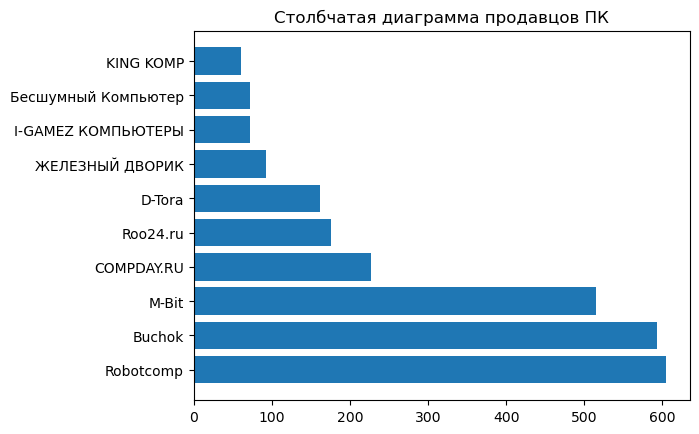

In [591]:
plt.barh(seller_top_10.index, seller_top_10.values)
plt.title('Столбчатая диаграмма продавцов ПК')
plt.show()

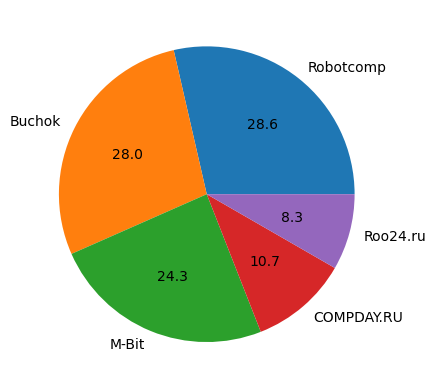

In [592]:
plt.pie(seller_top_5, labels = seller_top_5.index, autopct='%.1f')
plt.show()

In [593]:
seller_list = dataset['seller'].value_counts()[:10].index
seller_list

Index(['Robotcomp', 'Buchok', 'M-Bit', 'COMPDAY.RU', 'Roo24.ru', 'D-Tora',
       'ЖЕЛЕЗНЫЙ ДВОРИК', 'I-GAMEZ КОМПЬЮТЕРЫ', 'Бесшумный Компьютер',
       'KING KOMP'],
      dtype='object')

In [594]:
seller_counts_top_10 = dataset[dataset['seller'].isin(seller_list)]
seller_counts_top_10.shape

(2574, 20)

In [595]:
seller_counts_top_10.groupby('seller')['clear_price'].median()

seller
Buchok                 82987.0
COMPDAY.RU             54925.0
D-Tora                 30638.0
I-GAMEZ КОМПЬЮТЕРЫ     70500.0
KING KOMP              71700.0
M-Bit                  78311.0
Robotcomp              47899.0
Roo24.ru               54016.0
Бесшумный Компьютер    69360.0
ЖЕЛЕЗНЫЙ ДВОРИК        69079.0
Name: clear_price, dtype: float64

In [596]:
seller_counts_top_10.groupby('seller')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
Buchok,593.0,80044.448567,18363.152610,31000.0,66825.0,82987.0,91002.0,122907.0
COMPDAY.RU,227.0,58808.973568,19622.726971,27136.0,41424.0,54925.0,71600.0,121913.0
D-Tora,161.0,33958.385093,8008.592177,24635.0,27088.0,30638.0,41220.0,52459.0
I-GAMEZ КОМПЬЮТЕРЫ,72.0,69948.611111,17858.678350,39000.0,56550.0,70500.0,77700.0,115000.0
KING KOMP,60.0,70573.333333,17985.039608,34500.0,59900.0,71700.0,78600.0,109900.0
M-Bit,515.0,77842.421359,17624.775882,31000.0,69520.0,78311.0,87300.0,124065.0
Robotcomp,605.0,56879.423140,25179.492921,25153.0,35302.0,47899.0,76850.0,126925.0
Roo24.ru,176.0,62628.869318,23161.918073,26999.0,46397.5,54016.0,72456.0,127274.0
Бесшумный Компьютер,72.0,69518.333333,7359.832553,56590.0,63177.5,69360.0,76352.5,82130.0


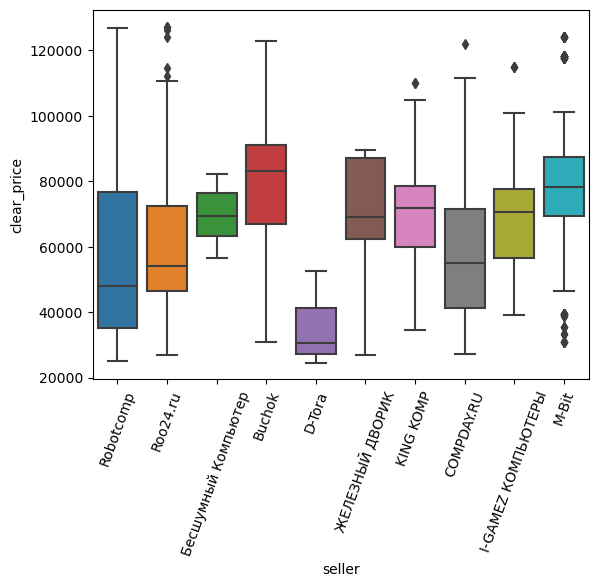

In [597]:
sns.boxplot(x = 'seller', y = 'clear_price', data = seller_counts_top_10)
plt.xticks(rotation=70)
plt.show()

In [598]:
seller_list_2 = dataset['seller'].value_counts()[:5].index
seller_list_2

Index(['Robotcomp', 'Buchok', 'M-Bit', 'COMPDAY.RU', 'Roo24.ru'], dtype='object')

In [599]:
seller_counts_top_5 = dataset[dataset['seller'].isin(seller_list_2)]
seller_counts_top_5.shape

(2116, 20)

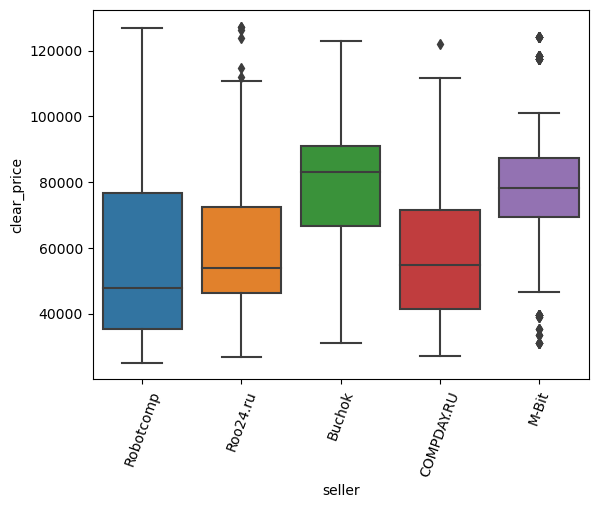

In [600]:
sns.boxplot(x = 'seller', y = 'clear_price', data = seller_counts_top_5)
plt.xticks(rotation=70)
plt.show()

### Выводы:
1. Присутствует взимосвязь признаков price и seller, можно выделить ценовой диапазон, в котором торгует каждый отдельный продавец
2. Самые распространенные продавцы Robotcomp, Buchok и M-Bit

## 2.10 Признак seller_rating

In [601]:
dataset['seller_rating'].value_counts()

4.7    1389
0.0     524
4.2     227
4.1     221
5.0     104
4.8      93
4.9      72
4.5      39
4.3      10
4.4       8
Name: seller_rating, dtype: int64

In [602]:
seller_rating_counts = dataset['seller_rating'].value_counts().sort_values(ascending=True)

In [603]:
seller_rating_top_10 = dataset['seller_rating'].value_counts()[:5]

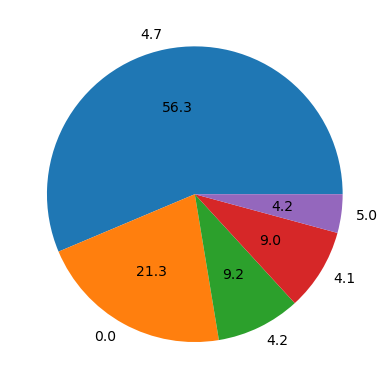

In [604]:
plt.pie(seller_rating_top_10, labels = seller_rating_top_10.index, autopct='%.1f')
plt.show()

In [605]:
seller_rating_list = dataset['seller_rating'].value_counts().index
seller_rating_list

Float64Index([4.7, 0.0, 4.2, 4.1, 5.0, 4.8, 4.9, 4.5, 4.3, 4.4], dtype='float64')

In [606]:
seller_rating_counts = dataset[dataset['seller_rating'].isin(seller_rating_list)]
seller_rating_counts.shape

(2687, 20)

In [607]:
seller_rating_counts.groupby('seller_rating')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
seller_rating,,,,,,,,
0.0,524.0,77198.469466,18228.128312,24710.0,68490.00,77571.0,87300.0,124065.0
4.1,221.0,43899.095023,19993.953225,24635.0,28251.00,38970.0,49900.0,109900.0
4.2,227.0,58808.973568,19622.726971,27136.0,41424.00,54925.0,71600.0,121913.0
4.3,10.0,57054.000000,10881.895464,50660.0,54000.00,54000.0,54000.0,87880.0
4.4,8.0,32441.625000,7199.359454,25500.0,25941.75,31217.0,37857.5,42000.0
4.5,39.0,49835.153846,24111.619891,27989.0,34664.00,41699.0,59759.0,121649.0
4.7,1389.0,67439.832973,24749.246844,25153.0,44905.00,67538.0,85096.0,127274.0
4.8,93.0,67472.483871,18856.478667,26880.0,62414.00,69079.0,87120.0,89424.0
4.9,72.0,69948.611111,17858.678350,39000.0,56550.00,70500.0,77700.0,115000.0


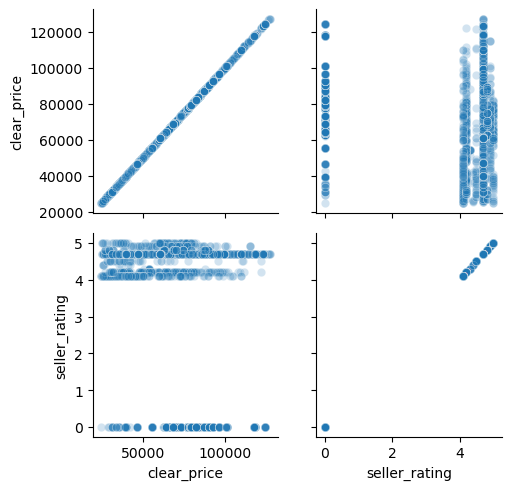

In [608]:
columns = ['clear_price', 'seller_rating']
f = sns.PairGrid(dataset[columns])
f.map(sns.scatterplot, alpha=0.2)

### Выводы:
1. Взаимосвязь между признаками отсутствует
2. Самые распространенные рейтинг продавца 4,7

## 2.11 Признак clear_feedbacks 

In [609]:
dataset['clear_feedbacks'].value_counts()

0      2212
1       162
2        56
4        42
3        34
8        18
5        16
6        12
19       11
7        11
25        8
30        8
13        6
148       5
47        5
78        5
21        5
14        5
12        5
17        4
10        4
15        4
34        4
84        3
11        3
42        3
89        3
18        3
101       3
128       3
54        3
16        3
94        3
9         2
26        2
296       2
189       2
38        2
59        2
29        2
39        1
Name: clear_feedbacks, dtype: int64

In [610]:
clear_feedbacks_counts = dataset['clear_feedbacks'].value_counts().sort_values(ascending=True)

In [611]:
clear_feedbacks_top_5 = dataset['clear_feedbacks'].value_counts()[:5]

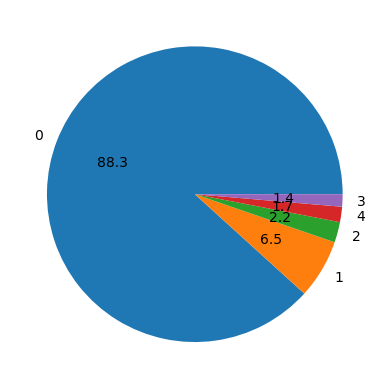

In [612]:
plt.pie(clear_feedbacks_top_5, labels = clear_feedbacks_top_5.index, autopct='%.1f')
plt.show()

In [613]:
clear_feedbacks_list = dataset['clear_feedbacks'].value_counts().index
clear_feedbacks_list

Int64Index([  0,   1,   2,   4,   3,   8,   5,   6,  19,   7,  25,  30,  13,
            148,  47,  78,  21,  14,  12,  17,  10,  15,  34,  84,  11,  42,
             89,  18, 101, 128,  54,  16,  94,   9,  26, 296, 189,  38,  59,
             29,  39],
           dtype='int64')

In [614]:
clear_feedbacks_counts = dataset[dataset['clear_feedbacks'].isin(clear_feedbacks_list)]
clear_feedbacks_counts.shape

(2687, 20)

In [615]:
clear_feedbacks_counts.groupby('clear_feedbacks')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
clear_feedbacks,,,,,,,,
0,2212.0,68385.158228,22977.560855,24635.0,49900.00,71003.5,83638.00,127274.0
1,162.0,58462.512346,27071.224819,24786.0,33892.25,50238.5,79119.50,115000.0
2,56.0,53155.142857,25361.175469,24927.0,34125.00,43675.0,69250.25,126925.0
3,34.0,60777.852941,25914.677676,28053.0,37665.00,54961.0,76061.75,122003.0
4,42.0,58639.785714,22736.511544,25153.0,43366.00,54000.0,76768.75,121649.0
5,16.0,58505.312500,18365.470248,35369.0,45379.75,56911.0,66737.00,96582.0
6,12.0,64774.583333,32142.907631,32146.0,36520.75,56206.5,98470.00,109915.0
7,11.0,45605.545455,15318.388103,35132.0,38263.00,39662.0,40743.00,76363.0
8,18.0,53638.777778,18019.446585,30132.0,35748.00,58566.5,62414.00,85120.0


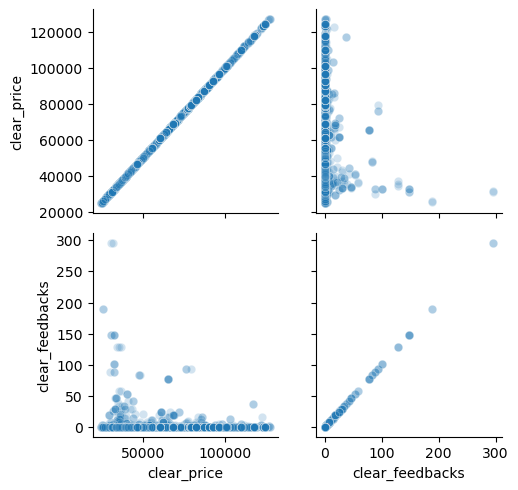

In [616]:
columns = ['clear_price', 'clear_feedbacks']
f = sns.PairGrid(dataset[columns])
f.map(sns.scatterplot, alpha=0.2)

### Выводы:
1. Присутствует слабая взимосвязь между признаками

## 2.12 Признак clear_garanty

In [617]:
dataset['clear_garanty'].value_counts()

3.0    2136
1.0     538
2.0      13
Name: clear_garanty, dtype: int64

In [618]:
clear_garanty_counts = dataset['clear_garanty'].value_counts().sort_values(ascending=True)

In [619]:
clear_garanty = dataset['clear_garanty'].value_counts()

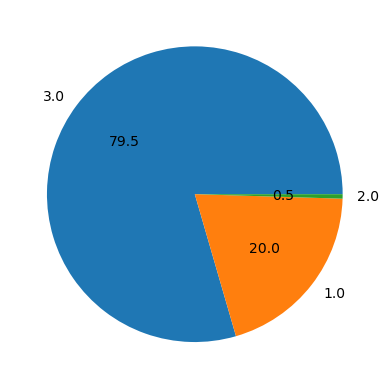

In [620]:
plt.pie(clear_garanty, labels = clear_garanty.index, autopct='%.1f')
plt.show()

In [621]:
clear_garanty_list = dataset['clear_garanty'].value_counts().index
clear_garanty_list

Float64Index([3.0, 1.0, 2.0], dtype='float64')

In [622]:
clear_garanty_counts = dataset[dataset['clear_garanty'].isin(clear_garanty_list)]
clear_garanty_counts.shape

(2687, 20)

In [623]:
clear_garanty_counts.groupby('clear_garanty')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
clear_garanty,,,,,,,,
1.0,538.0,56170.581784,21339.579765,24635.0,35999.0,60750.0,72000.0,115000.0
2.0,13.0,49113.846154,15208.408205,25675.0,43469.0,47655.0,56249.0,80956.0
3.0,2136.0,68677.541667,23705.442882,25153.0,48333.0,71011.5,84392.0,127274.0


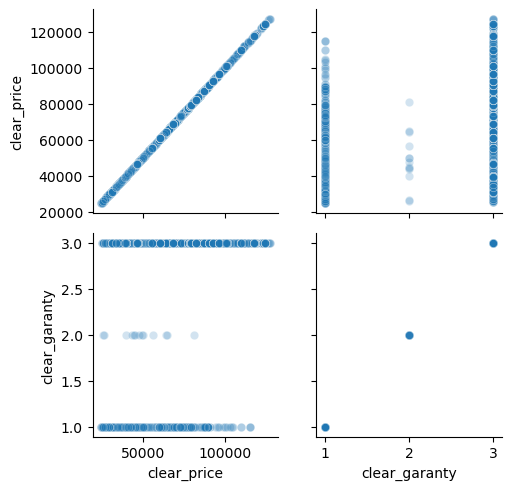

In [624]:
columns = ['clear_price', 'clear_garanty']
f = sns.PairGrid(dataset[columns])
f.map(sns.scatterplot, alpha=0.2)

### Выводы:
1. Наиболее распространенный гарантийный срок 1 и 3 года
2. Присутствует слабая взаимосвязь между признаками

## 2.11 Признак clear_sales

In [625]:
dataset['clear_sales'].value_counts()

5      2532
10       61
20       29
100      15
30       13
40       11
50        8
200       4
80        3
90        3
400       2
500       2
70        2
300       1
60        1
Name: clear_sales, dtype: int64

In [626]:
clear_sales_list = dataset['clear_sales'].value_counts().index
clear_sales_list

Int64Index([5, 10, 20, 100, 30, 40, 50, 200, 80, 90, 400, 500, 70, 300, 60], dtype='int64')

In [627]:
clear_sales_counts = dataset[dataset['clear_sales'].isin(clear_sales_list)]
clear_sales_counts.shape

(2687, 20)

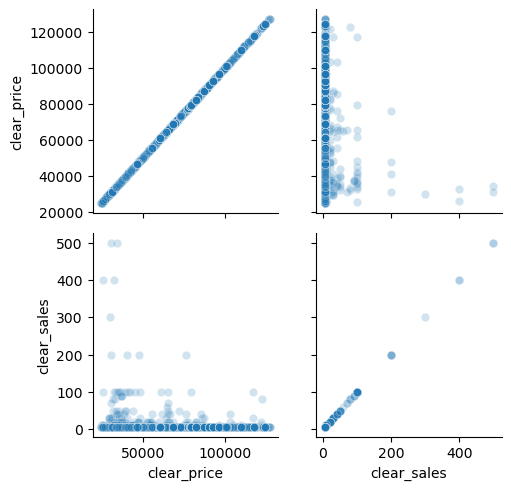

In [628]:
columns = ['clear_price', 'clear_sales']
f = sns.PairGrid(clear_sales_counts[columns])
f.map(sns.scatterplot, alpha=0.2)

### Выводы:
1. Прямой взаимосвязи признаков не выявдено

## 2.12 Признак type_PC и type_proc

In [629]:
PC_types = dataset['type_PC'].unique()
len(PC_types)

2

In [630]:
type_PC = dataset['type_PC'].value_counts().index
type_PC

Index(['game_PC', 'office_PC'], dtype='object')

In [631]:
labels = dataset['type_proc'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'intel core i5': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'intel core i3': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'amd ryzen 5': (1.0, 0.4980392156862745, 0.054901960784313725),
 'amd athlon': (1.0, 0.7333333333333333, 0.47058823529411764),
 'intel core i7': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'amd ryzen 3': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'amd a6': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'intel pentium': (1.0, 0.596078431372549, 0.5882352941176471),
 'amd ryzen 7': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'intel xeon': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}

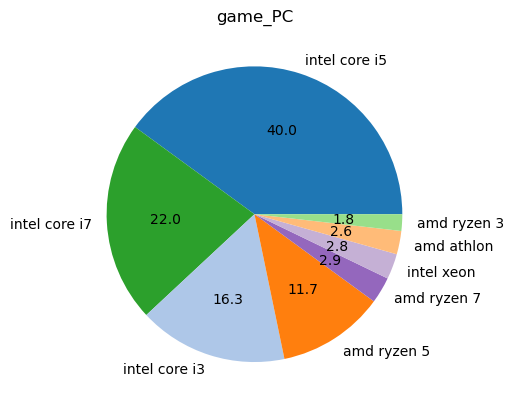

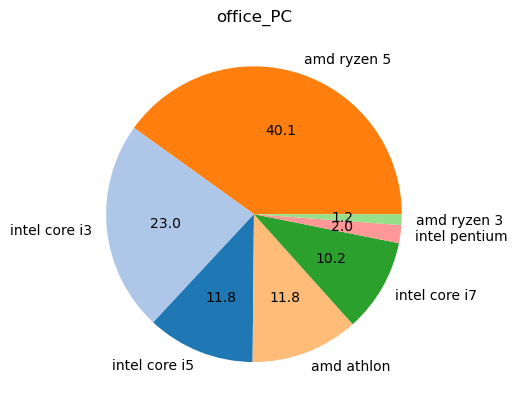

In [632]:
for PC in type_PC:
    df =  dataset[dataset['type_PC']==PC]
    
    type_proc_counts = df['type_proc'].value_counts()[:8]
    labels = type_proc_counts.index

    plt.title(PC)
    plt.pie(type_proc_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
1. Игровым ПК соответствуют процессоры более нового поколения: intel core i5 и intel_core i7
2. Для офисных ПК подавляющее большинство процессоров составляют amd ryzen 5  и intel_core i3

## 2.13 Признак type_PC и type_ram

In [633]:
labels = dataset['type_ram'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'DDR 4': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'DDR 3': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}

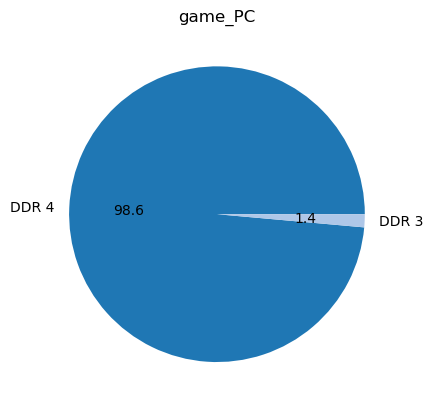

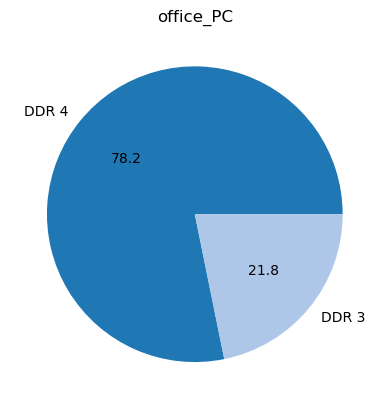

In [634]:
for PC in type_PC:
    df =  dataset[dataset['type_PC']==PC]
    
    type_ram_counts = df['type_ram'].value_counts()
    labels = type_ram_counts.index

    plt.title(PC)
    plt.pie(type_ram_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
1. В игровых ПК применение поколения оперативной памяти DDR 3 практически не применяется

## 2.14 Признак type_PC и seller

In [635]:
labels = seller_counts_top_10['seller'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'Robotcomp': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Roo24.ru': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Бесшумный Компьютер': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Buchok': (1.0, 0.7333333333333333, 0.47058823529411764),
 'D-Tora': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'ЖЕЛЕЗНЫЙ ДВОРИК': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353),
 'KING KOMP': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'COMPDAY.RU': (1.0, 0.596078431372549, 0.5882352941176471),
 'I-GAMEZ КОМПЬЮТЕРЫ': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353),
 'M-Bit': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}

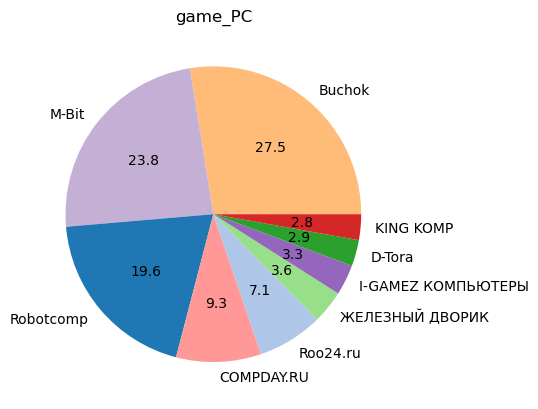

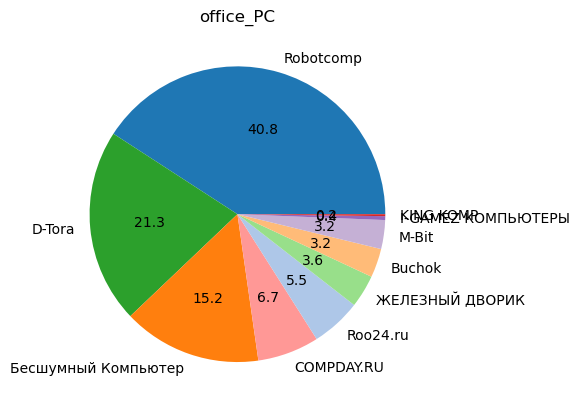

In [636]:
for PC in type_PC:
    df =  seller_counts_top_10[seller_counts_top_10['type_PC']==PC]
    
    seller_counts = df['seller'].value_counts()
    labels = seller_counts.index

    plt.title(PC)
    plt.pie(seller_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
1. Продавцы Buchok и M-bit занимаются в основном продажей игровых ПК
2. Большая часть офисных ПК продается продавцами Robotcomp и D-Tiora

## 2.15 Признак type_PC и OS

In [637]:
labels = dataset['OS'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'без oc': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'windows 10 pro': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274),
 'windows 10': (1.0, 0.4980392156862745, 0.054901960784313725),
 'windows 11 pro': (1.0, 0.7333333333333333, 0.47058823529411764)}

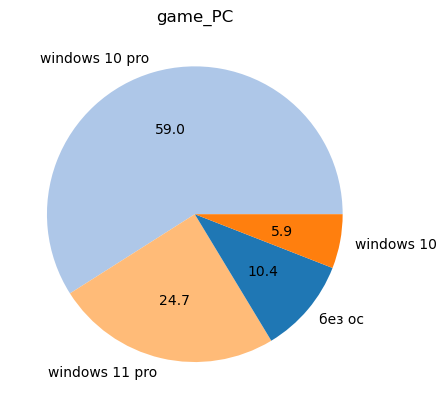

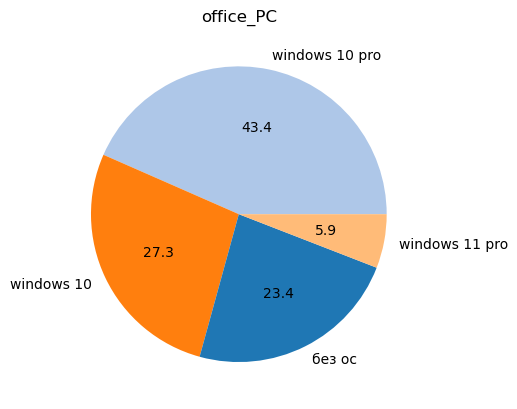

In [638]:
for PC in type_PC:
    df =  dataset[dataset['type_PC']==PC]
    
    OS_counts = df['OS'].value_counts()
    labels = OS_counts.index

    plt.title(PC)
    plt.pie(OS_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
1. Взаимосвязей не выявлено

## 2.16 Признак type_proc и OS

In [639]:
type_OS = dataset['OS'].value_counts().index
type_OS

Index(['windows 10 pro', 'windows 11 pro', 'без oc', 'windows 10'], dtype='object')

In [640]:
labels = dataset['type_proc'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'intel core i5': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'intel core i3': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'amd ryzen 5': (1.0, 0.4980392156862745, 0.054901960784313725),
 'amd athlon': (1.0, 0.7333333333333333, 0.47058823529411764),
 'intel core i7': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'amd ryzen 3': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'amd a6': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'intel pentium': (1.0, 0.596078431372549, 0.5882352941176471),
 'amd ryzen 7': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'intel xeon': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)}

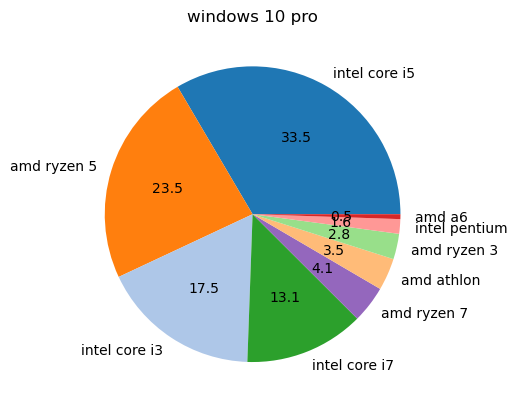

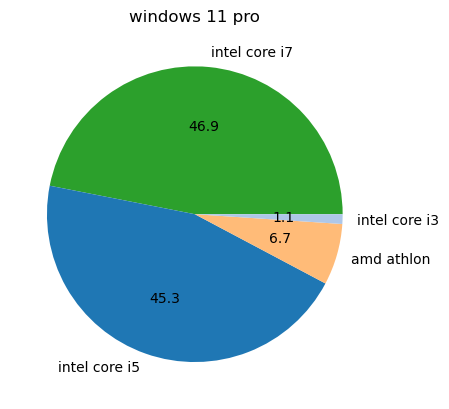

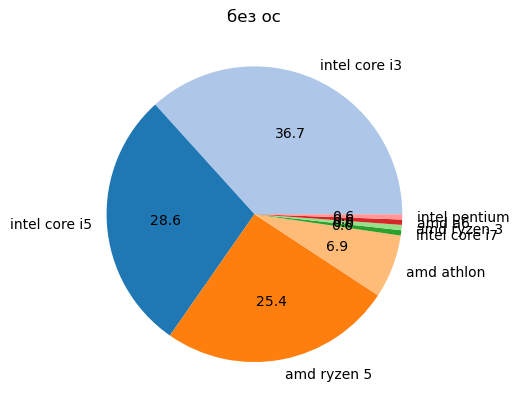

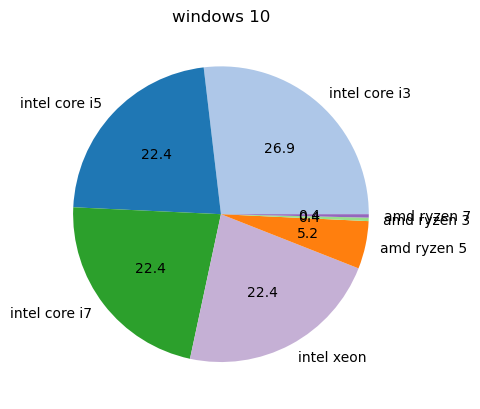

In [641]:
for OS in type_OS:
    df =  dataset[dataset['OS']==OS]
    
    type_proc_counts = df['type_proc'].value_counts()
    labels = type_proc_counts.index

    plt.title(OS)
    plt.pie(type_proc_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:

1. Для windows 11 pro характерны более мощные процессоры intel core i7 intel и core i5
2. Windows 10 и ПК без ОС характерны для большинства типов процессоров

## 2.17 Признак seller и OS

In [642]:
labels = dataset['seller'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'Robotcomp': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Roo24.ru': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Бесшумный Компьютер': (1.0, 0.4980392156862745, 0.054901960784313725),
 'ABS-TECHNO.RU': (1.0, 0.7333333333333333, 0.47058823529411764),
 'ЗЕОН': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Buchok': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 '4T-Computer Store': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'D-Tora': (1.0, 0.596078431372549, 0.5882352941176471),
 'KSKSHOP': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'ЖЕЛЕЗНЫЙ ДВОРИК': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589),
 'Континент': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'KING KOMP': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'COMPDAY.RU': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'I-GAMEZ КОМПЬЮТЕРЫ': (0.968

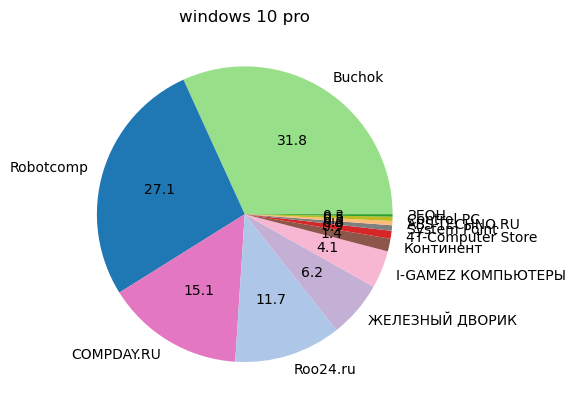

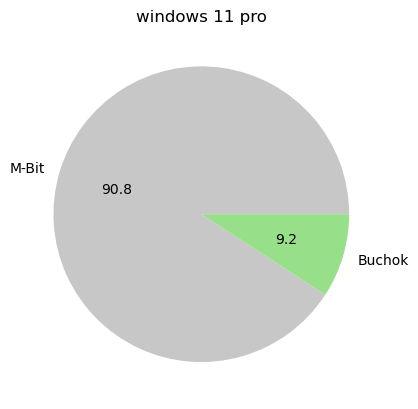

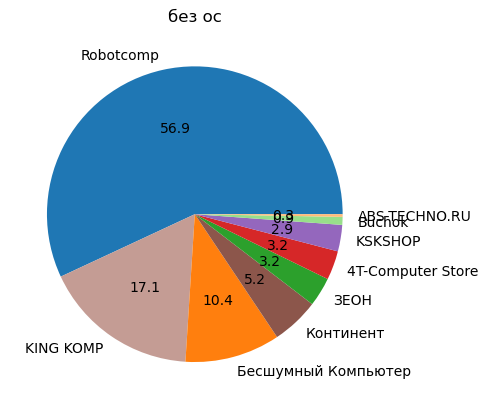

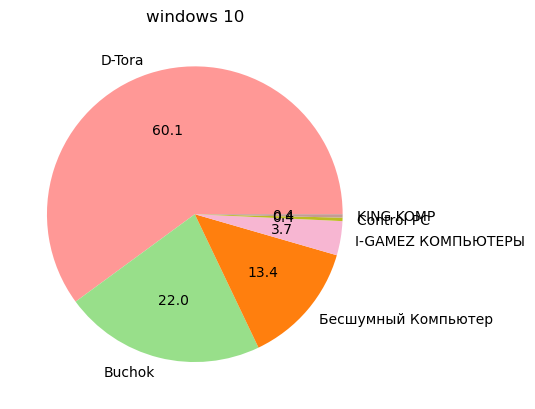

In [643]:
for OS in type_OS:
    df =  dataset[dataset['OS']==OS]
    
    seller_counts = df['seller'].value_counts()
    labels = seller_counts.index

    plt.title(OS)
    plt.pie(seller_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
Для некоторых продавца выявлены характерные закономерности:
1. Продавец Robotcomp в основном предоставляет ПК без ОС и с ОС windows 10 pro
2. Продавец Buchok в основном предоставляет ПК с ОС windows 10 pro и  windows 10
3. Продавец M-bit в основном предоставляет ПК с ОС windows 11 pro 
4. Продавец D-Tiora в основном предоставляет ПК с ОС windows 10

## 2.18 Признак videocard и OS

In [644]:
labels = videocard_counts_top_10['videocard'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'nvidia geforce gtx 1660': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765),
 'nvidia geforce gtx 1650': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274),
 'nvidia geforce rtx 3050': (1.0, 0.4980392156862745, 0.054901960784313725),
 'amd radeon vega 7': (1.0, 0.7333333333333333, 0.47058823529411764),
 'nvidia geforce rtx 3060': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'nvidia geforce gt 1030': (0.596078431372549,
  0.8745098039215686,
  0.5411764705882353),
 'intel hd graphics 530': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'nvidia geforce rtx 2060': (1.0, 0.596078431372549, 0.5882352941176471),
 'intel hd graphics 2000': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353),
 'nvidia geforce rtx 3070': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589)}

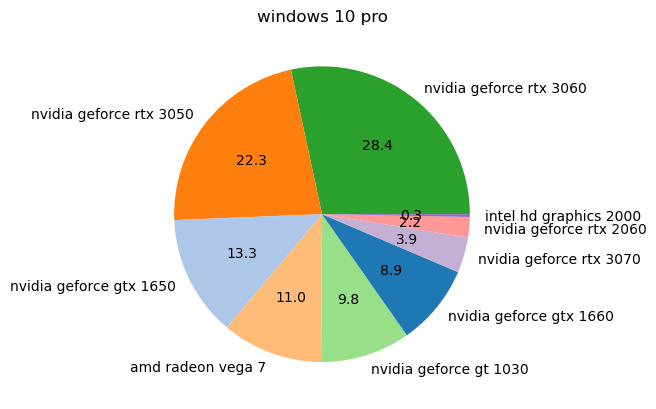

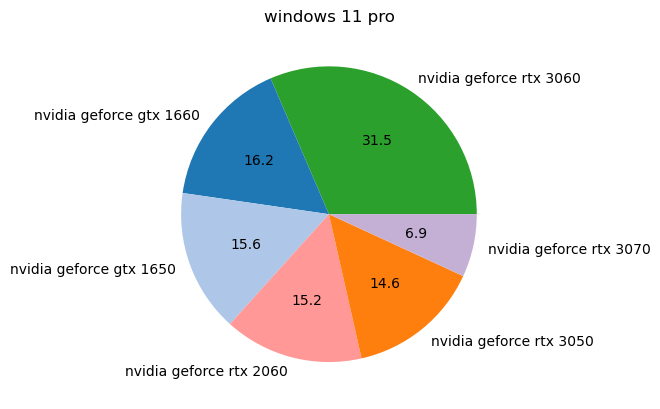

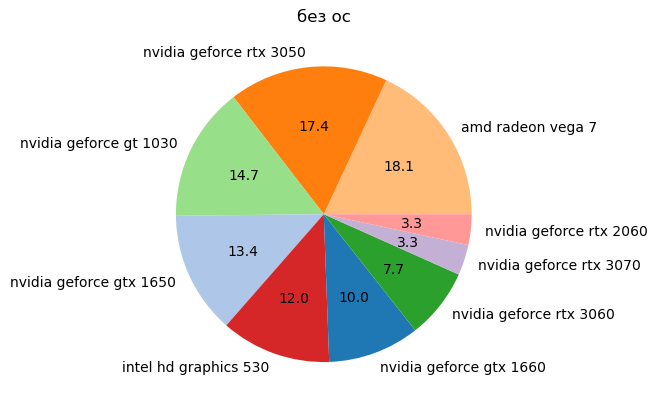

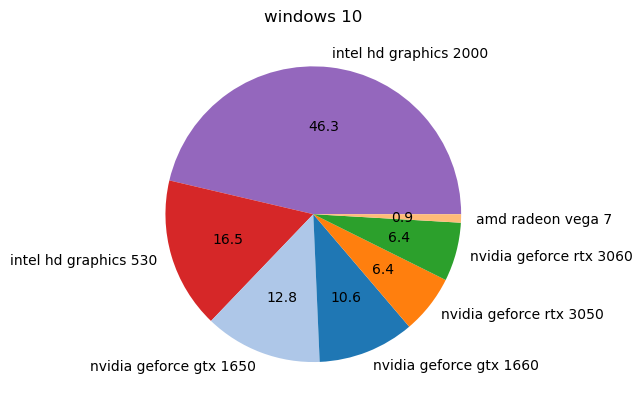

In [645]:
for OS in type_OS:
    df =  videocard_counts_top_10[videocard_counts_top_10['OS']==OS]
    
    videocard_counts = df['videocard'].value_counts()
    labels = videocard_counts.index

    plt.title(OS)
    plt.pie(videocard_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
Прямых взаимосвязей не выявлено

## 2.19 Признак type_proc и seller

In [646]:
type_proc = dataset['type_proc'].value_counts().index
type_proc

Index(['intel core i5', 'intel core i7', 'intel core i3', 'amd ryzen 5',
       'amd athlon', 'amd ryzen 7', 'intel xeon', 'amd ryzen 3',
       'intel pentium', 'amd a6'],
      dtype='object')

In [647]:
labels = dataset['seller'].unique()
colors = dict(zip(labels, plt.cm.tab20.colors[:len(labels)]))
colors

{'Robotcomp': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Roo24.ru': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Бесшумный Компьютер': (1.0, 0.4980392156862745, 0.054901960784313725),
 'ABS-TECHNO.RU': (1.0, 0.7333333333333333, 0.47058823529411764),
 'ЗЕОН': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Buchok': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 '4T-Computer Store': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'D-Tora': (1.0, 0.596078431372549, 0.5882352941176471),
 'KSKSHOP': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'ЖЕЛЕЗНЫЙ ДВОРИК': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589),
 'Континент': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'KING KOMP': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'COMPDAY.RU': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'I-GAMEZ КОМПЬЮТЕРЫ': (0.968

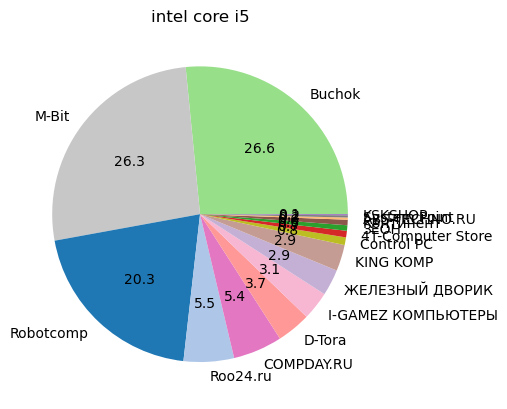

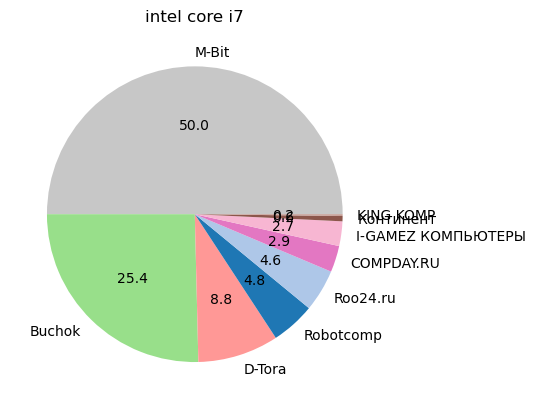

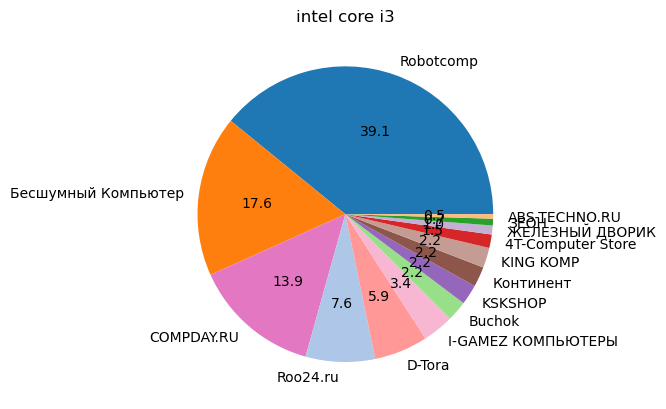

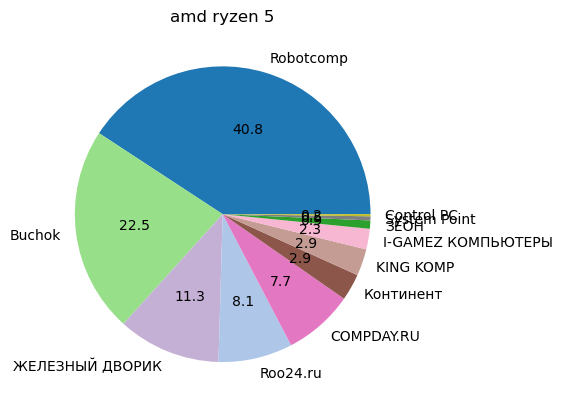

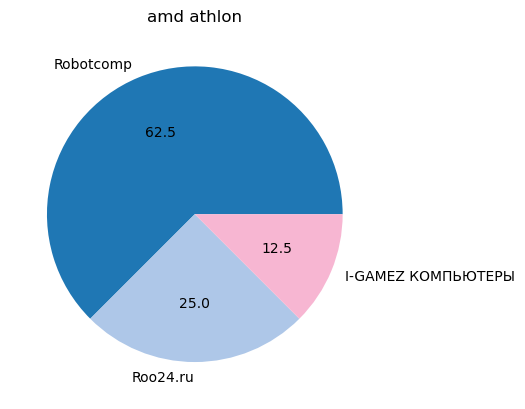

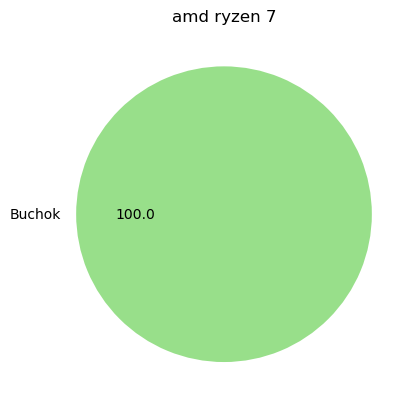

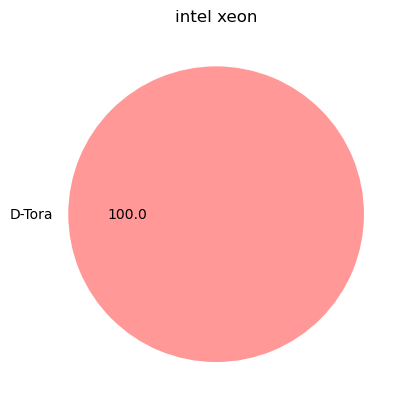

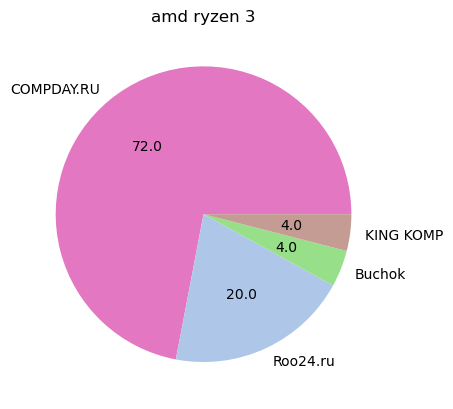

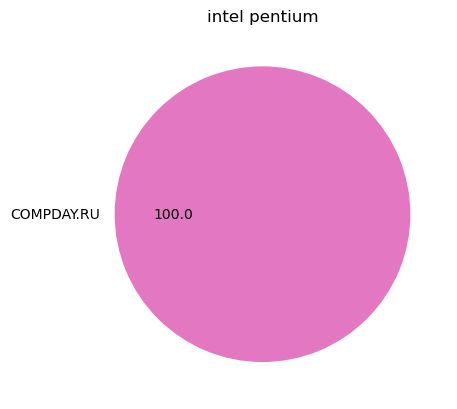

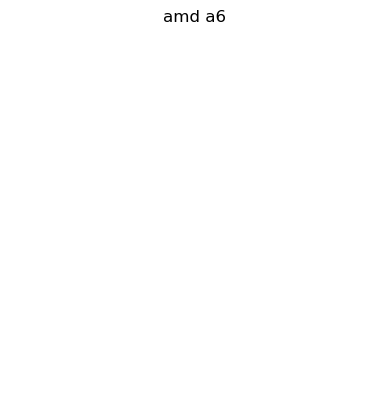

In [648]:
for proc in type_proc:
    df =  videocard_counts_top_10[videocard_counts_top_10['type_proc']==proc]
    
    seller_counts = df['seller'].value_counts()
    labels = seller_counts.index

    plt.title(proc)
    plt.pie(seller_counts.values, labels = labels, colors = [colors[key] for key in labels], autopct='%.1f')
    plt.show()

### Выводы:
Для некоторых продавца выявлены характерные закономерности:
1. Продавец Robotcomp в основном предоставляет ПК с процессорами amd athlon, amd ryzen 5, intel core i3 и intel core i5
2. Продавец Buchok в основном предоставляет ПК с процессорами amd ryzen 5, amd ryzen 7, intel core i5 и intel core i7
3. Продавец M-bit в основном предоставляет ПК с процессорами intel core i5 и intel core i7
4. Продавец D-Tiora в основном предоставляет ПК с процессорами intel xeon
5. Продавец COMPDAY.RU в основном предоставляет ПК с процессорами intel pentium и amd ryzen 3

## 2.20 Признак clear_title

In [649]:
dataset['clear_title'].value_counts()[:20]

game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060      78
office_PC/windows 10 pro/amd ryzen 5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7             57
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050    55
game_PC/windows 11 pro/intel core i7/ядер 8/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060      47
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060    40
office_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7             39
game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1660      39
game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 2060      36
game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1650      36
game_PC/windows 10 pro/amd r

In [650]:
title_list = dataset['clear_title'].value_counts()[:20].index
title_list

Index(['game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060',
       'office_PC/windows 10 pro/amd ryzen 5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7',
       'game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050',
       'game_PC/windows 11 pro/intel core i7/ядер 8/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 3060',
       'game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060',
       'office_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7',
       'game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1660',
       'game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce rtx 2060',
       'game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1650',
       'game_PC/wind

In [651]:
title_top_20 = dataset[dataset['clear_title'].isin(title_list)]
title_top_20.shape

(745, 20)

In [652]:
title_top_20.groupby('clear_title')['clear_price'].describe()

,count,mean,std,min,25%,50%,75%,max
clear_title,,,,,,,,
game_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,35.0,85965.685714,3743.671537,81936.0,83404.0,85699.0,85699.00,95752.0
game_PC/windows 10 pro/amd ryzen 7/ядер 8/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,31.0,92838.064516,2792.462974,90580.0,90580.0,94080.0,94080.00,101080.0
game_PC/windows 10 pro/intel core i3/ядер 4/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030,28.0,36228.250000,2939.429859,32115.0,34125.0,35800.0,37482.75,42574.0
game_PC/windows 10 pro/intel core i3/ядер 4/8 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030,32.0,36343.031250,4151.158622,32473.0,33375.0,35238.0,37027.25,49379.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce gtx 1650,30.0,61600.766667,1854.291457,55425.0,60748.0,60748.0,63640.00,63640.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050,55.0,75278.363636,3733.933629,72806.0,72806.0,73766.0,74872.00,86996.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,40.0,80693.925000,4827.464235,74395.0,78105.0,78105.0,80432.25,92795.0
game_PC/windows 10 pro/intel core i5/ядер 6/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,27.0,85175.185185,1411.231487,84475.0,84510.0,84510.0,85482.00,91813.0
game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1650,36.0,60557.944444,3950.301666,55431.0,55431.0,62656.0,64071.00,64071.0


In [653]:
title_top_20.groupby('clear_title')['clear_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
clear_title,,,,,,,,
game_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,35.0,5.857143,4.285014,5.0,5.0,5.0,5.0,30.0
game_PC/windows 10 pro/amd ryzen 7/ядер 8/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,31.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
game_PC/windows 10 pro/intel core i3/ядер 4/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030,28.0,10.892857,17.376739,5.0,5.0,5.0,5.0,90.0
game_PC/windows 10 pro/intel core i3/ядер 4/8 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030,32.0,11.718750,20.853149,5.0,5.0,5.0,5.0,90.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce gtx 1650,30.0,5.166667,0.912871,5.0,5.0,5.0,5.0,10.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050,55.0,5.272727,2.022600,5.0,5.0,5.0,5.0,20.0
game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,40.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
game_PC/windows 10 pro/intel core i5/ядер 6/32 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060,27.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
game_PC/windows 11 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1650,36.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0


In [654]:
result = []
for PC in title_list:
    df = title_top_20[title_top_20['clear_title']==PC]
    count_PC = df['clear_price'].count()
    min_price = df['clear_price'].min()
    max_price = df['clear_price'].max()
    price_fork = max_price - min_price
    result.append({
        'Сбока ПК' : PC,
        'Количество ПК' : count_PC,
        'Минимальная цена' : min_price,
        'Максимальная цена' : max_price,
        'Ценовая вилка' : price_fork        
    })


In [655]:
price_fork = pd.DataFrame.from_dict(result, orient='columns')
price_fork

,Сбока ПК,Количество ПК,Минимальная цена,Максимальная цена,Ценовая вилка
0,game_PC/windows 11 pro/intel core i5/ядер 6/16...,78,76824,87300,10476
1,office_PC/windows 10 pro/amd ryzen 5/ядер 6/16...,57,30418,48168,17750
2,game_PC/windows 10 pro/intel core i5/ядер 6/16...,55,72806,86996,14190
3,game_PC/windows 11 pro/intel core i7/ядер 8/16...,47,82280,91080,8800
4,game_PC/windows 10 pro/intel core i5/ядер 6/16...,40,74395,92795,18400
5,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,39,33550,52368,18818
6,game_PC/windows 11 pro/intel core i5/ядер 6/16...,39,62823,68490,5667
7,game_PC/windows 11 pro/intel core i5/ядер 6/16...,36,71007,77571,6564
8,game_PC/windows 11 pro/intel core i5/ядер 6/16...,36,55431,64071,8640
9,game_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Г...,35,81936,95752,13816


In [656]:
price_fork.to_csv('price_fork.csv', index = False)

In [657]:
top_sales = dataset[dataset['clear_sales'] > 5] 

In [658]:
top_sales_list = top_sales['clear_title'].value_counts()[:20].index
top_sales_list

Index(['office_PC/windows 10 pro/amd ryzen 5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7',
       'office_PC/без oc/amd ryzen 5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7',
       'game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/1000 Гб ssd/nvidia geforce gtx 1660',
       'game_PC/windows 10 pro/intel core i3/ядер 4/8 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030',
       'game_PC/windows 10 pro/intel core i3/ядер 4/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030',
       'game_PC/без oc/intel core i3/ядер 4/8 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce gt 1030',
       'game_PC/windows 10 pro/intel core i7/ядер 12/16 Гб RAM/ 1000 Гб hdd/500 Гб ssd/nvidia geforce rtx 3060',
       'game_PC/windows 10 pro/intel core i5/ядер 6/16 Гб RAM/ 0 Гб hdd/500 Гб ssd/nvidia geforce rtx 3050',
       'office_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Гб RAM/ 0 Гб hdd/500 Гб ssd/amd radeon vega 7',
       'office_PC/windows 10 pro/amd ryzen 5/ядер 6/3

In [659]:
result2 = []
for PC in top_sales_list:
    df = top_sales[top_sales['clear_title']==PC]
    count_PC = df['clear_price'].count()
    min_price = df['clear_price'].min()
    max_price = df['clear_price'].max()
    price_fork_sales = max_price - min_price
    result2.append({
        'Сбока ПК' : PC,
        'Количество ПК' : count_PC,
        'Минимальные продажи' : min_price,
        'Максимальные продажи' : max_price,
        'Ценовая вилка' : price_fork_sales
    })


In [660]:
price_fork_for_sales = pd.DataFrame.from_dict(result2, orient='columns')
price_fork_for_sales

,Сбока ПК,Количество ПК,Минимальные продажи,Максимальные продажи,Ценовая вилка
0,office_PC/windows 10 pro/amd ryzen 5/ядер 6/16...,15,30418,37979,7561
1,office_PC/без oc/amd ryzen 5/ядер 6/16 Гб RAM/...,8,29354,39389,10035
2,game_PC/windows 10 pro/intel core i5/ядер 6/16...,6,54719,83438,28719
3,game_PC/windows 10 pro/intel core i3/ядер 4/8 ...,5,32851,36810,3959
4,game_PC/windows 10 pro/intel core i3/ядер 4/16...,5,35302,37794,2492
5,game_PC/без oc/intel core i3/ядер 4/8 Гб RAM/ ...,4,30760,32379,1619
6,game_PC/windows 10 pro/intel core i7/ядер 12/1...,4,103062,117108,14046
7,game_PC/windows 10 pro/intel core i5/ядер 6/16...,4,65115,65372,257
8,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,4,34694,39650,4956
9,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,3,40971,48352,7381


## Выводы по итогам разведочного анализа:

1. Выявлены наиболее распространенные значения по всем признакам
2. Проанализированные признаки условно можно разделить на 2 группы:
    2.1 имеют сильную связь с целевым признаком price (type_PC, OS, core_count, vol_ram, type_ram, ssd_vol, type_proc, videocard)
    2.2 имеют слабую связь с целевым признаком price
3. Условно все ПК можно разделить на 4 основные ценовые категории:
    3.1 ПК стоимостью до 40 тыс.руб.
    3.2 ПК стоимостью от 40 до 63 тыс.руб.
    3.3 ПК стоимостью от 63 до 90 тыс.руб.
    3.4 ПК стоимостью свыше 90 тыс.руб.
4. Графический анализ признаков (боксплоты) показывает большое количество выбросов, что объясняется огромной вариативностью сборок ПК
5. Выявлены характерные закономерности:

    5.1 Основной ценовой диапазон игровых ПК 60 000 - 90 000 руб, офисных 25 000 - 40 000 руб.
    
    5.2 Наиболее распространенные ПК с объемом оперативной памяти 16, 32 и 8Гб и количеством ядер процессора 6, 4 и 8
    
    5.3 ПК с количеством ядер 4 и менее находятся в ценовом диапазоне до 100 т.р.
    
    5.4 ПК с количеством ядер менее 10 имеют объем оперативной памяти не более 12Гб
    
    5.5 ПК с объемом оперативной памяти менее 10 ГБ находятся в ценовом диапазоне до 100 т.р.
    
    5.6 Игровые ПК наиболее распространенный тип, 78,3%
    
    5.7 Наиболее распространенное поколение оперативной памяти DDR4 
    
    5.8 Поколение DDR3 соответствует наиболее дешевым ПК с ценой до 45 000 (поколение DDR3 на сегодняшний день является морально устаревшим)
    
    5.9 Поколение DDR5 соответствует наиболее дорогим ПК с ценой более 130 000
    
    5.10 Наиболее распространенными типами накопителей является ssd объемом 500Гб и 1000Гб, а также hdd объемом 1000Гб.
    
    5.11 Наиболее распространенный гарантийный срок 1 и 2 года
    
    5.12 Процессоры линейки intel core i7 и amd ryzen 7 характерны для более дорогих ПК, с ценой более 80 000 руб.
    
    5.13 Процессоры линейки amd ryzen 3 и intel core i3 характерны для ценовой категории до 60 000 руб
    
    5.14 Процессоры линейки intel core i5 характерны для ценовой категории от 60 000 до 80 000 руб
    
    5.15 Видеокарта nvidia geforce rtx 3070 характерна для более дорогих ПК, с ценой более 120 000 руб.
    
    5.16 Видеокарта intel hd graphics 2000(встроенная) характерна для самых дешевый ПК с ценой до 30 000 руб
    

6. Выявлены топ 20 самых распространенных сборок ПК, при этом разница между минимальной и максимальной ценой одной и той же сборки может составлять до 20 тыс.  руб.    

In [661]:
dataset.to_csv('clear_data_EDA.csv', index = False)

# Статистический анализ

Для начала определимся с типами наших данных. Признаки:
1. clear_price - основной целевой количественный признак, непрерывная шкала
2. type_PC - категориальный признак, номинальная шкала
3. OS - категориальный признак, номинальная шкала
4. type_proc - категориальный признак, номинальная шкала
5. core_count - количественный признак, интервальная шкала
6. type_ram - категориальный признак, номинальная шкала
7. vol_ram - количественный признак, интервальная шкала
8. hdd_vol - количественный признак, интервальная шкала 
9. ssd_vol - количественный признак, интервальная шкала
10. videocard - категориальный признак, номинальная шкала
11. seller - категориальный признак, номинальная шкала
12. seller_rating - количественный признак, непрерывная шкала
13. clear_sales - количественный признак, порядковая шкала
14. clear_feedbacks - количественный признак, непрерывная шкала
15. clear_garanty - количественный признак, непрерывная шкала
16. Страна производства - категориальный признак, номинальная шкала

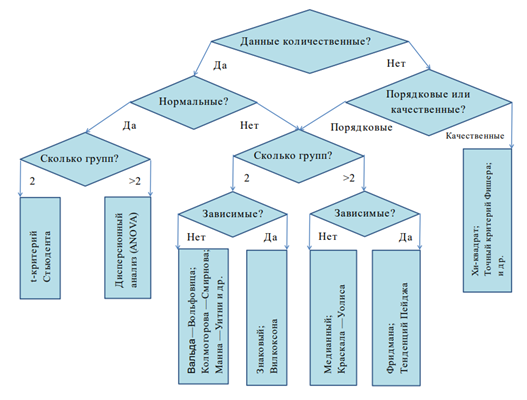

In [2]:
df = pd.read_csv('clear_data_EDA.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687 entries, 0 to 2686
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         2687 non-null   int64  
 1   clear_title        2687 non-null   object 
 2   clear_price        2687 non-null   int64  
 3   type_PC            2687 non-null   object 
 4   OS                 2687 non-null   object 
 5   type_proc          2687 non-null   object 
 6   core_count         2687 non-null   int64  
 7   type_ram           2687 non-null   object 
 8   vol_ram            2687 non-null   int64  
 9   hdd_vol            2687 non-null   int64  
 10  ssd_vol            2687 non-null   int64  
 11  videocard          2687 non-null   object 
 12  seller             2687 non-null   object 
 13  seller_rating      2687 non-null   float64
 14  clear_sales        2687 non-null   int64  
 15  clear_feedbacks    2687 non-null   int64  
 16  clear_garanty      2687 

Рассчитаем коэффициент ассиметрии

In [663]:
df[['clear_price', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'seller_rating', 'clear_garanty', 'clear_sales']].skew()

clear_price       0.151079
core_count        2.663158
vol_ram           1.637780
hdd_vol           0.869123
ssd_vol           0.920182
seller_rating    -1.486846
clear_garanty    -1.480303
clear_sales      15.847843
dtype: float64

Рассчитаем коэффициент эксцесса

In [664]:
df[['clear_price', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'seller_rating', 'clear_garanty', 'clear_sales']].kurtosis()

clear_price       -0.621469
core_count        10.004149
vol_ram            4.732359
hdd_vol           -0.958166
ssd_vol            1.568559
seller_rating      0.292187
clear_garanty      0.203131
clear_sales      303.251600
dtype: float64

Проверим нормальность по критерию Шапиро-Уилка

In [665]:
stats.shapiro(df['clear_price'])

ShapiroResult(statistic=0.971194326877594, pvalue=7.82476622360622e-23)

In [666]:
stats.shapiro(df['clear_sales'])

ShapiroResult(statistic=0.09211587905883789, pvalue=0.0)

На основании полученных значений отклоним гипотезу о нормальном распределении величины clear_price и clear_sales

## Критерии сравнения групп

Рассчитаем показатель mode() целевого признака clear_price для категориальных признаков

In [667]:
OS_list = df['OS'].value_counts().index
OS_list

Index(['windows 10 pro', 'windows 11 pro', 'без oc', 'windows 10'], dtype='object')

In [668]:
OS_frame = []
for OS in OS_list:
    dt = df[df['OS']==OS]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    OS_frame.append({
        'Наименование' : OS,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
OS_frame = pd.DataFrame.from_dict(OS_frame, orient='columns')
OS_frame.index = ['OS', 'OS', 'OS', 'OS']

In [669]:
type_PC_list = df['type_PC'].value_counts().index
type_PC_list

Index(['game_PC', 'office_PC'], dtype='object')

In [670]:
type_PC_frame = []
for type_PC in type_PC_list:
    dt = df[df['type_PC']==type_PC]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    type_PC_frame.append({
        'Наименование' : type_PC,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
type_PC_frame = pd.DataFrame.from_dict(type_PC_frame, orient='columns')
type_PC_frame.index = ['type_PC', 'type_PC']

In [671]:
type_proc_list = df['type_proc'].value_counts()[:6].index
type_proc_list

Index(['intel core i5', 'intel core i7', 'intel core i3', 'amd ryzen 5',
       'amd athlon', 'amd ryzen 7'],
      dtype='object')

In [672]:
proc_top_6 = df[df['type_proc'].isin(type_proc_list)]
proc_top_6.shape

(2546, 20)

In [673]:
type_proc_frame = []
for type_proc in type_proc_list:
    dt = proc_top_6[proc_top_6['type_proc']==type_proc]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    type_proc_frame.append({
        'Наименование' : type_proc,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
type_proc_frame = pd.DataFrame.from_dict(type_proc_frame, orient='columns')
type_proc_frame.index = ['type_proc', 'type_proc', 'type_proc', 'type_proc', 'type_proc', 'type_proc']

In [674]:
RAM_list = df['type_ram'].value_counts().index
RAM_list

Index(['DDR 4', 'DDR 3'], dtype='object')

In [675]:
RAM_frame = []
for ram in RAM_list:
    dt = df[df['type_ram']==ram]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    RAM_frame.append({
        'Наименование' : ram,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
RAM_frame = pd.DataFrame.from_dict(RAM_frame, orient='columns')
RAM_frame.index = ['type_ram', 'type_ram']

In [676]:
videocard_list = df['videocard'].value_counts()[:10].index
videocard_list

Index(['nvidia geforce rtx 3060', 'nvidia geforce rtx 3050',
       'nvidia geforce gtx 1650', 'nvidia geforce gtx 1660',
       'amd radeon vega 7', 'nvidia geforce gt 1030',
       'nvidia geforce rtx 2060', 'intel hd graphics 2000',
       'nvidia geforce rtx 3070', 'intel hd graphics 530'],
      dtype='object')

In [677]:
videocard_top_10 = df[df['videocard'].isin(videocard_list)]
videocard_top_10.shape

(2338, 20)

In [678]:
videocard_frame = []
for videocard in videocard_list:
    dt = videocard_top_10[videocard_top_10['videocard']==videocard]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    videocard_frame.append({
        'Наименование' : videocard,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
videocard_frame = pd.DataFrame.from_dict(videocard_frame, orient='columns')
videocard_frame.index = ['videocard', 'videocard','videocard', 'videocard','videocard', 'videocard','videocard', 'videocard','videocard', 'videocard']

In [679]:
seller_list = df['seller'].value_counts()[:10].index
seller_list

Index(['Robotcomp', 'Buchok', 'M-Bit', 'COMPDAY.RU', 'Roo24.ru', 'D-Tora',
       'ЖЕЛЕЗНЫЙ ДВОРИК', 'I-GAMEZ КОМПЬЮТЕРЫ', 'Бесшумный Компьютер',
       'KING KOMP'],
      dtype='object')

In [680]:
seller_top_10 = df[df['seller'].isin(seller_list)]
seller_top_10.shape

(2574, 20)

In [681]:
seller_frame = []
for seller in seller_list:
    dt = seller_top_10[seller_top_10['seller']==seller]['clear_price']
    count_PC = stats.mode(dt).count[0]
    mode_price = stats.mode(dt).mode[0]
    seller_frame.append({
        'Наименование' : seller,
        'Распространенная цена' : mode_price,
        'Количество ПК' : count_PC
        })
seller_frame = pd.DataFrame.from_dict(seller_frame, orient='columns')
seller_frame.index = ['seller', 'seller','seller', 'seller','seller', 'seller','seller', 'seller','seller', 'seller']

In [682]:
result = pd.concat([type_PC_frame, OS_frame, type_proc_frame, RAM_frame, videocard_frame, seller_frame])
result

,Наименование,Распространенная цена,Количество ПК
type_PC,game_PC,65630,27
type_PC,office_PC,31000,12
OS,windows 10 pro,78105,25
OS,windows 11 pro,88880,21
OS,без oc,54000,8
OS,windows 10,67672,11
type_proc,intel core i5,78105,25
type_proc,intel core i7,88880,21
type_proc,intel core i3,54000,9
type_proc,amd ryzen 5,65630,14


Сравним каждый категориальный признак с целевым признаком clear_price и установим статистическую значимость каждого из этих признаков. Но для начала закодируем значения категориальных признаков

In [683]:
OS_label = preprocessing.LabelEncoder()
df['OS']= OS_label.fit_transform(df['OS']) 

In [684]:
PC_label = preprocessing.LabelEncoder()
df['type_PC']= PC_label.fit_transform(df['type_PC']) 

In [685]:
ram_label = preprocessing.LabelEncoder()
df['type_ram']= ram_label.fit_transform(df['type_ram']) 

In [686]:
df['type_proc'].value_counts()

intel core i5    920
intel core i7    525
intel core i3    468
amd ryzen 5      456
amd athlon       115
amd ryzen 7       62
intel xeon        60
amd ryzen 3       45
intel pentium     26
amd a6            10
Name: type_proc, dtype: int64

In [687]:
type_proc_dict = {'intel core i5': 0, 'intel core i7': 1, 'intel core i3': 2, 'amd ryzen 5': 3,
       'amd athlon': 4, 'amd ryzen 7': 5, 'intel xeon': 6, 'amd ryzen 3': 7,
       'intel pentium': 8, 'amd a6': 9    
}

In [688]:
df['type_proc'] = df['type_proc'].replace(type_proc_dict)

In [689]:
df['videocard'].value_counts()

nvidia geforce rtx 3060    568
nvidia geforce rtx 3050    434
nvidia geforce gtx 1650    321
nvidia geforce gtx 1660    250
amd radeon vega 7          204
nvidia geforce gt 1030     176
nvidia geforce rtx 2060    113
intel hd graphics 2000     105
nvidia geforce rtx 3070     95
intel hd graphics 530       72
amd radeon vega 3           63
nvidia geforce gtx 1050     54
amd radeon rx 580           42
amd radeon rx 550           27
nvidia geforce gtx 1060     24
intel uhd graphics 730      24
intel uhd graphics 630      22
amd radeon r5               15
nvidia geforce rtx 1660     13
amd radeon rx 6600          13
amd radeon rx 570           12
amd radeon rx 6500          11
intel uhd graphics 610      10
nvidia geforce gtx 1630     10
intel hd graphics 2500       6
amd radeon vega 8            3
Name: videocard, dtype: int64

In [690]:
videocard_dict = {'nvidia geforce rtx 3060': 0, 'nvidia geforce rtx 3050': 1, 'nvidia geforce gtx 1650': 2, 
                  'nvidia geforce gtx 1660': 3, 'amd radeon vega 7': 4, 'nvidia geforce gt 1030': 5,
                  'nvidia geforce rtx 2060': 6, 'intel hd graphics 2000': 7, 'nvidia geforce rtx 3070': 8, 
                  'intel hd graphics 530': 9, 'amd radeon vega 3': 10, 'nvidia geforce gtx 1050': 11, 
                  'amd radeon rx 580': 12, 'amd radeon rx 550': 13, 'nvidia geforce gtx 1060' : 14,
                  'intel uhd graphics 730': 15, 'intel uhd graphics 630': 16, 'amd radeon r5': 17,
                  'nvidia geforce rtx 1660': 18, 'amd radeon rx 6600': 19, 'amd radeon rx 570': 20, 
                  'amd radeon rx 6500': 21, 'intel uhd graphics 610': 22, 'nvidia geforce gtx 1630': 23,
                  'intel hd graphics 2500': 24, 'amd radeon vega 8': 25               
                 }

In [691]:
df['videocard'] = df['videocard'].replace(videocard_dict)

In [692]:
df['seller'].value_counts()

Robotcomp              605
Buchok                 593
M-Bit                  515
COMPDAY.RU             227
Roo24.ru               176
D-Tora                 161
ЖЕЛЕЗНЫЙ ДВОРИК         93
I-GAMEZ КОМПЬЮТЕРЫ      72
Бесшумный Компьютер     72
KING KOMP               60
Континент               39
4T-Computer Store       24
ЗЕОН                    15
KSKSHOP                 10
System Point             9
ABS-TECHNO.RU            8
Control PC               8
Name: seller, dtype: int64

In [693]:
seller_dict = {'Robotcomp': 0, 'Buchok': 1, 'M-Bit': 2, 'COMPDAY.RU': 3, 'Roo24.ru': 4, 'D-Tora': 5,
               'ЖЕЛЕЗНЫЙ ДВОРИК': 6, 'Бесшумный Компьютер': 7, 'I-GAMEZ КОМПЬЮТЕРЫ': 8, 'KING KOMP': 9,
               'Континент': 10, '4T-Computer Store': 11, 'ЗЕОН': 12, 'KSKSHOP': 13, 'System Point': 14,
               'ABS-TECHNO.RU': 15, 'Control PC': 16}

In [694]:
df['seller'] = df['seller'].replace(seller_dict)

In [695]:
land_dict = {'Россия': 0, 'Китай': 1}

In [696]:
df['land'] = df['land'].replace(land_dict)

### 1. Признак type_PC

In [697]:
df['type_PC'].value_counts()

0    2178
1     509
Name: type_PC, dtype: int64

In [698]:
df_game = df[df['type_PC'] == 0]
df_off = df[df['type_PC'] == 1]

In [699]:
print(stats.shapiro(df_game['clear_sales']))
print(stats.shapiro(df_off['clear_sales']))

ShapiroResult(statistic=0.07688194513320923, pvalue=0.0)
ShapiroResult(statistic=0.15232539176940918, pvalue=1.1812946054258208e-42)


В совокупности групп распределение не является нормальным

In [700]:
scipy.stats.mannwhitneyu(df_game['clear_price'],df_off['clear_price'])

MannwhitneyuResult(statistic=995793.0, pvalue=1.0249392551567946e-172)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 2. Признак OS

In [701]:
df['OS'].value_counts()

1    1506
2     567
3     346
0     268
Name: OS, dtype: int64

In [702]:
df_win0 = np.array(df[df['OS'] == 0]['clear_price'])
df_win1 = np.array(df[df['OS'] == 1]['clear_price'])
df_win2 = np.array(df[df['OS'] == 2]['clear_price'])
df_win3 = np.array(df[df['OS'] == 3]['clear_price'])

Проверим гипотезу о нормальном распределении каждой отдельной группы

In [703]:
print(stats.shapiro(df_win0))
print(stats.shapiro(df_win1))
print(stats.shapiro(df_win2))
print(stats.shapiro(df_win3))

ShapiroResult(statistic=0.8861119151115417, pvalue=2.7580371255060687e-13)
ShapiroResult(statistic=0.9723536968231201, pvalue=2.0788754770752915e-16)
ShapiroResult(statistic=0.9586390256881714, pvalue=1.580462150041484e-11)
ShapiroResult(statistic=0.9430924654006958, pvalue=2.8831528831041453e-10)


В совокупности групп распределение не является нормальным

In [704]:
stats.mstats.kruskalwallis(df_win0, df_win1, df_win2, df_win3)

KruskalResult(statistic=291.4880385509669, pvalue=6.916866896173745e-63)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 3. Признак type_proc

В датасете есть типы процессоров, количество которых меньше 10, данные процессоры не представляют интереса для анализа, отфильтруем их, и закодируем значения

In [705]:
df['type_proc'].value_counts()

0    920
1    525
2    468
3    456
4    115
5     62
6     60
7     45
8     26
9     10
Name: type_proc, dtype: int64

In [706]:
df_proc0 = np.array(df[df['type_proc'] == 0]['clear_price'])
df_proc1 = np.array(df[df['type_proc'] == 1]['clear_price'])
df_proc2 = np.array(df[df['type_proc'] == 2]['clear_price'])
df_proc3 = np.array(df[df['type_proc'] == 3]['clear_price'])
df_proc4 = np.array(df[df['type_proc'] == 4]['clear_price'])
df_proc5 = np.array(df[df['type_proc'] == 5]['clear_price'])
df_proc6 = np.array(df[df['type_proc'] == 6]['clear_price'])
df_proc7 = np.array(df[df['type_proc'] == 7]['clear_price'])
df_proc8 = np.array(df[df['type_proc'] == 8]['clear_price'])
df_proc9 = np.array(df[df['type_proc'] == 9]['clear_price'])

Проверим гипотезу о нормальном распределении каждой отдельной группы

In [707]:
print(stats.shapiro(df_proc0))
print(stats.shapiro(df_proc1))
print(stats.shapiro(df_proc2))
print(stats.shapiro(df_proc3))
print(stats.shapiro(df_proc4))
print(stats.shapiro(df_proc5))
print(stats.shapiro(df_proc6))
print(stats.shapiro(df_proc7))
print(stats.shapiro(df_proc8))
print(stats.shapiro(df_proc9))

ShapiroResult(statistic=0.9644637107849121, pvalue=3.522965542879751e-14)
ShapiroResult(statistic=0.9209080934524536, pvalue=5.709141295534689e-16)
ShapiroResult(statistic=0.9459608197212219, pvalue=4.941489491899764e-12)
ShapiroResult(statistic=0.9277841448783875, pvalue=5.097745481492423e-14)
ShapiroResult(statistic=0.897067666053772, pvalue=2.2641587804628216e-07)
ShapiroResult(statistic=0.808448314666748, pvalue=1.5555519894405734e-07)
ShapiroResult(statistic=0.9873123168945312, pvalue=0.7883907556533813)
ShapiroResult(statistic=0.9635328650474548, pvalue=0.16644325852394104)
ShapiroResult(statistic=0.8614224791526794, pvalue=0.002388589084148407)
ShapiroResult(statistic=0.8151358962059021, pvalue=0.022129826247692108)


В совокупности групп распределение не является нормальным

In [708]:
stats.mstats.kruskalwallis(df_proc0, df_proc1, df_proc2, df_proc3, df_proc4, df_proc5, df_proc6, df_proc7, df_proc8, df_proc9)

KruskalResult(statistic=1079.1775737591365, pvalue=1.44199660623064e-226)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 4. Признак type_ram

In [709]:
df['type_ram'].value_counts()

1    2545
0     142
Name: type_ram, dtype: int64

In [710]:
df_ram0 = np.array(df[df['type_ram'] == 0]['clear_price'])
df_ram1 = np.array(df[df['type_ram'] == 1]['clear_price'])

Проверим гипотезу о нормальном распределении каждой отдельной группы

In [711]:
print(stats.shapiro(df_ram0))
print(stats.shapiro(df_ram1))

ShapiroResult(statistic=0.6865969896316528, pvalue=5.127078783027255e-16)
ShapiroResult(statistic=0.9740849733352661, pvalue=4.357782145178984e-21)


В совокупности групп распределение не является нормальным

In [712]:
stats.mstats.kruskalwallis(df_ram0, df_ram1)

KruskalResult(statistic=273.9098856364394, pvalue=1.5951038098772284e-61)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 5. Признак videocard

In [713]:
df['videocard'].value_counts()

0     568
1     434
2     321
3     250
4     204
5     176
6     113
7     105
8      95
9      72
10     63
11     54
12     42
13     27
14     24
15     24
16     22
17     15
18     13
19     13
20     12
21     11
22     10
23     10
24      6
25      3
Name: videocard, dtype: int64

In [714]:
df_vid0 = np.array(df[df['videocard'] == 0]['clear_price'])
df_vid1 = np.array(df[df['videocard'] == 1]['clear_price'])
df_vid2 = np.array(df[df['videocard'] == 2]['clear_price'])
df_vid3 = np.array(df[df['videocard'] == 3]['clear_price'])
df_vid4 = np.array(df[df['videocard'] == 4]['clear_price'])
df_vid5 = np.array(df[df['videocard'] == 5]['clear_price'])
df_vid6 = np.array(df[df['videocard'] == 6]['clear_price'])
df_vid7 = np.array(df[df['videocard'] == 7]['clear_price'])
df_vid8 = np.array(df[df['videocard'] == 8]['clear_price'])
df_vid9 = np.array(df[df['videocard'] == 9]['clear_price'])
df_vid10 = np.array(df[df['videocard'] == 10]['clear_price'])
df_vid11 = np.array(df[df['videocard'] == 11]['clear_price'])
df_vid12 = np.array(df[df['videocard'] == 12]['clear_price'])
df_vid13 = np.array(df[df['videocard'] == 13]['clear_price'])
df_vid14 = np.array(df[df['videocard'] == 14]['clear_price'])
df_vid15 = np.array(df[df['videocard'] == 15]['clear_price'])
df_vid16 = np.array(df[df['videocard'] == 16]['clear_price'])
df_vid17 = np.array(df[df['videocard'] == 17]['clear_price'])
df_vid18 = np.array(df[df['videocard'] == 18]['clear_price'])
df_vid19 = np.array(df[df['videocard'] == 19]['clear_price'])
df_vid20 = np.array(df[df['videocard'] == 20]['clear_price'])
df_vid21 = np.array(df[df['videocard'] == 21]['clear_price'])
df_vid22 = np.array(df[df['videocard'] == 22]['clear_price'])
df_vid23 = np.array(df[df['videocard'] == 23]['clear_price'])
df_vid24 = np.array(df[df['videocard'] == 24]['clear_price'])
df_vid25 = np.array(df[df['videocard'] == 25]['clear_price'])

Проверим гипотезу о нормальном распределении каждой отдельной группы

In [715]:
print(stats.shapiro(df_vid0))
print(stats.shapiro(df_vid1))
print(stats.shapiro(df_vid2))
print(stats.shapiro(df_vid3))
print(stats.shapiro(df_vid4))
print(stats.shapiro(df_vid5))
print(stats.shapiro(df_vid6))
print(stats.shapiro(df_vid7))
print(stats.shapiro(df_vid8))
print(stats.shapiro(df_vid9))
print(stats.shapiro(df_vid10))
print(stats.shapiro(df_vid11))
print(stats.shapiro(df_vid12))
print(stats.shapiro(df_vid13))
print(stats.shapiro(df_vid14))
print(stats.shapiro(df_vid15))
print(stats.shapiro(df_vid16))
print(stats.shapiro(df_vid17))
print(stats.shapiro(df_vid18))
print(stats.shapiro(df_vid19))
print(stats.shapiro(df_vid20))
print(stats.shapiro(df_vid21))
print(stats.shapiro(df_vid22))
print(stats.shapiro(df_vid23))
print(stats.shapiro(df_vid24))
print(stats.shapiro(df_vid25))

ShapiroResult(statistic=0.9548553228378296, pvalue=3.5691595078740646e-12)
ShapiroResult(statistic=0.960383951663971, pvalue=2.033999413342258e-09)
ShapiroResult(statistic=0.9836592674255371, pvalue=0.0010383047629147768)
ShapiroResult(statistic=0.9671157002449036, pvalue=1.628414793231059e-05)
ShapiroResult(statistic=0.8930342793464661, pvalue=6.843486194396675e-11)
ShapiroResult(statistic=0.6595592498779297, pvalue=1.333548220116525e-18)
ShapiroResult(statistic=0.9042766094207764, pvalue=6.31884859103593e-07)
ShapiroResult(statistic=0.9295129776000977, pvalue=3.058378570131026e-05)
ShapiroResult(statistic=0.8056807518005371, pvalue=7.477415353562833e-10)
ShapiroResult(statistic=0.9365243911743164, pvalue=0.0012716015335172415)
ShapiroResult(statistic=0.9551882147789001, pvalue=0.022265225648880005)
ShapiroResult(statistic=0.9782828688621521, pvalue=0.43032512068748474)
ShapiroResult(statistic=0.7269433736801147, pvalue=1.6937944735673227e-07)
ShapiroResult(statistic=0.800324738025665

В совокупности групп распределение не является нормальным

In [716]:
stats.mstats.kruskalwallis(df_vid0, df_vid1, df_vid2, df_vid3, df_vid4, df_vid5, df_vid6, df_vid7, df_vid8, df_vid9, df_vid10, df_vid11, df_vid12, df_vid13, df_vid14, df_vid15, df_vid16, df_vid17, df_vid18, df_vid19, df_vid20, df_vid21, df_vid22, df_vid23, df_vid24, df_vid25)

KruskalResult(statistic=2312.607440196432, pvalue=0.0)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 6. Признак seller

In [717]:
df['seller'].value_counts()

0     605
1     593
2     515
3     227
4     176
5     161
6      93
8      72
7      72
9      60
10     39
11     24
12     15
13     10
14      9
15      8
16      8
Name: seller, dtype: int64

In [718]:
df_sel0 = np.array(df[df['seller'] == 0]['clear_price'])
df_sel1 = np.array(df[df['seller'] == 1]['clear_price'])
df_sel2 = np.array(df[df['seller'] == 2]['clear_price'])
df_sel3 = np.array(df[df['seller'] == 3]['clear_price'])
df_sel4 = np.array(df[df['seller'] == 4]['clear_price'])
df_sel5 = np.array(df[df['seller'] == 5]['clear_price'])
df_sel6 = np.array(df[df['seller'] == 6]['clear_price'])
df_sel7 = np.array(df[df['seller'] == 7]['clear_price'])
df_sel8 = np.array(df[df['seller'] == 8]['clear_price'])
df_sel9 = np.array(df[df['seller'] == 9]['clear_price'])
df_sel10 = np.array(df[df['seller'] == 10]['clear_price'])
df_sel11 = np.array(df[df['seller'] == 11]['clear_price'])
df_sel12 = np.array(df[df['seller'] == 12]['clear_price'])
df_sel13 = np.array(df[df['seller'] == 13]['clear_price'])
df_sel14 = np.array(df[df['seller'] == 14]['clear_price'])
df_sel15 = np.array(df[df['seller'] == 15]['clear_price'])
df_sel16 = np.array(df[df['seller'] == 16]['clear_price'])

Проверим гипотезу о нормальном распределении каждой отдельной группы

In [719]:
print(stats.shapiro(df_sel0))
print(stats.shapiro(df_sel1))
print(stats.shapiro(df_sel2))
print(stats.shapiro(df_sel3))
print(stats.shapiro(df_sel4))
print(stats.shapiro(df_sel5))
print(stats.shapiro(df_sel6))
print(stats.shapiro(df_sel7))
print(stats.shapiro(df_sel8))
print(stats.shapiro(df_sel9))
print(stats.shapiro(df_sel10))
print(stats.shapiro(df_sel11))
print(stats.shapiro(df_sel12))
print(stats.shapiro(df_sel13))
print(stats.shapiro(df_sel14))
print(stats.shapiro(df_sel15))
print(stats.shapiro(df_sel16))

ShapiroResult(statistic=0.892144501209259, pvalue=3.6324460452832737e-20)
ShapiroResult(statistic=0.9786547422409058, pvalue=1.3170533463835454e-07)
ShapiroResult(statistic=0.9473808407783508, pvalue=1.465566491949677e-12)
ShapiroResult(statistic=0.9559966325759888, pvalue=1.98273505702673e-06)
ShapiroResult(statistic=0.8950929045677185, pvalue=8.003696039260433e-10)
ShapiroResult(statistic=0.8783208727836609, pvalue=3.440201179483182e-10)
ShapiroResult(statistic=0.8692362904548645, pvalue=1.499723509823525e-07)
ShapiroResult(statistic=0.9365243911743164, pvalue=0.0012716015335172415)
ShapiroResult(statistic=0.9635196924209595, pvalue=0.03501361235976219)
ShapiroResult(statistic=0.9716336131095886, pvalue=0.1753116250038147)
ShapiroResult(statistic=0.7813782691955566, pvalue=3.551616373442812e-06)
ShapiroResult(statistic=0.9028739333152771, pvalue=0.024776743724942207)
ShapiroResult(statistic=0.9289819002151489, pvalue=0.2634667456150055)
ShapiroResult(statistic=0.42785149812698364, pv

В совокупности групп распределение не является нормальным

In [720]:
stats.mstats.kruskalwallis(df_sel0, df_sel2, df_sel3, df_sel4, df_sel5, df_sel6, df_sel7, df_sel8, df_sel9, df_sel10, df_sel11, df_sel12, df_sel13, df_sel14, df_sel15, df_sel16)

KruskalResult(statistic=648.0785958572537, pvalue=2.1234669143812788e-128)

pvalue меньше 0,05, значит отличия являются статистически значимыми

### 7. Признак страна производства

In [721]:
df['land'].value_counts()

0.0    1257
1.0      71
Name: land, dtype: int64

In [722]:
df_rus = df[df['land'] == 0]
df_chi = df[df['land'] == 1]
print(stats.shapiro(df_rus['clear_price']))
print(stats.shapiro(df_chi['clear_price']))

ShapiroResult(statistic=0.9257792830467224, pvalue=1.9654970380256324e-24)
ShapiroResult(statistic=0.9621313214302063, pvalue=0.0309621412307024)


In [723]:
scipy.stats.mannwhitneyu(df_rus['clear_price'],df_chi['clear_price'])

MannwhitneyuResult(statistic=27438.0, pvalue=4.599112017550627e-08)

## Корреляционный анализ

Рассчитаем коэффициент корреляции Спирмена

In [724]:
df[['clear_price', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'clear_sales', 'clear_feedbacks', 'clear_garanty']].corr(method = 'spearman')

,clear_price,core_count,vol_ram,hdd_vol,ssd_vol,clear_sales,clear_feedbacks,clear_garanty
clear_price,1.000000,0.584566,0.444780,0.229600,0.442487,-0.150056,-0.223813,0.222359
core_count,0.584566,1.000000,0.389569,0.233130,0.324287,-0.072728,-0.122388,0.144868
vol_ram,0.444780,0.389569,1.000000,0.235955,0.249831,-0.022495,0.037993,0.223451
hdd_vol,0.229600,0.233130,0.235955,1.000000,-0.356694,-0.071586,-0.081719,-0.058438
ssd_vol,0.442487,0.324287,0.249831,-0.356694,1.000000,-0.056247,-0.070251,0.267194
clear_sales,-0.150056,-0.072728,-0.022495,-0.071586,-0.056247,1.000000,0.584253,0.088337
clear_feedbacks,-0.223813,-0.122388,0.037993,-0.081719,-0.070251,0.584253,1.000000,0.055919
clear_garanty,0.222359,0.144868,0.223451,-0.058438,0.267194,0.088337,0.055919,1.000000


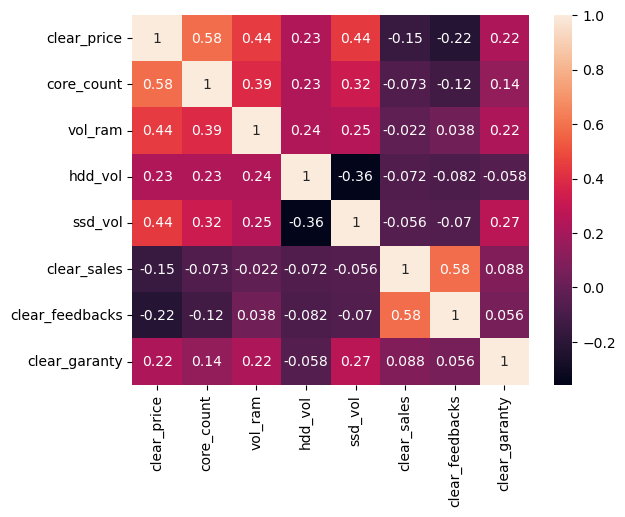

In [4]:
columns = ['clear_price', 'core_count', 'vol_ram', 'hdd_vol', 'ssd_vol', 'clear_sales', 'clear_feedbacks', 'clear_garanty']
hm = sns.heatmap(df[columns].corr(method = 'spearman'), annot = True)

Проверим значимость найденных корреляционных коэффициентов

Для признака clear_price

In [726]:
scipy.stats.spearmanr(df.clear_price, df.core_count)

SpearmanrResult(correlation=0.5845664446254794, pvalue=4.3494013300400326e-246)

In [727]:
scipy.stats.spearmanr(df.clear_price, df.vol_ram)

SpearmanrResult(correlation=0.4447800612686878, pvalue=1.0394398008429963e-130)

In [728]:
scipy.stats.spearmanr(df.clear_price, df.hdd_vol)

SpearmanrResult(correlation=0.22959960830104734, pvalue=1.771259941317087e-33)

In [729]:
scipy.stats.spearmanr(df.clear_price, df.ssd_vol)

SpearmanrResult(correlation=0.44248684792382764, pvalue=3.1335408415107647e-129)

In [730]:
scipy.stats.spearmanr(df.clear_price, df.clear_sales)

SpearmanrResult(correlation=-0.15005642477168032, pvalue=5.322053523583472e-15)

In [731]:
scipy.stats.spearmanr(df.clear_price, df.clear_feedbacks)

SpearmanrResult(correlation=-0.22381333907568818, pvalue=7.443054231725346e-32)

Для признака clear_sales

In [732]:
scipy.stats.spearmanr(df.clear_sales, df.core_count)

SpearmanrResult(correlation=-0.07272773681716888, pvalue=0.00016118089070092247)

In [733]:
scipy.stats.spearmanr(df.clear_sales, df.vol_ram)

SpearmanrResult(correlation=-0.022495285955669294, pvalue=0.24374511233792193)

In [734]:
scipy.stats.spearmanr(df.clear_sales, df.hdd_vol)

SpearmanrResult(correlation=-0.0715856829947505, pvalue=0.00020419112545089771)

In [735]:
scipy.stats.spearmanr(df.clear_sales, df.ssd_vol)

SpearmanrResult(correlation=-0.05624730062911864, pvalue=0.003538655601139821)

In [736]:
scipy.stats.spearmanr(df.clear_sales, df.seller_rating)

SpearmanrResult(correlation=0.11765712869875955, pvalue=9.515753154662787e-10)

In [737]:
scipy.stats.spearmanr(df.clear_sales, df.clear_feedbacks)

SpearmanrResult(correlation=0.5842532317706884, pvalue=9.17945494315917e-246)

In [738]:
price_fork

,Сбока ПК,Количество ПК,Минимальная цена,Максимальная цена,Ценовая вилка
0,game_PC/windows 11 pro/intel core i5/ядер 6/16...,78,76824,87300,10476
1,office_PC/windows 10 pro/amd ryzen 5/ядер 6/16...,57,30418,48168,17750
2,game_PC/windows 10 pro/intel core i5/ядер 6/16...,55,72806,86996,14190
3,game_PC/windows 11 pro/intel core i7/ядер 8/16...,47,82280,91080,8800
4,game_PC/windows 10 pro/intel core i5/ядер 6/16...,40,74395,92795,18400
5,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,39,33550,52368,18818
6,game_PC/windows 11 pro/intel core i5/ядер 6/16...,39,62823,68490,5667
7,game_PC/windows 11 pro/intel core i5/ядер 6/16...,36,71007,77571,6564
8,game_PC/windows 11 pro/intel core i5/ядер 6/16...,36,55431,64071,8640
9,game_PC/windows 10 pro/amd ryzen 5/ядер 6/32 Г...,35,81936,95752,13816


In [739]:
price_fork_for_sales

,Сбока ПК,Количество ПК,Минимальные продажи,Максимальные продажи,Ценовая вилка
0,office_PC/windows 10 pro/amd ryzen 5/ядер 6/16...,15,30418,37979,7561
1,office_PC/без oc/amd ryzen 5/ядер 6/16 Гб RAM/...,8,29354,39389,10035
2,game_PC/windows 10 pro/intel core i5/ядер 6/16...,6,54719,83438,28719
3,game_PC/windows 10 pro/intel core i3/ядер 4/8 ...,5,32851,36810,3959
4,game_PC/windows 10 pro/intel core i3/ядер 4/16...,5,35302,37794,2492
5,game_PC/без oc/intel core i3/ядер 4/8 Гб RAM/ ...,4,30760,32379,1619
6,game_PC/windows 10 pro/intel core i7/ядер 12/1...,4,103062,117108,14046
7,game_PC/windows 10 pro/intel core i5/ядер 6/16...,4,65115,65372,257
8,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,4,34694,39650,4956
9,office_PC/windows 10 pro/amd ryzen 5/ядер 6/32...,3,40971,48352,7381


In [743]:
popular_accessories

,Процессор,Количество ПК,Количество ядер,Количество ПК,Видеокарта,Количество ПК,Объем оперативной памяти,Количество ПК,Операционная система,Количество ПК,Объем hdd,Количество ПК,Объем ssd,Количество ПК
1,intel core i5,920,6,1266,nvidia geforce rtx 3060,569,16,1756,windows 10 pro,1511.0,0.0,1814.0,500,1522
2,intel core i7,526,4,535,nvidia geforce rtx 3050,435,32,525,windows 11 pro,567.0,1000.0,820.0,1000,756
3,intel core i3,468,8,345,nvidia geforce gtx 1650,321,8,365,без oc,348.0,500.0,44.0,250,270
4,amd ryzen 5,457,12,202,nvidia geforce gtx 1660,250,4,29,windows 10,268.0,2000.0,9.0,120,99
5,amd athlon,115,2,184,amd radeon vega 7,204,64,18,NaN,NaN,NaN,NaN,2000,16


In [740]:
price_fork.to_excel('price_fork.xlsx', index = False)

In [741]:
price_fork_for_sales.to_excel('price_fork_for_sales.xlsx', index = False)

In [742]:
popular_accessories.to_excel('popular_accessories.xlsx', index = False)

# Общие выводы по результатам анализа:

1. Для целевых признаков clear_price и clear_sales отклонена гипотеза о нормальном распределении
2. Выявлена статистическая значимость признаков и рассчитаны коэффициенты корреляции для обоих целевых признаков:
    2.1 Наибольшее влияние на цену ПК оказывают количество ядер процессора, объем оперативной памяти и объем ssd накопителя
    2.2 Наибольшее влияние на количество продаж оказывает количество отзывов
    2.3. Между признаками clear_price и clear_sales выявлена обратная зависимость, чем ниже цена - тем больше продажи
3. Определены самые распространенные сборки ПК и ценовая вилка на данные сборки, датафрейм сохранен в файл "price_fork.xlsx" и может быть предоставлен заказчику. 
4. Определены самые распространенные сборки ПК по количеству продаж, датафрейм сохранен в файл "price_fork_for_sales.xlsx" и может быть предоставлен заказчику. 
5. Выявлены топ 5 комплектующих для ПК, с учетом их встречаемости в датасете, датафрейм сохранен в файл "popular_accessories.xlsx" и может быть предоставлен заказчику. 
